In [12]:
import source.preprocess as prep
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2DTranspose, Layer, Lambda, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization, Activation, Reshape

from keras import backend as K
from keras.constraints import unit_norm, max_norm
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback
from keras.layers.advanced_activations import LeakyReLU

In [3]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
    
reset_random_seeds()

## Prep data ..

In [4]:
    
# path to collect the sequence data    
main_path = 'C:/Users/npral/OneDrive/Desktop/AI+ProteinEngineering/Code/VAEforDesign/Inputs'    
SH3_path = main_path + '/sh3_59.fasta'

# read the sequence data
SH3_sequences = prep.get_seq(SH3_path)

# clean up data
sample, positions = len(SH3_sequences), len(SH3_sequences[0])
SH3_MSA = prep.create_MSA(SH3_sequences, sample, positions)

# pandas dataframe format
SH3_df = pd.DataFrame(SH3_MSA)
SH3_df.columns = ['Sequence']

In [5]:
def create_one_hot(df):
    """
    function description: create one hot encoded tensors
    
    """
    # We will use this dictionary to map each character to an integer so that it can be used as an input to our ML models:
    dict_int2aa = {0:"A",1:"C",2:"D",3:"E",4:"F",5:"G",6:"H",7:"I",8:"K",9:"L",10:"M",11:"N",12:"P",13:"Q",14:"R",15:"S",16:"T",17:"V",18:"W",19:"Y",20:"-"}

    token2int = {x:i for i, x in enumerate('ACDEFGHIKLMNPQRSTVWY-')}

    train_inputs = prep.preprocess_inputs(SH3_df, token2int)
    


    hot_inputs = np.zeros((train_inputs.shape[0], positions, 21))
    for sample in range(train_inputs.shape[0]):
        hot_encoded = prep.OneHot_encode(train_inputs, sample)
        #print(hot_inputs.shape, hot_encoded)
        hot_inputs[sample, :,:] = hot_encoded
        
    return hot_inputs

In [6]:
# create SH3 dataset into one hot encoded tensors: shape --> (datasize, protein_len, aa_labels)
SH3_onehot_inputs = create_one_hot(SH3_df)

In [7]:
"""
Load the relative enrichment values that correspond to the sequences
"""
main_path = 'C:/Users/npral/OneDrive/Desktop/AI+ProteinEngineering/Code/VAEforDesign/'
rel_path = main_path + 'Inputs/RE.npz'
rel_enrich = np.load(rel_path)['RE_mapping']


## Model assembly ..

In [8]:
def create_encoder(seq_len, aa_var, z_dim, intermediate_dim, alpha = 0.1):
    
    # Encoder comp ...
    encoder_input = Input(shape = (seq_len, aa_var))

    # flatten tensor into a vector
    x = Flatten()(encoder_input)
    
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.3)(x)
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    
    encoder_output = Dense(z_dim)(x)
    
    return Model(encoder_input, encoder_output, name = 'encoder'), encoder_input


def create_decoder(seq_len, aa_var, z_dim, intermediate_dim, alpha = 0.):

    decoder_input = Input(shape=(z_dim,), name='z_sampling')

    x = Dense(intermediate_dim*1.5, kernel_initializer='random_normal', )(decoder_input)
    x = LeakyReLU(alpha)(x)
    x = Dense(intermediate_dim*1.5, kernel_initializer='random_normal',)(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.7)(x)
    x = Dense(intermediate_dim*1.5,  kernel_initializer='random_normal',)(x)    
    x = LeakyReLU(alpha)(x)

    outputs = Dense(intermediate_dim, activation='linear', kernel_initializer='random_normal',)(x)                 
    outputs = Reshape((seq_len, aa_var))(outputs)
    softmax = tf.keras.activations.softmax(outputs, axis=-1)
    
    return Model(decoder_input, softmax, name = 'decoder') 

#MMD loss
def compute_kernel(x, y):
    
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis = 2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x,x)
    y_kernel = compute_kernel(y,y)
    xy_kernel = compute_kernel(x,y)
    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

def mmdVAE_loss(train_z, train_xr, train_x):
    
    # sampling from the random noise ...
    batch_size = K.shape(train_z)[0]
    latent_dim = K.int_shape(train_z)[1]
    true_samples = K.random_normal(shape = (batch_size, latent_dim), mean = 0., stddev = 1.)
    
    # calc MMD loss
    loss_MMD = compute_mmd(true_samples, train_z)
    
    # calc the reconstruction loss (i.e. negative log-likelihood)
    loss_REC = K.mean(K.square(train_xr - train_x))

    return loss_REC + 2*loss_MMD




In [9]:
# hyperparameters ...

z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = SH3_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width


In [13]:
from sklearn.model_selection import KFold

def define_model(seq_len, aa_var, z_dim, intermediate_dim, alpha):
    # def model 
    encoder, encoder_input = create_encoder(seq_len, aa_var, z_dim, intermediate_dim, alpha)
    decoder = create_decoder(seq_len, aa_var, z_dim, intermediate_dim, alpha)

    # construct the complete MMD VAE model ...
    train_z = encoder(encoder_input)
    train_xr = decoder(train_z)
    MMD_VAE = Model(encoder_input, train_xr)

    #compile the whole model
    loss = mmdVAE_loss(train_z, train_xr, encoder_input)
    MMD_VAE.add_loss(loss)
    opt = tf.keras.optimizers.Adam(learning_rate= 0.000100023123)
    MMD_VAE.compile(optimizer = opt, metrics = ['MSE', 'categorical_crossentropy'])
    
    return MMD_VAE




kf = KFold(n_splits=5)

batch_size = 128
epochs = 1000

    
train_loss, valid_loss = [], []
train_MSE, valid_MSE = [], []
train_CE, valid_CE = [], []
z_dim_list, k_fold_list = [], []
for z_dim in tqdm([1, 2, 3, 4, 5]):

    k_fold = 0
    for train_index, valid_index in kf.split(SH3_onehot_inputs):
        
        z_dim_list.append(z_dim)
        k_fold_list.append(k_fold)
        
        # data splits ...
        train_x = SH3_onehot_inputs[train_index]
        valid_x = SH3_onehot_inputs[valid_index]


        # create model
        MMD_VAE = define_model(seq_len, aa_var, z_dim, intermediate_dim, alpha)

        history = MMD_VAE.fit(train_x,
                          train_x,
                          epochs = epochs, 
                          batch_size = batch_size,
                          shuffle = True,
                          verbose = 2,
                          validation_data = (valid_x, valid_x)
        )


        # loss measurements
        train_loss.append(history.history['loss'][-1])
        valid_loss.append(history.history['val_loss'][-1])
        
        # MSE measurements
        train_MSE.append(history.history['MSE'][-1])
        valid_MSE.append(history.history['val_MSE'][-1])
        
        # CE measurements
        train_CE.append(history.history['categorical_crossentropy'][-1])
        valid_CE.append(history.history['val_categorical_crossentropy'][-1])
            
        k_fold+=1 # increase kfold index

  0%|                                                                                                                                 | 0/5 [00:00<?, ?it/s]

Epoch 1/1000
34/34 - 1s - loss: 0.1922 - MSE: 0.0444 - categorical_crossentropy: 2.9126 - val_loss: 0.2759 - val_MSE: 0.0426 - val_categorical_crossentropy: 2.6919
Epoch 2/1000
34/34 - 0s - loss: 0.0711 - MSE: 0.0398 - categorical_crossentropy: 2.4617 - val_loss: 0.2873 - val_MSE: 0.0384 - val_categorical_crossentropy: 2.3092
Epoch 3/1000
34/34 - 0s - loss: 0.0846 - MSE: 0.0377 - categorical_crossentropy: 2.2845 - val_loss: 0.3270 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1538
Epoch 4/1000
34/34 - 0s - loss: 0.0933 - MSE: 0.0368 - categorical_crossentropy: 2.1873 - val_loss: 0.2285 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0782
Epoch 5/1000
34/34 - 0s - loss: 0.0629 - MSE: 0.0361 - categorical_crossentropy: 2.0924 - val_loss: 0.2613 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0184
Epoch 6/1000
34/34 - 0s - loss: 0.0838 - MSE: 0.0357 - categorical_crossentropy: 2.0463 - val_loss: 0.2807 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9914
Epoch 7/1000
34/

Epoch 50/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0350 - categorical_crossentropy: 1.9430 - val_loss: 0.2688 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9343
Epoch 51/1000
34/34 - 0s - loss: 0.0625 - MSE: 0.0350 - categorical_crossentropy: 1.9409 - val_loss: 0.2895 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9377
Epoch 52/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0349 - categorical_crossentropy: 1.9384 - val_loss: 0.2943 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9374
Epoch 53/1000
34/34 - 0s - loss: 0.0587 - MSE: 0.0349 - categorical_crossentropy: 1.9351 - val_loss: 0.2881 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9335
Epoch 54/1000
34/34 - 0s - loss: 0.0584 - MSE: 0.0349 - categorical_crossentropy: 1.9355 - val_loss: 0.2913 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9344
Epoch 55/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0349 - categorical_crossentropy: 1.9361 - val_loss: 0.2990 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9327
Epoch 56/1

Epoch 100/1000
34/34 - 0s - loss: 0.0525 - MSE: 0.0349 - categorical_crossentropy: 1.9276 - val_loss: 0.3575 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9349
Epoch 101/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0349 - categorical_crossentropy: 1.9250 - val_loss: 0.3660 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9316
Epoch 102/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0349 - categorical_crossentropy: 1.9233 - val_loss: 0.3135 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9282
Epoch 103/1000
34/34 - 0s - loss: 0.0623 - MSE: 0.0348 - categorical_crossentropy: 1.9204 - val_loss: 0.3568 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9254
Epoch 104/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0348 - categorical_crossentropy: 1.9236 - val_loss: 0.3039 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9263
Epoch 105/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0348 - categorical_crossentropy: 1.9209 - val_loss: 0.3386 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9246
Epoc

Epoch 150/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0346 - categorical_crossentropy: 1.9092 - val_loss: 0.3367 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9235
Epoch 151/1000
34/34 - 0s - loss: 0.0621 - MSE: 0.0346 - categorical_crossentropy: 1.9105 - val_loss: 0.3747 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9250
Epoch 152/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0345 - categorical_crossentropy: 1.9080 - val_loss: 0.3098 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9255
Epoch 153/1000
34/34 - 0s - loss: 0.0689 - MSE: 0.0344 - categorical_crossentropy: 1.9061 - val_loss: 0.3656 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9233
Epoch 154/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0346 - categorical_crossentropy: 1.9127 - val_loss: 0.3651 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9191
Epoch 155/1000
34/34 - 0s - loss: 0.0722 - MSE: 0.0346 - categorical_crossentropy: 1.9116 - val_loss: 0.3980 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9199
Epoc

Epoch 200/1000
34/34 - 0s - loss: 0.0566 - MSE: 0.0347 - categorical_crossentropy: 1.9113 - val_loss: 0.4151 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9280
Epoch 201/1000
34/34 - 0s - loss: 0.0670 - MSE: 0.0346 - categorical_crossentropy: 1.9122 - val_loss: 0.3722 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9284
Epoch 202/1000
34/34 - 0s - loss: 0.0616 - MSE: 0.0346 - categorical_crossentropy: 1.9120 - val_loss: 0.3684 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9302
Epoch 203/1000
34/34 - 0s - loss: 0.0628 - MSE: 0.0346 - categorical_crossentropy: 1.9116 - val_loss: 0.3684 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9268
Epoch 204/1000
34/34 - 0s - loss: 0.0621 - MSE: 0.0346 - categorical_crossentropy: 1.9121 - val_loss: 0.3523 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9245
Epoch 205/1000
34/34 - 0s - loss: 0.0594 - MSE: 0.0347 - categorical_crossentropy: 1.9139 - val_loss: 0.3700 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9237
Epoc

Epoch 250/1000
34/34 - 0s - loss: 0.0609 - MSE: 0.0344 - categorical_crossentropy: 1.8947 - val_loss: 0.3977 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9179
Epoch 251/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0343 - categorical_crossentropy: 1.8872 - val_loss: 0.4080 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9155
Epoch 252/1000
34/34 - 0s - loss: 0.0645 - MSE: 0.0343 - categorical_crossentropy: 1.8861 - val_loss: 0.3853 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9165
Epoch 253/1000
34/34 - 0s - loss: 0.0630 - MSE: 0.0344 - categorical_crossentropy: 1.8901 - val_loss: 0.3355 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9137
Epoch 254/1000
34/34 - 0s - loss: 0.0604 - MSE: 0.0344 - categorical_crossentropy: 1.8872 - val_loss: 0.4140 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9151
Epoch 255/1000
34/34 - 0s - loss: 0.0587 - MSE: 0.0345 - categorical_crossentropy: 1.8927 - val_loss: 0.3812 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9161
Epoc

Epoch 300/1000
34/34 - 0s - loss: 0.0523 - MSE: 0.0341 - categorical_crossentropy: 1.8760 - val_loss: 0.3847 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9113
Epoch 301/1000
34/34 - 0s - loss: 0.0634 - MSE: 0.0342 - categorical_crossentropy: 1.8827 - val_loss: 0.4051 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9144
Epoch 302/1000
34/34 - 0s - loss: 0.0720 - MSE: 0.0343 - categorical_crossentropy: 1.8866 - val_loss: 0.3726 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9111
Epoch 303/1000
34/34 - 0s - loss: 0.0562 - MSE: 0.0343 - categorical_crossentropy: 1.8855 - val_loss: 0.4065 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9081
Epoch 304/1000
34/34 - 0s - loss: 0.0674 - MSE: 0.0341 - categorical_crossentropy: 1.8771 - val_loss: 0.4006 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9078
Epoch 305/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0342 - categorical_crossentropy: 1.8814 - val_loss: 0.4200 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9133
Epoc

Epoch 350/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0341 - categorical_crossentropy: 1.8799 - val_loss: 0.4035 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9156
Epoch 351/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0340 - categorical_crossentropy: 1.8736 - val_loss: 0.4238 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9133
Epoch 352/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0340 - categorical_crossentropy: 1.8720 - val_loss: 0.3707 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9151
Epoch 353/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0340 - categorical_crossentropy: 1.8697 - val_loss: 0.4008 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9152
Epoch 354/1000
34/34 - 0s - loss: 0.0587 - MSE: 0.0341 - categorical_crossentropy: 1.8760 - val_loss: 0.3574 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9159
Epoch 355/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0341 - categorical_crossentropy: 1.8714 - val_loss: 0.4143 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9160
Epoc

Epoch 400/1000
34/34 - 0s - loss: 0.0603 - MSE: 0.0338 - categorical_crossentropy: 1.8561 - val_loss: 0.3796 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9208
Epoch 401/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0337 - categorical_crossentropy: 1.8464 - val_loss: 0.3627 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9198
Epoch 402/1000
34/34 - 0s - loss: 0.0573 - MSE: 0.0337 - categorical_crossentropy: 1.8483 - val_loss: 0.3616 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9167
Epoch 403/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0337 - categorical_crossentropy: 1.8502 - val_loss: 0.3809 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9174
Epoch 404/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0336 - categorical_crossentropy: 1.8475 - val_loss: 0.3968 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9192
Epoch 405/1000
34/34 - 0s - loss: 0.0787 - MSE: 0.0338 - categorical_crossentropy: 1.8573 - val_loss: 0.3686 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9200
Epoc

Epoch 450/1000
34/34 - 0s - loss: 0.0561 - MSE: 0.0335 - categorical_crossentropy: 1.8407 - val_loss: 0.3657 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9165
Epoch 451/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0335 - categorical_crossentropy: 1.8440 - val_loss: 0.3691 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9168
Epoch 452/1000
34/34 - 0s - loss: 0.0580 - MSE: 0.0335 - categorical_crossentropy: 1.8453 - val_loss: 0.3658 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9173
Epoch 453/1000
34/34 - 0s - loss: 0.0602 - MSE: 0.0334 - categorical_crossentropy: 1.8381 - val_loss: 0.4163 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9164
Epoch 454/1000
34/34 - 0s - loss: 0.0634 - MSE: 0.0335 - categorical_crossentropy: 1.8395 - val_loss: 0.4163 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9147
Epoch 455/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0335 - categorical_crossentropy: 1.8437 - val_loss: 0.4062 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9173
Epoc

Epoch 500/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0334 - categorical_crossentropy: 1.8290 - val_loss: 0.3676 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9193
Epoch 501/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0335 - categorical_crossentropy: 1.8381 - val_loss: 0.3135 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9197
Epoch 502/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0334 - categorical_crossentropy: 1.8378 - val_loss: 0.3828 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9160
Epoch 503/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0333 - categorical_crossentropy: 1.8339 - val_loss: 0.3671 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9179
Epoch 504/1000
34/34 - 0s - loss: 0.0607 - MSE: 0.0332 - categorical_crossentropy: 1.8265 - val_loss: 0.3845 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9138
Epoch 505/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0333 - categorical_crossentropy: 1.8256 - val_loss: 0.3592 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9163
Epoc

Epoch 550/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0334 - categorical_crossentropy: 1.8241 - val_loss: 0.3874 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9188
Epoch 551/1000
34/34 - 0s - loss: 0.0612 - MSE: 0.0333 - categorical_crossentropy: 1.8232 - val_loss: 0.3648 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9211
Epoch 552/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0332 - categorical_crossentropy: 1.8201 - val_loss: 0.3874 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9176
Epoch 553/1000
34/34 - 0s - loss: 0.0622 - MSE: 0.0332 - categorical_crossentropy: 1.8162 - val_loss: 0.3792 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9196
Epoch 554/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0333 - categorical_crossentropy: 1.8224 - val_loss: 0.4097 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9230
Epoch 555/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0330 - categorical_crossentropy: 1.8080 - val_loss: 0.3742 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9176
Epoc

Epoch 600/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0328 - categorical_crossentropy: 1.8012 - val_loss: 0.3532 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9175
Epoch 601/1000
34/34 - 0s - loss: 0.0603 - MSE: 0.0328 - categorical_crossentropy: 1.7988 - val_loss: 0.4100 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9161
Epoch 602/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0327 - categorical_crossentropy: 1.7974 - val_loss: 0.3633 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9153
Epoch 603/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0327 - categorical_crossentropy: 1.7961 - val_loss: 0.3875 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9137
Epoch 604/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0328 - categorical_crossentropy: 1.8009 - val_loss: 0.3648 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9137
Epoch 605/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0330 - categorical_crossentropy: 1.8091 - val_loss: 0.3482 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9133
Epoc

Epoch 650/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0326 - categorical_crossentropy: 1.7861 - val_loss: 0.3716 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9203
Epoch 651/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0328 - categorical_crossentropy: 1.7951 - val_loss: 0.3604 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9184
Epoch 652/1000
34/34 - 0s - loss: 0.0654 - MSE: 0.0331 - categorical_crossentropy: 1.8093 - val_loss: 0.3586 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9160
Epoch 653/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0328 - categorical_crossentropy: 1.7982 - val_loss: 0.3358 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9166
Epoch 654/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0327 - categorical_crossentropy: 1.7904 - val_loss: 0.3148 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9173
Epoch 655/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0327 - categorical_crossentropy: 1.7935 - val_loss: 0.3786 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9170
Epoc

Epoch 700/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0327 - categorical_crossentropy: 1.7930 - val_loss: 0.3814 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9182
Epoch 701/1000
34/34 - 0s - loss: 0.0545 - MSE: 0.0326 - categorical_crossentropy: 1.7870 - val_loss: 0.3572 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9171
Epoch 702/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0327 - categorical_crossentropy: 1.7866 - val_loss: 0.3132 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9192
Epoch 703/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0325 - categorical_crossentropy: 1.7787 - val_loss: 0.3735 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9170
Epoch 704/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0325 - categorical_crossentropy: 1.7772 - val_loss: 0.3043 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9172
Epoch 705/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0324 - categorical_crossentropy: 1.7762 - val_loss: 0.3297 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9192
Epoc

Epoch 750/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0322 - categorical_crossentropy: 1.7653 - val_loss: 0.3460 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9197
Epoch 751/1000
34/34 - 0s - loss: 0.0569 - MSE: 0.0323 - categorical_crossentropy: 1.7674 - val_loss: 0.3782 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9218
Epoch 752/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0322 - categorical_crossentropy: 1.7664 - val_loss: 0.3343 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9208
Epoch 753/1000
34/34 - 0s - loss: 0.0603 - MSE: 0.0322 - categorical_crossentropy: 1.7658 - val_loss: 0.3479 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9213
Epoch 754/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0323 - categorical_crossentropy: 1.7743 - val_loss: 0.3190 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9196
Epoch 755/1000
34/34 - 0s - loss: 0.0550 - MSE: 0.0325 - categorical_crossentropy: 1.7769 - val_loss: 0.3618 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9193
Epoc

Epoch 800/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0321 - categorical_crossentropy: 1.7611 - val_loss: 0.3687 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9151
Epoch 801/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0321 - categorical_crossentropy: 1.7603 - val_loss: 0.2811 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9172
Epoch 802/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0320 - categorical_crossentropy: 1.7586 - val_loss: 0.3206 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9162
Epoch 803/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0320 - categorical_crossentropy: 1.7571 - val_loss: 0.3375 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9189
Epoch 804/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0319 - categorical_crossentropy: 1.7540 - val_loss: 0.3144 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9190
Epoch 805/1000
34/34 - 0s - loss: 0.0580 - MSE: 0.0320 - categorical_crossentropy: 1.7556 - val_loss: 0.3548 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9171
Epoc

Epoch 850/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0321 - categorical_crossentropy: 1.7614 - val_loss: 0.3328 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9212
Epoch 851/1000
34/34 - 0s - loss: 0.0512 - MSE: 0.0319 - categorical_crossentropy: 1.7529 - val_loss: 0.3201 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9223
Epoch 852/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0320 - categorical_crossentropy: 1.7592 - val_loss: 0.3082 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9207
Epoch 853/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0322 - categorical_crossentropy: 1.7686 - val_loss: 0.3138 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9220
Epoch 854/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0319 - categorical_crossentropy: 1.7541 - val_loss: 0.3618 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9231
Epoch 855/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0320 - categorical_crossentropy: 1.7565 - val_loss: 0.3040 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9233
Epoc

Epoch 900/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0322 - categorical_crossentropy: 1.7676 - val_loss: 0.2865 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9169
Epoch 901/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0324 - categorical_crossentropy: 1.7761 - val_loss: 0.3188 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9197
Epoch 902/1000
34/34 - 0s - loss: 0.0528 - MSE: 0.0324 - categorical_crossentropy: 1.7715 - val_loss: 0.3293 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9172
Epoch 903/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0321 - categorical_crossentropy: 1.7593 - val_loss: 0.3487 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9186
Epoch 904/1000
34/34 - 0s - loss: 0.0603 - MSE: 0.0321 - categorical_crossentropy: 1.7565 - val_loss: 0.3273 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9177
Epoch 905/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0323 - categorical_crossentropy: 1.7700 - val_loss: 0.2793 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9168
Epoc

Epoch 950/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0320 - categorical_crossentropy: 1.7546 - val_loss: 0.3220 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9170
Epoch 951/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0319 - categorical_crossentropy: 1.7481 - val_loss: 0.3616 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9167
Epoch 952/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0319 - categorical_crossentropy: 1.7518 - val_loss: 0.3457 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9160
Epoch 953/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0319 - categorical_crossentropy: 1.7504 - val_loss: 0.3092 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9171
Epoch 954/1000
34/34 - 0s - loss: 0.0507 - MSE: 0.0319 - categorical_crossentropy: 1.7498 - val_loss: 0.3169 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9135
Epoch 955/1000
34/34 - 0s - loss: 0.0574 - MSE: 0.0319 - categorical_crossentropy: 1.7486 - val_loss: 0.3141 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9159
Epoc

Epoch 1000/1000
34/34 - 0s - loss: 0.0531 - MSE: 0.0319 - categorical_crossentropy: 1.7510 - val_loss: 0.3211 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9230
Epoch 1/1000
34/34 - 0s - loss: 0.1649 - MSE: 0.0444 - categorical_crossentropy: 2.9306 - val_loss: 0.1799 - val_MSE: 0.0423 - val_categorical_crossentropy: 2.6858
Epoch 2/1000
34/34 - 0s - loss: 0.0975 - MSE: 0.0397 - categorical_crossentropy: 2.4589 - val_loss: 0.1237 - val_MSE: 0.0380 - val_categorical_crossentropy: 2.2882
Epoch 3/1000
34/34 - 0s - loss: 0.0922 - MSE: 0.0378 - categorical_crossentropy: 2.2859 - val_loss: 0.1493 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1456
Epoch 4/1000
34/34 - 0s - loss: 0.1297 - MSE: 0.0369 - categorical_crossentropy: 2.1890 - val_loss: 0.2806 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0772
Epoch 5/1000
34/34 - 0s - loss: 0.1269 - MSE: 0.0363 - categorical_crossentropy: 2.1133 - val_loss: 0.1568 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0125
Epoch 6/1000


Epoch 50/1000
34/34 - 0s - loss: 0.0754 - MSE: 0.0350 - categorical_crossentropy: 1.9382 - val_loss: 0.4216 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9662
Epoch 51/1000
34/34 - 0s - loss: 0.0705 - MSE: 0.0350 - categorical_crossentropy: 1.9400 - val_loss: 0.3066 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9625
Epoch 52/1000
34/34 - 0s - loss: 0.0546 - MSE: 0.0351 - categorical_crossentropy: 1.9428 - val_loss: 0.3208 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9608
Epoch 53/1000
34/34 - 0s - loss: 0.0638 - MSE: 0.0350 - categorical_crossentropy: 1.9364 - val_loss: 0.3066 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9592
Epoch 54/1000
34/34 - 0s - loss: 0.0658 - MSE: 0.0349 - categorical_crossentropy: 1.9291 - val_loss: 0.3011 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9572
Epoch 55/1000
34/34 - 1s - loss: 0.0585 - MSE: 0.0348 - categorical_crossentropy: 1.9272 - val_loss: 0.2891 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9565
Epoch 56/1

Epoch 100/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0347 - categorical_crossentropy: 1.9161 - val_loss: 0.2855 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9469
Epoch 101/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0348 - categorical_crossentropy: 1.9202 - val_loss: 0.2952 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9464
Epoch 102/1000
34/34 - 0s - loss: 0.0677 - MSE: 0.0348 - categorical_crossentropy: 1.9218 - val_loss: 0.2076 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9506
Epoch 103/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0348 - categorical_crossentropy: 1.9197 - val_loss: 0.2882 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9475
Epoch 104/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0347 - categorical_crossentropy: 1.9130 - val_loss: 0.2871 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9457
Epoch 105/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0346 - categorical_crossentropy: 1.9042 - val_loss: 0.3470 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9469
Epoc

Epoch 150/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0347 - categorical_crossentropy: 1.9038 - val_loss: 0.3690 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9526
Epoch 151/1000
34/34 - 0s - loss: 0.0615 - MSE: 0.0348 - categorical_crossentropy: 1.9132 - val_loss: 0.4205 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9456
Epoch 152/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0347 - categorical_crossentropy: 1.9069 - val_loss: 0.3665 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9500
Epoch 153/1000
34/34 - 0s - loss: 0.0609 - MSE: 0.0346 - categorical_crossentropy: 1.9015 - val_loss: 0.3556 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9520
Epoch 154/1000
34/34 - 0s - loss: 0.0580 - MSE: 0.0346 - categorical_crossentropy: 1.8996 - val_loss: 0.3835 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9485
Epoch 155/1000
34/34 - 0s - loss: 0.0628 - MSE: 0.0345 - categorical_crossentropy: 1.8968 - val_loss: 0.3483 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9451
Epoc

Epoch 200/1000
34/34 - 0s - loss: 0.0698 - MSE: 0.0344 - categorical_crossentropy: 1.8892 - val_loss: 0.3225 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9384
Epoch 201/1000
34/34 - 0s - loss: 0.0697 - MSE: 0.0344 - categorical_crossentropy: 1.8899 - val_loss: 0.3336 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9334
Epoch 202/1000
34/34 - 0s - loss: 0.0674 - MSE: 0.0342 - categorical_crossentropy: 1.8768 - val_loss: 0.4064 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9304
Epoch 203/1000
34/34 - 0s - loss: 0.0597 - MSE: 0.0343 - categorical_crossentropy: 1.8841 - val_loss: 0.4025 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9312
Epoch 204/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0343 - categorical_crossentropy: 1.8817 - val_loss: 0.3958 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9319
Epoch 205/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0343 - categorical_crossentropy: 1.8801 - val_loss: 0.4145 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9314
Epoc

Epoch 250/1000
34/34 - 0s - loss: 0.0663 - MSE: 0.0343 - categorical_crossentropy: 1.8849 - val_loss: 0.3725 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9385
Epoch 251/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0342 - categorical_crossentropy: 1.8823 - val_loss: 0.3824 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9321
Epoch 252/1000
34/34 - 0s - loss: 0.0505 - MSE: 0.0342 - categorical_crossentropy: 1.8801 - val_loss: 0.4430 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9324
Epoch 253/1000
34/34 - 0s - loss: 0.0622 - MSE: 0.0343 - categorical_crossentropy: 1.8850 - val_loss: 0.3686 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9336
Epoch 254/1000
34/34 - 0s - loss: 0.0702 - MSE: 0.0343 - categorical_crossentropy: 1.8851 - val_loss: 0.3576 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9335
Epoch 255/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0343 - categorical_crossentropy: 1.8861 - val_loss: 0.3493 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9397
Epoc

Epoch 300/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0338 - categorical_crossentropy: 1.8557 - val_loss: 0.4316 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9349
Epoch 301/1000
34/34 - 0s - loss: 0.0638 - MSE: 0.0338 - categorical_crossentropy: 1.8563 - val_loss: 0.4442 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9324
Epoch 302/1000
34/34 - 0s - loss: 0.0604 - MSE: 0.0338 - categorical_crossentropy: 1.8549 - val_loss: 0.5742 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9385
Epoch 303/1000
34/34 - 0s - loss: 0.0625 - MSE: 0.0340 - categorical_crossentropy: 1.8672 - val_loss: 0.4909 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9292
Epoch 304/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0338 - categorical_crossentropy: 1.8540 - val_loss: 0.4468 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9363
Epoch 305/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0337 - categorical_crossentropy: 1.8496 - val_loss: 0.3814 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9326
Epoc

Epoch 350/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0337 - categorical_crossentropy: 1.8478 - val_loss: 0.4460 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9280
Epoch 351/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0336 - categorical_crossentropy: 1.8484 - val_loss: 0.4671 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9295
Epoch 352/1000
34/34 - 1s - loss: 0.0521 - MSE: 0.0336 - categorical_crossentropy: 1.8505 - val_loss: 0.4600 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9295
Epoch 353/1000
34/34 - 1s - loss: 0.0554 - MSE: 0.0337 - categorical_crossentropy: 1.8568 - val_loss: 0.4071 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9311
Epoch 354/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0337 - categorical_crossentropy: 1.8563 - val_loss: 0.4440 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9308
Epoch 355/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0336 - categorical_crossentropy: 1.8487 - val_loss: 0.4588 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9291
Epoc

Epoch 400/1000
34/34 - 0s - loss: 0.0586 - MSE: 0.0337 - categorical_crossentropy: 1.8412 - val_loss: 0.4606 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9231
Epoch 401/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0335 - categorical_crossentropy: 1.8267 - val_loss: 0.4405 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9202
Epoch 402/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0333 - categorical_crossentropy: 1.8181 - val_loss: 0.3941 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9234
Epoch 403/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0333 - categorical_crossentropy: 1.8192 - val_loss: 0.3802 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9193
Epoch 404/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0333 - categorical_crossentropy: 1.8187 - val_loss: 0.4521 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9212
Epoch 405/1000
34/34 - 0s - loss: 0.0538 - MSE: 0.0332 - categorical_crossentropy: 1.8197 - val_loss: 0.4621 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9232
Epoc

Epoch 450/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0331 - categorical_crossentropy: 1.8217 - val_loss: 0.3780 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9257
Epoch 451/1000
34/34 - 0s - loss: 0.0583 - MSE: 0.0331 - categorical_crossentropy: 1.8202 - val_loss: 0.4412 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9275
Epoch 452/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0331 - categorical_crossentropy: 1.8198 - val_loss: 0.4021 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9225
Epoch 453/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0329 - categorical_crossentropy: 1.8096 - val_loss: 0.4124 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9188
Epoch 454/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0328 - categorical_crossentropy: 1.8050 - val_loss: 0.4009 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9209
Epoch 455/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0329 - categorical_crossentropy: 1.8099 - val_loss: 0.4581 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9196
Epoc

Epoch 500/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0329 - categorical_crossentropy: 1.8010 - val_loss: 0.4369 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9276
Epoch 501/1000
34/34 - 0s - loss: 0.0570 - MSE: 0.0329 - categorical_crossentropy: 1.8036 - val_loss: 0.4046 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9267
Epoch 502/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0329 - categorical_crossentropy: 1.7998 - val_loss: 0.4325 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9267
Epoch 503/1000
34/34 - 0s - loss: 0.0544 - MSE: 0.0329 - categorical_crossentropy: 1.7975 - val_loss: 0.4378 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9261
Epoch 504/1000
34/34 - 0s - loss: 0.0536 - MSE: 0.0329 - categorical_crossentropy: 1.7994 - val_loss: 0.4433 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9259
Epoch 505/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0328 - categorical_crossentropy: 1.7918 - val_loss: 0.4220 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9301
Epoc

Epoch 550/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0327 - categorical_crossentropy: 1.7885 - val_loss: 0.4636 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9286
Epoch 551/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0326 - categorical_crossentropy: 1.7873 - val_loss: 0.4156 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9235
Epoch 552/1000
34/34 - 0s - loss: 0.0620 - MSE: 0.0327 - categorical_crossentropy: 1.7895 - val_loss: 0.3674 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9319
Epoch 553/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0327 - categorical_crossentropy: 1.7879 - val_loss: 0.4454 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9254
Epoch 554/1000
34/34 - 0s - loss: 0.0583 - MSE: 0.0326 - categorical_crossentropy: 1.7831 - val_loss: 0.3861 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9294
Epoch 555/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0325 - categorical_crossentropy: 1.7778 - val_loss: 0.3702 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9299
Epoc

Epoch 600/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0326 - categorical_crossentropy: 1.7804 - val_loss: 0.3622 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9252
Epoch 601/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0327 - categorical_crossentropy: 1.7924 - val_loss: 0.4319 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9210
Epoch 602/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0324 - categorical_crossentropy: 1.7740 - val_loss: 0.3617 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9262
Epoch 603/1000
34/34 - 0s - loss: 0.0605 - MSE: 0.0323 - categorical_crossentropy: 1.7673 - val_loss: 0.3620 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9196
Epoch 604/1000
34/34 - 0s - loss: 0.0498 - MSE: 0.0324 - categorical_crossentropy: 1.7759 - val_loss: 0.4002 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9186
Epoch 605/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0324 - categorical_crossentropy: 1.7750 - val_loss: 0.4128 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9265
Epoc

Epoch 650/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0321 - categorical_crossentropy: 1.7561 - val_loss: 0.3576 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9381
Epoch 651/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0322 - categorical_crossentropy: 1.7567 - val_loss: 0.3929 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9279
Epoch 652/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0321 - categorical_crossentropy: 1.7519 - val_loss: 0.3748 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9246
Epoch 653/1000
34/34 - 0s - loss: 0.0517 - MSE: 0.0322 - categorical_crossentropy: 1.7590 - val_loss: 0.3857 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9334
Epoch 654/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0321 - categorical_crossentropy: 1.7552 - val_loss: 0.4057 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9270
Epoch 655/1000
34/34 - 0s - loss: 0.0679 - MSE: 0.0321 - categorical_crossentropy: 1.7565 - val_loss: 0.3955 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9403
Epoc

Epoch 700/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0323 - categorical_crossentropy: 1.7767 - val_loss: 0.3678 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9453
Epoch 701/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0323 - categorical_crossentropy: 1.7798 - val_loss: 0.4193 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9393
Epoch 702/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0324 - categorical_crossentropy: 1.7836 - val_loss: 0.4202 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9381
Epoch 703/1000
34/34 - 0s - loss: 0.0633 - MSE: 0.0324 - categorical_crossentropy: 1.7835 - val_loss: 0.3625 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9413
Epoch 704/1000
34/34 - 0s - loss: 0.0606 - MSE: 0.0325 - categorical_crossentropy: 1.7830 - val_loss: 0.4186 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9445
Epoch 705/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0324 - categorical_crossentropy: 1.7777 - val_loss: 0.4445 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9353
Epoc

Epoch 750/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0331 - categorical_crossentropy: 1.8129 - val_loss: 0.3781 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9108
Epoch 751/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0328 - categorical_crossentropy: 1.7944 - val_loss: 0.3730 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9227
Epoch 752/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0325 - categorical_crossentropy: 1.7840 - val_loss: 0.3709 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9217
Epoch 753/1000
34/34 - 0s - loss: 0.0511 - MSE: 0.0325 - categorical_crossentropy: 1.7795 - val_loss: 0.3785 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9186
Epoch 754/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0325 - categorical_crossentropy: 1.7810 - val_loss: 0.3839 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9220
Epoch 755/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0323 - categorical_crossentropy: 1.7702 - val_loss: 0.3818 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9217
Epoc

Epoch 800/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0323 - categorical_crossentropy: 1.7578 - val_loss: 0.3707 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9357
Epoch 801/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0322 - categorical_crossentropy: 1.7534 - val_loss: 0.4680 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9473
Epoch 802/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0320 - categorical_crossentropy: 1.7466 - val_loss: 0.4182 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9347
Epoch 803/1000
34/34 - 0s - loss: 0.0647 - MSE: 0.0321 - categorical_crossentropy: 1.7532 - val_loss: 0.4264 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9301
Epoch 804/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0320 - categorical_crossentropy: 1.7495 - val_loss: 0.4044 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9484
Epoch 805/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0320 - categorical_crossentropy: 1.7478 - val_loss: 0.3858 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9340
Epoc

Epoch 850/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0319 - categorical_crossentropy: 1.7367 - val_loss: 0.4204 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9277
Epoch 851/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0318 - categorical_crossentropy: 1.7347 - val_loss: 0.3665 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9417
Epoch 852/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0318 - categorical_crossentropy: 1.7340 - val_loss: 0.3921 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9335
Epoch 853/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0319 - categorical_crossentropy: 1.7408 - val_loss: 0.3719 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9500
Epoch 854/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0319 - categorical_crossentropy: 1.7410 - val_loss: 0.3554 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9351
Epoch 855/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0320 - categorical_crossentropy: 1.7446 - val_loss: 0.4009 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9371
Epoc

Epoch 900/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0322 - categorical_crossentropy: 1.7512 - val_loss: 0.3660 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9424
Epoch 901/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0319 - categorical_crossentropy: 1.7342 - val_loss: 0.3876 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9404
Epoch 902/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0318 - categorical_crossentropy: 1.7299 - val_loss: 0.4273 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9303
Epoch 903/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0320 - categorical_crossentropy: 1.7426 - val_loss: 0.3460 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9383
Epoch 904/1000
34/34 - 0s - loss: 0.0614 - MSE: 0.0320 - categorical_crossentropy: 1.7418 - val_loss: 0.3832 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9512
Epoch 905/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0321 - categorical_crossentropy: 1.7499 - val_loss: 0.4232 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9537
Epoc

Epoch 950/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0322 - categorical_crossentropy: 1.7586 - val_loss: 0.3204 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9380
Epoch 951/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0318 - categorical_crossentropy: 1.7385 - val_loss: 0.3874 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9503
Epoch 952/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0318 - categorical_crossentropy: 1.7339 - val_loss: 0.4216 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9557
Epoch 953/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0319 - categorical_crossentropy: 1.7363 - val_loss: 0.4058 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9457
Epoch 954/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0319 - categorical_crossentropy: 1.7371 - val_loss: 0.3792 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9342
Epoch 955/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0317 - categorical_crossentropy: 1.7287 - val_loss: 0.4126 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9488
Epoc

Epoch 1000/1000
34/34 - 0s - loss: 0.0546 - MSE: 0.0318 - categorical_crossentropy: 1.7406 - val_loss: 0.4309 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9552
Epoch 1/1000
34/34 - 0s - loss: 0.3501 - MSE: 0.0442 - categorical_crossentropy: 2.9178 - val_loss: 0.1873 - val_MSE: 0.0429 - val_categorical_crossentropy: 2.7328
Epoch 2/1000
34/34 - 0s - loss: 0.0845 - MSE: 0.0395 - categorical_crossentropy: 2.4406 - val_loss: 0.1881 - val_MSE: 0.0390 - val_categorical_crossentropy: 2.3731
Epoch 3/1000
34/34 - 0s - loss: 0.0677 - MSE: 0.0376 - categorical_crossentropy: 2.2519 - val_loss: 0.2185 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1712
Epoch 4/1000
34/34 - 0s - loss: 0.0696 - MSE: 0.0366 - categorical_crossentropy: 2.1486 - val_loss: 0.1986 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0954
Epoch 5/1000
34/34 - 0s - loss: 0.0684 - MSE: 0.0360 - categorical_crossentropy: 2.0723 - val_loss: 0.1610 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0636
Epoch 6/1000


Epoch 50/1000
34/34 - 0s - loss: 0.0654 - MSE: 0.0349 - categorical_crossentropy: 1.9265 - val_loss: 0.2529 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9996
Epoch 51/1000
34/34 - 0s - loss: 0.0729 - MSE: 0.0350 - categorical_crossentropy: 1.9322 - val_loss: 0.1886 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9965
Epoch 52/1000
34/34 - 0s - loss: 0.0602 - MSE: 0.0350 - categorical_crossentropy: 1.9334 - val_loss: 0.2007 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9955
Epoch 53/1000
34/34 - 0s - loss: 0.0617 - MSE: 0.0350 - categorical_crossentropy: 1.9324 - val_loss: 0.2235 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9977
Epoch 54/1000
34/34 - 0s - loss: 0.0715 - MSE: 0.0350 - categorical_crossentropy: 1.9370 - val_loss: 0.1764 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9951
Epoch 55/1000
34/34 - 0s - loss: 0.0803 - MSE: 0.0350 - categorical_crossentropy: 1.9345 - val_loss: 0.1695 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9959
Epoch 56/1

Epoch 100/1000
34/34 - 0s - loss: 0.0602 - MSE: 0.0346 - categorical_crossentropy: 1.8984 - val_loss: 0.2456 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9847
Epoch 101/1000
34/34 - 0s - loss: 0.0649 - MSE: 0.0345 - categorical_crossentropy: 1.8961 - val_loss: 0.3073 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9845
Epoch 102/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0346 - categorical_crossentropy: 1.8965 - val_loss: 0.2979 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9840
Epoch 103/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0346 - categorical_crossentropy: 1.8979 - val_loss: 0.2532 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9807
Epoch 104/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0346 - categorical_crossentropy: 1.8950 - val_loss: 0.3035 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9817
Epoch 105/1000
34/34 - 0s - loss: 0.0796 - MSE: 0.0347 - categorical_crossentropy: 1.9049 - val_loss: 0.3308 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9801
Epoc

Epoch 150/1000
34/34 - 0s - loss: 0.0655 - MSE: 0.0343 - categorical_crossentropy: 1.8778 - val_loss: 0.3107 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9974
Epoch 151/1000
34/34 - 0s - loss: 0.0701 - MSE: 0.0342 - categorical_crossentropy: 1.8795 - val_loss: 0.3292 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9945
Epoch 152/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0342 - categorical_crossentropy: 1.8783 - val_loss: 0.2844 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9988
Epoch 153/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0342 - categorical_crossentropy: 1.8798 - val_loss: 0.3326 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9975
Epoch 154/1000
34/34 - 0s - loss: 0.0671 - MSE: 0.0342 - categorical_crossentropy: 1.8793 - val_loss: 0.3187 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9986
Epoch 155/1000
34/34 - 0s - loss: 0.0614 - MSE: 0.0342 - categorical_crossentropy: 1.8786 - val_loss: 0.2822 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9988
Epoc

Epoch 200/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0337 - categorical_crossentropy: 1.8517 - val_loss: 0.3498 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9865
Epoch 201/1000
34/34 - 0s - loss: 0.0618 - MSE: 0.0337 - categorical_crossentropy: 1.8515 - val_loss: 0.2566 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9908
Epoch 202/1000
34/34 - 0s - loss: 0.0659 - MSE: 0.0339 - categorical_crossentropy: 1.8565 - val_loss: 0.3919 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9818
Epoch 203/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0338 - categorical_crossentropy: 1.8542 - val_loss: 0.3718 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9870
Epoch 204/1000
34/34 - 0s - loss: 0.0629 - MSE: 0.0338 - categorical_crossentropy: 1.8514 - val_loss: 0.3542 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9842
Epoch 205/1000
34/34 - 0s - loss: 0.0597 - MSE: 0.0340 - categorical_crossentropy: 1.8626 - val_loss: 0.3138 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9822
Epoc

Epoch 250/1000
34/34 - 0s - loss: 0.0581 - MSE: 0.0338 - categorical_crossentropy: 1.8498 - val_loss: 0.2935 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9879
Epoch 251/1000
34/34 - 0s - loss: 0.0528 - MSE: 0.0337 - categorical_crossentropy: 1.8486 - val_loss: 0.3407 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9877
Epoch 252/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0338 - categorical_crossentropy: 1.8488 - val_loss: 0.3242 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9941
Epoch 253/1000
34/34 - 0s - loss: 0.0590 - MSE: 0.0339 - categorical_crossentropy: 1.8543 - val_loss: 0.3109 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9849
Epoch 254/1000
34/34 - 0s - loss: 0.0634 - MSE: 0.0339 - categorical_crossentropy: 1.8555 - val_loss: 0.3171 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9853
Epoch 255/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0337 - categorical_crossentropy: 1.8481 - val_loss: 0.3743 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9887
Epoc

Epoch 300/1000
34/34 - 0s - loss: 0.0588 - MSE: 0.0339 - categorical_crossentropy: 1.8547 - val_loss: 0.3729 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9838
Epoch 301/1000
34/34 - 0s - loss: 0.0565 - MSE: 0.0340 - categorical_crossentropy: 1.8604 - val_loss: 0.2874 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9807
Epoch 302/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0338 - categorical_crossentropy: 1.8512 - val_loss: 0.2898 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9827
Epoch 303/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0338 - categorical_crossentropy: 1.8541 - val_loss: 0.2981 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9807
Epoch 304/1000
34/34 - 0s - loss: 0.0538 - MSE: 0.0338 - categorical_crossentropy: 1.8522 - val_loss: 0.3270 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9821
Epoch 305/1000
34/34 - 0s - loss: 0.0653 - MSE: 0.0337 - categorical_crossentropy: 1.8502 - val_loss: 0.3262 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9818
Epoc

Epoch 350/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0337 - categorical_crossentropy: 1.8473 - val_loss: 0.3171 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9851
Epoch 351/1000
34/34 - 0s - loss: 0.0612 - MSE: 0.0336 - categorical_crossentropy: 1.8398 - val_loss: 0.3402 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9849
Epoch 352/1000
34/34 - 0s - loss: 0.0584 - MSE: 0.0336 - categorical_crossentropy: 1.8412 - val_loss: 0.3083 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9830
Epoch 353/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0335 - categorical_crossentropy: 1.8312 - val_loss: 0.3187 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9847
Epoch 354/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0334 - categorical_crossentropy: 1.8302 - val_loss: 0.2960 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9820
Epoch 355/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0335 - categorical_crossentropy: 1.8350 - val_loss: 0.3076 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9820
Epoc

Epoch 400/1000
34/34 - 0s - loss: 0.0544 - MSE: 0.0332 - categorical_crossentropy: 1.8129 - val_loss: 0.3101 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9762
Epoch 401/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0333 - categorical_crossentropy: 1.8147 - val_loss: 0.3442 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9783
Epoch 402/1000
34/34 - 0s - loss: 0.0604 - MSE: 0.0332 - categorical_crossentropy: 1.8118 - val_loss: 0.3496 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9708
Epoch 403/1000
34/34 - 0s - loss: 0.0732 - MSE: 0.0333 - categorical_crossentropy: 1.8147 - val_loss: 0.3714 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9764
Epoch 404/1000
34/34 - 0s - loss: 0.0550 - MSE: 0.0334 - categorical_crossentropy: 1.8290 - val_loss: 0.3265 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0226
Epoch 405/1000
34/34 - 0s - loss: 0.0573 - MSE: 0.0336 - categorical_crossentropy: 1.8372 - val_loss: 0.3001 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0028
Epoc

Epoch 450/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0331 - categorical_crossentropy: 1.8089 - val_loss: 0.3408 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9707
Epoch 451/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0332 - categorical_crossentropy: 1.8168 - val_loss: 0.3232 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9736
Epoch 452/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0333 - categorical_crossentropy: 1.8149 - val_loss: 0.3272 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9747
Epoch 453/1000
34/34 - 0s - loss: 0.0586 - MSE: 0.0332 - categorical_crossentropy: 1.8091 - val_loss: 0.3236 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9721
Epoch 454/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0331 - categorical_crossentropy: 1.8046 - val_loss: 0.3347 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9720
Epoch 455/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0329 - categorical_crossentropy: 1.8003 - val_loss: 0.3257 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9749
Epoc

Epoch 500/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0330 - categorical_crossentropy: 1.8065 - val_loss: 0.2861 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9745
Epoch 501/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0331 - categorical_crossentropy: 1.8123 - val_loss: 0.3145 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9706
Epoch 502/1000
34/34 - 0s - loss: 0.0525 - MSE: 0.0329 - categorical_crossentropy: 1.8071 - val_loss: 0.2677 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9742
Epoch 503/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0332 - categorical_crossentropy: 1.8188 - val_loss: 0.2732 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9711
Epoch 504/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0329 - categorical_crossentropy: 1.8056 - val_loss: 0.2960 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9724
Epoch 505/1000
34/34 - 0s - loss: 0.0529 - MSE: 0.0331 - categorical_crossentropy: 1.8151 - val_loss: 0.2828 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9782
Epoc

Epoch 550/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0326 - categorical_crossentropy: 1.7810 - val_loss: 0.3111 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9732
Epoch 551/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0327 - categorical_crossentropy: 1.7838 - val_loss: 0.2918 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9727
Epoch 552/1000
34/34 - 0s - loss: 0.0591 - MSE: 0.0327 - categorical_crossentropy: 1.7856 - val_loss: 0.2942 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9714
Epoch 553/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0327 - categorical_crossentropy: 1.7823 - val_loss: 0.3210 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9732
Epoch 554/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0326 - categorical_crossentropy: 1.7831 - val_loss: 0.3040 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9742
Epoch 555/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0326 - categorical_crossentropy: 1.7817 - val_loss: 0.3030 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9719
Epoc

Epoch 600/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0325 - categorical_crossentropy: 1.7828 - val_loss: 0.2759 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9705
Epoch 601/1000
34/34 - 0s - loss: 0.0601 - MSE: 0.0332 - categorical_crossentropy: 1.8174 - val_loss: 0.2936 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9710
Epoch 602/1000
34/34 - 0s - loss: 0.0680 - MSE: 0.0327 - categorical_crossentropy: 1.7932 - val_loss: 0.3107 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9706
Epoch 603/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0331 - categorical_crossentropy: 1.8131 - val_loss: 0.2721 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9756
Epoch 604/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0328 - categorical_crossentropy: 1.7923 - val_loss: 0.2483 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9660
Epoch 605/1000
34/34 - 0s - loss: 0.0529 - MSE: 0.0325 - categorical_crossentropy: 1.7792 - val_loss: 0.2611 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9707
Epoc

Epoch 650/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0329 - categorical_crossentropy: 1.7999 - val_loss: 0.2669 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9645
Epoch 651/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0328 - categorical_crossentropy: 1.7928 - val_loss: 0.2825 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9676
Epoch 652/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0327 - categorical_crossentropy: 1.7927 - val_loss: 0.2495 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9643
Epoch 653/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0326 - categorical_crossentropy: 1.7851 - val_loss: 0.2743 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9683
Epoch 654/1000
34/34 - 0s - loss: 0.0586 - MSE: 0.0328 - categorical_crossentropy: 1.7955 - val_loss: 0.2638 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9638
Epoch 655/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0327 - categorical_crossentropy: 1.7935 - val_loss: 0.2545 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9613
Epoc

Epoch 700/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0323 - categorical_crossentropy: 1.7753 - val_loss: 0.2713 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9730
Epoch 701/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0324 - categorical_crossentropy: 1.7771 - val_loss: 0.2950 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9653
Epoch 702/1000
34/34 - 0s - loss: 0.0566 - MSE: 0.0324 - categorical_crossentropy: 1.7760 - val_loss: 0.2475 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9703
Epoch 703/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0323 - categorical_crossentropy: 1.7703 - val_loss: 0.2544 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9679
Epoch 704/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0325 - categorical_crossentropy: 1.7802 - val_loss: 0.3059 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9654
Epoch 705/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0323 - categorical_crossentropy: 1.7693 - val_loss: 0.3165 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9689
Epoc

Epoch 750/1000
34/34 - 0s - loss: 0.0635 - MSE: 0.0325 - categorical_crossentropy: 1.7783 - val_loss: 0.2913 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9746
Epoch 751/1000
34/34 - 0s - loss: 0.0497 - MSE: 0.0325 - categorical_crossentropy: 1.7769 - val_loss: 0.3469 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9725
Epoch 752/1000
34/34 - 1s - loss: 0.0605 - MSE: 0.0326 - categorical_crossentropy: 1.7872 - val_loss: 0.2665 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9744
Epoch 753/1000
34/34 - 0s - loss: 0.0661 - MSE: 0.0327 - categorical_crossentropy: 1.7908 - val_loss: 0.2557 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9714
Epoch 754/1000
34/34 - 1s - loss: 0.0599 - MSE: 0.0325 - categorical_crossentropy: 1.7756 - val_loss: 0.2938 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9735
Epoch 755/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0324 - categorical_crossentropy: 1.7747 - val_loss: 0.3107 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9793
Epoc

Epoch 800/1000
34/34 - 0s - loss: 0.0581 - MSE: 0.0322 - categorical_crossentropy: 1.7594 - val_loss: 0.3217 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9779
Epoch 801/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0320 - categorical_crossentropy: 1.7495 - val_loss: 0.2769 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9819
Epoch 802/1000
34/34 - 1s - loss: 0.0559 - MSE: 0.0324 - categorical_crossentropy: 1.7684 - val_loss: 0.2661 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9868
Epoch 803/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0321 - categorical_crossentropy: 1.7532 - val_loss: 0.2461 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9767
Epoch 804/1000
34/34 - 0s - loss: 0.0562 - MSE: 0.0324 - categorical_crossentropy: 1.7663 - val_loss: 0.2653 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9755
Epoch 805/1000
34/34 - 0s - loss: 0.0523 - MSE: 0.0321 - categorical_crossentropy: 1.7549 - val_loss: 0.3139 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9824
Epoc

Epoch 850/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0320 - categorical_crossentropy: 1.7470 - val_loss: 0.2672 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9712
Epoch 851/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0320 - categorical_crossentropy: 1.7448 - val_loss: 0.2449 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9758
Epoch 852/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0320 - categorical_crossentropy: 1.7481 - val_loss: 0.2385 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9685
Epoch 853/1000
34/34 - 0s - loss: 0.0492 - MSE: 0.0319 - categorical_crossentropy: 1.7439 - val_loss: 0.2462 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9699
Epoch 854/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0319 - categorical_crossentropy: 1.7455 - val_loss: 0.2345 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9703
Epoch 855/1000
34/34 - 0s - loss: 0.0550 - MSE: 0.0321 - categorical_crossentropy: 1.7524 - val_loss: 0.2477 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9713
Epoc

Epoch 900/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0318 - categorical_crossentropy: 1.7342 - val_loss: 0.2281 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9821
Epoch 901/1000
34/34 - 0s - loss: 0.0605 - MSE: 0.0317 - categorical_crossentropy: 1.7297 - val_loss: 0.2586 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9796
Epoch 902/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0318 - categorical_crossentropy: 1.7383 - val_loss: 0.2488 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9786
Epoch 903/1000
34/34 - 0s - loss: 0.0525 - MSE: 0.0317 - categorical_crossentropy: 1.7325 - val_loss: 0.3055 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9773
Epoch 904/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0318 - categorical_crossentropy: 1.7356 - val_loss: 0.2597 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9783
Epoch 905/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0318 - categorical_crossentropy: 1.7351 - val_loss: 0.2314 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9870
Epoc

Epoch 950/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0321 - categorical_crossentropy: 1.7485 - val_loss: 0.2241 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9728
Epoch 951/1000
34/34 - 0s - loss: 0.0550 - MSE: 0.0318 - categorical_crossentropy: 1.7335 - val_loss: 0.2377 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9677
Epoch 952/1000
34/34 - 0s - loss: 0.0507 - MSE: 0.0315 - categorical_crossentropy: 1.7158 - val_loss: 0.2601 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9727
Epoch 953/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0315 - categorical_crossentropy: 1.7197 - val_loss: 0.3043 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9705
Epoch 954/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0314 - categorical_crossentropy: 1.7123 - val_loss: 0.2455 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9744
Epoch 955/1000
34/34 - 0s - loss: 0.0546 - MSE: 0.0314 - categorical_crossentropy: 1.7128 - val_loss: 0.2411 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9751
Epoc

Epoch 1000/1000
34/34 - 0s - loss: 0.0536 - MSE: 0.0313 - categorical_crossentropy: 1.7081 - val_loss: 0.2830 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9735
Epoch 1/1000
34/34 - 0s - loss: 0.1870 - MSE: 0.0444 - categorical_crossentropy: 2.9240 - val_loss: 0.3015 - val_MSE: 0.0413 - val_categorical_crossentropy: 2.6230
Epoch 2/1000
34/34 - 0s - loss: 0.0881 - MSE: 0.0395 - categorical_crossentropy: 2.4614 - val_loss: 0.2945 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.3031
Epoch 3/1000
34/34 - 0s - loss: 0.0824 - MSE: 0.0375 - categorical_crossentropy: 2.2778 - val_loss: 0.2598 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1443
Epoch 4/1000
34/34 - 0s - loss: 0.0830 - MSE: 0.0366 - categorical_crossentropy: 2.1842 - val_loss: 0.2202 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0912
Epoch 5/1000
34/34 - 0s - loss: 0.0795 - MSE: 0.0360 - categorical_crossentropy: 2.0933 - val_loss: 0.2365 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0476
Epoch 6/1000


Epoch 50/1000
34/34 - 0s - loss: 0.0630 - MSE: 0.0348 - categorical_crossentropy: 1.9339 - val_loss: 0.3135 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9958
Epoch 51/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0348 - categorical_crossentropy: 1.9286 - val_loss: 0.2977 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9926
Epoch 52/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0347 - categorical_crossentropy: 1.9280 - val_loss: 0.3339 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9938
Epoch 53/1000
34/34 - 0s - loss: 0.0669 - MSE: 0.0348 - categorical_crossentropy: 1.9311 - val_loss: 0.3153 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9931
Epoch 54/1000
34/34 - 0s - loss: 0.0724 - MSE: 0.0349 - categorical_crossentropy: 1.9321 - val_loss: 0.3121 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9936
Epoch 55/1000
34/34 - 0s - loss: 0.0720 - MSE: 0.0349 - categorical_crossentropy: 1.9345 - val_loss: 0.2559 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9953
Epoch 56/1

Epoch 100/1000
34/34 - 0s - loss: 0.0710 - MSE: 0.0348 - categorical_crossentropy: 1.9187 - val_loss: 0.3207 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9928
Epoch 101/1000
34/34 - 0s - loss: 0.0648 - MSE: 0.0348 - categorical_crossentropy: 1.9263 - val_loss: 0.3953 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9879
Epoch 102/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0348 - categorical_crossentropy: 1.9209 - val_loss: 0.3680 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9912
Epoch 103/1000
34/34 - 0s - loss: 0.0761 - MSE: 0.0348 - categorical_crossentropy: 1.9207 - val_loss: 0.3389 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9915
Epoch 104/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0347 - categorical_crossentropy: 1.9150 - val_loss: 0.3339 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9923
Epoch 105/1000
34/34 - 0s - loss: 0.0706 - MSE: 0.0346 - categorical_crossentropy: 1.9076 - val_loss: 0.3524 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9928
Epoc

Epoch 150/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0345 - categorical_crossentropy: 1.8981 - val_loss: 0.2918 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0040
Epoch 151/1000
34/34 - 0s - loss: 0.0632 - MSE: 0.0345 - categorical_crossentropy: 1.9014 - val_loss: 0.3927 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0044
Epoch 152/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0346 - categorical_crossentropy: 1.9028 - val_loss: 0.3773 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0055
Epoch 153/1000
34/34 - 0s - loss: 0.0740 - MSE: 0.0344 - categorical_crossentropy: 1.8973 - val_loss: 0.3172 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0044
Epoch 154/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0345 - categorical_crossentropy: 1.9007 - val_loss: 0.3163 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0041
Epoch 155/1000
34/34 - 0s - loss: 0.0659 - MSE: 0.0346 - categorical_crossentropy: 1.9057 - val_loss: 0.2664 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0061
Epoc

Epoch 200/1000
34/34 - 0s - loss: 0.0535 - MSE: 0.0342 - categorical_crossentropy: 1.8800 - val_loss: 0.4105 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9951
Epoch 201/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0340 - categorical_crossentropy: 1.8749 - val_loss: 0.3863 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9977
Epoch 202/1000
34/34 - 0s - loss: 0.0601 - MSE: 0.0340 - categorical_crossentropy: 1.8733 - val_loss: 0.3470 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9957
Epoch 203/1000
34/34 - 0s - loss: 0.0575 - MSE: 0.0340 - categorical_crossentropy: 1.8736 - val_loss: 0.3590 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9958
Epoch 204/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0342 - categorical_crossentropy: 1.8804 - val_loss: 0.3472 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9964
Epoch 205/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0343 - categorical_crossentropy: 1.8846 - val_loss: 0.3559 - val_MSE: 0.0356 - val_categorical_crossentropy: 1.9910
Epoc

Epoch 250/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0339 - categorical_crossentropy: 1.8634 - val_loss: 0.3649 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9901
Epoch 251/1000
34/34 - 0s - loss: 0.0627 - MSE: 0.0339 - categorical_crossentropy: 1.8639 - val_loss: 0.3401 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9914
Epoch 252/1000
34/34 - 0s - loss: 0.0697 - MSE: 0.0340 - categorical_crossentropy: 1.8645 - val_loss: 0.4284 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9911
Epoch 253/1000
34/34 - 0s - loss: 0.0625 - MSE: 0.0339 - categorical_crossentropy: 1.8624 - val_loss: 0.3378 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9886
Epoch 254/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0339 - categorical_crossentropy: 1.8626 - val_loss: 0.4018 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9897
Epoch 255/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0339 - categorical_crossentropy: 1.8647 - val_loss: 0.3774 - val_MSE: 0.0357 - val_categorical_crossentropy: 1.9893
Epoc

Epoch 300/1000
34/34 - 0s - loss: 0.0588 - MSE: 0.0337 - categorical_crossentropy: 1.8508 - val_loss: 0.3915 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9803
Epoch 301/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0336 - categorical_crossentropy: 1.8442 - val_loss: 0.3749 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9807
Epoch 302/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0335 - categorical_crossentropy: 1.8387 - val_loss: 0.4112 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9822
Epoch 303/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0336 - categorical_crossentropy: 1.8461 - val_loss: 0.3584 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9839
Epoch 304/1000
34/34 - 0s - loss: 0.0581 - MSE: 0.0336 - categorical_crossentropy: 1.8463 - val_loss: 0.3735 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9832
Epoch 305/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0336 - categorical_crossentropy: 1.8463 - val_loss: 0.3791 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9864
Epoc

Epoch 350/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0335 - categorical_crossentropy: 1.8436 - val_loss: 0.4295 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0124
Epoch 351/1000
34/34 - 0s - loss: 0.0662 - MSE: 0.0337 - categorical_crossentropy: 1.8512 - val_loss: 0.3927 - val_MSE: 0.0355 - val_categorical_crossentropy: 1.9879
Epoch 352/1000
34/34 - 0s - loss: 0.0614 - MSE: 0.0336 - categorical_crossentropy: 1.8468 - val_loss: 0.4323 - val_MSE: 0.0354 - val_categorical_crossentropy: 1.9831
Epoch 353/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0337 - categorical_crossentropy: 1.8536 - val_loss: 0.3913 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9818
Epoch 354/1000
34/34 - 0s - loss: 0.0640 - MSE: 0.0337 - categorical_crossentropy: 1.8480 - val_loss: 0.4014 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9839
Epoch 355/1000
34/34 - 0s - loss: 0.0566 - MSE: 0.0339 - categorical_crossentropy: 1.8593 - val_loss: 0.4491 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9783
Epoc

Epoch 400/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0334 - categorical_crossentropy: 1.8358 - val_loss: 0.4821 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9874
Epoch 401/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0336 - categorical_crossentropy: 1.8454 - val_loss: 0.4368 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9878
Epoch 402/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0334 - categorical_crossentropy: 1.8395 - val_loss: 0.4490 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9882
Epoch 403/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0333 - categorical_crossentropy: 1.8330 - val_loss: 0.4262 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9897
Epoch 404/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0334 - categorical_crossentropy: 1.8394 - val_loss: 0.4421 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9877
Epoch 405/1000
34/34 - 0s - loss: 0.0612 - MSE: 0.0333 - categorical_crossentropy: 1.8326 - val_loss: 0.3852 - val_MSE: 0.0353 - val_categorical_crossentropy: 1.9876
Epoc

Epoch 450/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0334 - categorical_crossentropy: 1.8336 - val_loss: 0.4588 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9784
Epoch 451/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0334 - categorical_crossentropy: 1.8370 - val_loss: 0.4602 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9763
Epoch 452/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0333 - categorical_crossentropy: 1.8329 - val_loss: 0.3968 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9776
Epoch 453/1000
34/34 - 0s - loss: 0.0498 - MSE: 0.0332 - categorical_crossentropy: 1.8251 - val_loss: 0.4164 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9763
Epoch 454/1000
34/34 - 1s - loss: 0.0551 - MSE: 0.0332 - categorical_crossentropy: 1.8262 - val_loss: 0.4198 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9795
Epoch 455/1000
34/34 - 1s - loss: 0.0531 - MSE: 0.0331 - categorical_crossentropy: 1.8195 - val_loss: 0.3927 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9765
Epoc

Epoch 500/1000
34/34 - 0s - loss: 0.0621 - MSE: 0.0331 - categorical_crossentropy: 1.8171 - val_loss: 0.3858 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9775
Epoch 501/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0329 - categorical_crossentropy: 1.8124 - val_loss: 0.3852 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9817
Epoch 502/1000
34/34 - 0s - loss: 0.0535 - MSE: 0.0330 - categorical_crossentropy: 1.8180 - val_loss: 0.4006 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9799
Epoch 503/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0330 - categorical_crossentropy: 1.8148 - val_loss: 0.4227 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9765
Epoch 504/1000
34/34 - 0s - loss: 0.0656 - MSE: 0.0333 - categorical_crossentropy: 1.8267 - val_loss: 0.3904 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9777
Epoch 505/1000
34/34 - 0s - loss: 0.0671 - MSE: 0.0335 - categorical_crossentropy: 1.8314 - val_loss: 0.4234 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9783
Epoc

Epoch 550/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0330 - categorical_crossentropy: 1.8095 - val_loss: 0.4774 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9721
Epoch 551/1000
34/34 - 0s - loss: 0.0575 - MSE: 0.0330 - categorical_crossentropy: 1.8117 - val_loss: 0.4660 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9775
Epoch 552/1000
34/34 - 0s - loss: 0.0538 - MSE: 0.0332 - categorical_crossentropy: 1.8181 - val_loss: 0.4554 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9707
Epoch 553/1000
34/34 - 0s - loss: 0.0512 - MSE: 0.0329 - categorical_crossentropy: 1.8046 - val_loss: 0.4401 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9758
Epoch 554/1000
34/34 - 0s - loss: 0.0552 - MSE: 0.0331 - categorical_crossentropy: 1.8095 - val_loss: 0.4406 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9761
Epoch 555/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0330 - categorical_crossentropy: 1.8045 - val_loss: 0.4184 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9754
Epoc

Epoch 600/1000
34/34 - 0s - loss: 0.0583 - MSE: 0.0333 - categorical_crossentropy: 1.8226 - val_loss: 0.3901 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9695
Epoch 601/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0333 - categorical_crossentropy: 1.8263 - val_loss: 0.4118 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9711
Epoch 602/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0332 - categorical_crossentropy: 1.8191 - val_loss: 0.4997 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9696
Epoch 603/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0332 - categorical_crossentropy: 1.8204 - val_loss: 0.4925 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9686
Epoch 604/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0332 - categorical_crossentropy: 1.8196 - val_loss: 0.4325 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9701
Epoch 605/1000
34/34 - 0s - loss: 0.0574 - MSE: 0.0332 - categorical_crossentropy: 1.8192 - val_loss: 0.4061 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9710
Epoc

Epoch 650/1000
34/34 - 0s - loss: 0.0627 - MSE: 0.0329 - categorical_crossentropy: 1.8159 - val_loss: 0.3907 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9834
Epoch 651/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0330 - categorical_crossentropy: 1.8186 - val_loss: 0.4107 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9786
Epoch 652/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0331 - categorical_crossentropy: 1.8254 - val_loss: 0.4642 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9775
Epoch 653/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0336 - categorical_crossentropy: 1.8478 - val_loss: 0.3957 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9767
Epoch 654/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0336 - categorical_crossentropy: 1.8442 - val_loss: 0.4012 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9778
Epoch 655/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0334 - categorical_crossentropy: 1.8483 - val_loss: 0.4189 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9787
Epoc

Epoch 700/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0332 - categorical_crossentropy: 1.8116 - val_loss: 0.3911 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9792
Epoch 701/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0329 - categorical_crossentropy: 1.7976 - val_loss: 0.4359 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9794
Epoch 702/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0328 - categorical_crossentropy: 1.7946 - val_loss: 0.4417 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9790
Epoch 703/1000
34/34 - 0s - loss: 0.0497 - MSE: 0.0325 - categorical_crossentropy: 1.7834 - val_loss: 0.3761 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9792
Epoch 704/1000
34/34 - 0s - loss: 0.0640 - MSE: 0.0325 - categorical_crossentropy: 1.7816 - val_loss: 0.4582 - val_MSE: 0.0352 - val_categorical_crossentropy: 1.9815
Epoch 705/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0326 - categorical_crossentropy: 1.7870 - val_loss: 0.3943 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9778
Epoc

Epoch 750/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0326 - categorical_crossentropy: 1.7835 - val_loss: 0.4027 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9777
Epoch 751/1000
34/34 - 0s - loss: 0.0591 - MSE: 0.0325 - categorical_crossentropy: 1.7785 - val_loss: 0.4488 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9745
Epoch 752/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0323 - categorical_crossentropy: 1.7714 - val_loss: 0.4223 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9808
Epoch 753/1000
34/34 - 0s - loss: 0.0662 - MSE: 0.0326 - categorical_crossentropy: 1.7853 - val_loss: 0.4075 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9760
Epoch 754/1000
34/34 - 0s - loss: 0.0608 - MSE: 0.0326 - categorical_crossentropy: 1.7884 - val_loss: 0.4619 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9771
Epoch 755/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0325 - categorical_crossentropy: 1.7827 - val_loss: 0.4512 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9772
Epoc

Epoch 800/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0325 - categorical_crossentropy: 1.7728 - val_loss: 0.4546 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9659
Epoch 801/1000
34/34 - 0s - loss: 0.0544 - MSE: 0.0325 - categorical_crossentropy: 1.7726 - val_loss: 0.5190 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9630
Epoch 802/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0323 - categorical_crossentropy: 1.7604 - val_loss: 0.4142 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9645
Epoch 803/1000
34/34 - 0s - loss: 0.0507 - MSE: 0.0322 - categorical_crossentropy: 1.7595 - val_loss: 0.4700 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9638
Epoch 804/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0322 - categorical_crossentropy: 1.7563 - val_loss: 0.3871 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9647
Epoch 805/1000
34/34 - 0s - loss: 0.0573 - MSE: 0.0323 - categorical_crossentropy: 1.7624 - val_loss: 0.4557 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9606
Epoc

Epoch 850/1000
34/34 - 0s - loss: 0.0576 - MSE: 0.0321 - categorical_crossentropy: 1.7519 - val_loss: 0.4158 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9633
Epoch 851/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0322 - categorical_crossentropy: 1.7578 - val_loss: 0.4629 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9624
Epoch 852/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0322 - categorical_crossentropy: 1.7545 - val_loss: 0.4632 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9631
Epoch 853/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0322 - categorical_crossentropy: 1.7554 - val_loss: 0.4298 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9681
Epoch 854/1000
34/34 - 0s - loss: 0.0536 - MSE: 0.0323 - categorical_crossentropy: 1.7598 - val_loss: 0.4100 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9593
Epoch 855/1000
34/34 - 0s - loss: 0.0684 - MSE: 0.0322 - categorical_crossentropy: 1.7551 - val_loss: 0.4679 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9615
Epoc

Epoch 900/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0319 - categorical_crossentropy: 1.7398 - val_loss: 0.4419 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9661
Epoch 901/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0321 - categorical_crossentropy: 1.7494 - val_loss: 0.4933 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9599
Epoch 902/1000
34/34 - 0s - loss: 0.0624 - MSE: 0.0321 - categorical_crossentropy: 1.7481 - val_loss: 0.4482 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9619
Epoch 903/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0321 - categorical_crossentropy: 1.7488 - val_loss: 0.4491 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9612
Epoch 904/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0319 - categorical_crossentropy: 1.7362 - val_loss: 0.4613 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9612
Epoch 905/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0319 - categorical_crossentropy: 1.7372 - val_loss: 0.4686 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9625
Epoc

Epoch 950/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0322 - categorical_crossentropy: 1.7572 - val_loss: 0.4525 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9577
Epoch 951/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0319 - categorical_crossentropy: 1.7432 - val_loss: 0.4905 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9589
Epoch 952/1000
34/34 - 0s - loss: 0.0571 - MSE: 0.0324 - categorical_crossentropy: 1.7606 - val_loss: 0.4910 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9576
Epoch 953/1000
34/34 - 0s - loss: 0.0509 - MSE: 0.0323 - categorical_crossentropy: 1.7631 - val_loss: 0.4512 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9551
Epoch 954/1000
34/34 - 0s - loss: 0.0535 - MSE: 0.0320 - categorical_crossentropy: 1.7425 - val_loss: 0.4265 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9559
Epoch 955/1000
34/34 - 0s - loss: 0.0492 - MSE: 0.0319 - categorical_crossentropy: 1.7393 - val_loss: 0.4912 - val_MSE: 0.0348 - val_categorical_crossentropy: 1.9576
Epoc

Epoch 1000/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0318 - categorical_crossentropy: 1.7303 - val_loss: 0.4369 - val_MSE: 0.0349 - val_categorical_crossentropy: 1.9619
Epoch 1/1000
34/34 - 0s - loss: 0.2059 - MSE: 0.0443 - categorical_crossentropy: 2.9234 - val_loss: 0.2202 - val_MSE: 0.0433 - val_categorical_crossentropy: 2.7891
Epoch 2/1000
34/34 - 0s - loss: 0.0867 - MSE: 0.0391 - categorical_crossentropy: 2.4238 - val_loss: 0.2633 - val_MSE: 0.0406 - val_categorical_crossentropy: 2.5394
Epoch 3/1000
34/34 - 0s - loss: 0.0891 - MSE: 0.0369 - categorical_crossentropy: 2.2401 - val_loss: 0.2936 - val_MSE: 0.0390 - val_categorical_crossentropy: 2.3824
Epoch 4/1000
34/34 - 0s - loss: 0.0688 - MSE: 0.0360 - categorical_crossentropy: 2.1335 - val_loss: 0.2983 - val_MSE: 0.0383 - val_categorical_crossentropy: 2.2924
Epoch 5/1000
34/34 - 0s - loss: 0.0736 - MSE: 0.0354 - categorical_crossentropy: 2.0495 - val_loss: 0.4239 - val_MSE: 0.0387 - val_categorical_crossentropy: 2.2926
Epoch 6/1000


Epoch 50/1000
34/34 - 0s - loss: 0.0641 - MSE: 0.0344 - categorical_crossentropy: 1.9031 - val_loss: 0.4062 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1828
Epoch 51/1000
34/34 - 0s - loss: 0.0739 - MSE: 0.0344 - categorical_crossentropy: 1.9032 - val_loss: 0.2703 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1918
Epoch 52/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0345 - categorical_crossentropy: 1.9057 - val_loss: 0.3517 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1824
Epoch 53/1000
34/34 - 0s - loss: 0.0662 - MSE: 0.0345 - categorical_crossentropy: 1.9058 - val_loss: 0.2475 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1852
Epoch 54/1000
34/34 - 0s - loss: 0.0691 - MSE: 0.0345 - categorical_crossentropy: 1.9067 - val_loss: 0.2838 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1832
Epoch 55/1000
34/34 - 0s - loss: 0.0623 - MSE: 0.0344 - categorical_crossentropy: 1.9048 - val_loss: 0.2297 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1936
Epoch 56/1

Epoch 100/1000
34/34 - 0s - loss: 0.0616 - MSE: 0.0343 - categorical_crossentropy: 1.8875 - val_loss: 0.3623 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1751
Epoch 101/1000
34/34 - 0s - loss: 0.0682 - MSE: 0.0343 - categorical_crossentropy: 1.8866 - val_loss: 0.3841 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1764
Epoch 102/1000
34/34 - 0s - loss: 0.0666 - MSE: 0.0343 - categorical_crossentropy: 1.8883 - val_loss: 0.3498 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1719
Epoch 103/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0342 - categorical_crossentropy: 1.8861 - val_loss: 0.3680 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1744
Epoch 104/1000
34/34 - 0s - loss: 0.0584 - MSE: 0.0342 - categorical_crossentropy: 1.8840 - val_loss: 0.3325 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1782
Epoch 105/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0342 - categorical_crossentropy: 1.8841 - val_loss: 0.3310 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1732
Epoc

Epoch 150/1000
34/34 - 0s - loss: 0.0581 - MSE: 0.0342 - categorical_crossentropy: 1.8755 - val_loss: 0.3962 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1751
Epoch 151/1000
34/34 - 0s - loss: 0.0589 - MSE: 0.0341 - categorical_crossentropy: 1.8713 - val_loss: 0.3396 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1786
Epoch 152/1000
34/34 - 0s - loss: 0.0705 - MSE: 0.0341 - categorical_crossentropy: 1.8732 - val_loss: 0.4365 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1774
Epoch 153/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0341 - categorical_crossentropy: 1.8713 - val_loss: 0.3962 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1839
Epoch 154/1000
34/34 - 0s - loss: 0.0613 - MSE: 0.0341 - categorical_crossentropy: 1.8732 - val_loss: 0.3560 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1785
Epoch 155/1000
34/34 - 0s - loss: 0.0629 - MSE: 0.0341 - categorical_crossentropy: 1.8727 - val_loss: 0.3553 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1757
Epoc

Epoch 200/1000
34/34 - 0s - loss: 0.0597 - MSE: 0.0341 - categorical_crossentropy: 1.8683 - val_loss: 0.3937 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1865
Epoch 201/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0341 - categorical_crossentropy: 1.8676 - val_loss: 0.3899 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1948
Epoch 202/1000
34/34 - 0s - loss: 0.0732 - MSE: 0.0340 - categorical_crossentropy: 1.8663 - val_loss: 0.4052 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1827
Epoch 203/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0340 - categorical_crossentropy: 1.8656 - val_loss: 0.3713 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1841
Epoch 204/1000
34/34 - 0s - loss: 0.0631 - MSE: 0.0341 - categorical_crossentropy: 1.8695 - val_loss: 0.3303 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1830
Epoch 205/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0342 - categorical_crossentropy: 1.8744 - val_loss: 0.4018 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1821
Epoc

Epoch 250/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0337 - categorical_crossentropy: 1.8467 - val_loss: 0.4024 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1905
Epoch 251/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0338 - categorical_crossentropy: 1.8481 - val_loss: 0.3762 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1955
Epoch 252/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0338 - categorical_crossentropy: 1.8472 - val_loss: 0.3896 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1825
Epoch 253/1000
34/34 - 0s - loss: 0.0531 - MSE: 0.0337 - categorical_crossentropy: 1.8470 - val_loss: 0.4446 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1804
Epoch 254/1000
34/34 - 0s - loss: 0.0638 - MSE: 0.0338 - categorical_crossentropy: 1.8514 - val_loss: 0.4689 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1740
Epoch 255/1000
34/34 - 0s - loss: 0.0671 - MSE: 0.0338 - categorical_crossentropy: 1.8511 - val_loss: 0.4028 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1908
Epoc

Epoch 300/1000
34/34 - 0s - loss: 0.0618 - MSE: 0.0337 - categorical_crossentropy: 1.8465 - val_loss: 0.4444 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1976
Epoch 301/1000
34/34 - 0s - loss: 0.0676 - MSE: 0.0337 - categorical_crossentropy: 1.8440 - val_loss: 0.3973 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1924
Epoch 302/1000
34/34 - 0s - loss: 0.0575 - MSE: 0.0337 - categorical_crossentropy: 1.8428 - val_loss: 0.4231 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1849
Epoch 303/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0337 - categorical_crossentropy: 1.8420 - val_loss: 0.3757 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1907
Epoch 304/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0336 - categorical_crossentropy: 1.8412 - val_loss: 0.4378 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1930
Epoch 305/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0336 - categorical_crossentropy: 1.8423 - val_loss: 0.4039 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1937
Epoc

Epoch 350/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0338 - categorical_crossentropy: 1.8491 - val_loss: 0.3493 - val_MSE: 0.0379 - val_categorical_crossentropy: 2.1991
Epoch 351/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0337 - categorical_crossentropy: 1.8428 - val_loss: 0.3963 - val_MSE: 0.0379 - val_categorical_crossentropy: 2.1946
Epoch 352/1000
34/34 - 0s - loss: 0.0562 - MSE: 0.0336 - categorical_crossentropy: 1.8355 - val_loss: 0.3818 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1834
Epoch 353/1000
34/34 - 0s - loss: 0.0628 - MSE: 0.0336 - categorical_crossentropy: 1.8358 - val_loss: 0.3587 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1849
Epoch 354/1000
34/34 - 0s - loss: 0.0642 - MSE: 0.0337 - categorical_crossentropy: 1.8439 - val_loss: 0.3535 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1915
Epoch 355/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0336 - categorical_crossentropy: 1.8402 - val_loss: 0.4236 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1883
Epoc

Epoch 400/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0336 - categorical_crossentropy: 1.8410 - val_loss: 0.3870 - val_MSE: 0.0381 - val_categorical_crossentropy: 2.2049
Epoch 401/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0336 - categorical_crossentropy: 1.8420 - val_loss: 0.4235 - val_MSE: 0.0380 - val_categorical_crossentropy: 2.1980
Epoch 402/1000
34/34 - 0s - loss: 0.0544 - MSE: 0.0336 - categorical_crossentropy: 1.8388 - val_loss: 0.4112 - val_MSE: 0.0381 - val_categorical_crossentropy: 2.2015
Epoch 403/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0336 - categorical_crossentropy: 1.8383 - val_loss: 0.4249 - val_MSE: 0.0380 - val_categorical_crossentropy: 2.2007
Epoch 404/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0336 - categorical_crossentropy: 1.8409 - val_loss: 0.3755 - val_MSE: 0.0380 - val_categorical_crossentropy: 2.1983
Epoch 405/1000
34/34 - 0s - loss: 0.0569 - MSE: 0.0336 - categorical_crossentropy: 1.8414 - val_loss: 0.3955 - val_MSE: 0.0381 - val_categorical_crossentropy: 2.2030
Epoc

Epoch 450/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0333 - categorical_crossentropy: 1.8248 - val_loss: 0.3993 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1801
Epoch 451/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0333 - categorical_crossentropy: 1.8242 - val_loss: 0.4692 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1842
Epoch 452/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0333 - categorical_crossentropy: 1.8223 - val_loss: 0.4394 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1838
Epoch 453/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0333 - categorical_crossentropy: 1.8204 - val_loss: 0.4290 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1840
Epoch 454/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0333 - categorical_crossentropy: 1.8203 - val_loss: 0.3935 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1844
Epoch 455/1000
34/34 - 0s - loss: 0.0597 - MSE: 0.0333 - categorical_crossentropy: 1.8208 - val_loss: 0.4253 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1729
Epoc

Epoch 500/1000
34/34 - 0s - loss: 0.0660 - MSE: 0.0333 - categorical_crossentropy: 1.8161 - val_loss: 0.4118 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1705
Epoch 501/1000
34/34 - 0s - loss: 0.0565 - MSE: 0.0332 - categorical_crossentropy: 1.8139 - val_loss: 0.4100 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1735
Epoch 502/1000
34/34 - 0s - loss: 0.0569 - MSE: 0.0332 - categorical_crossentropy: 1.8116 - val_loss: 0.4257 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.1836
Epoch 503/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0333 - categorical_crossentropy: 1.8158 - val_loss: 0.4040 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1670
Epoch 504/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0332 - categorical_crossentropy: 1.8121 - val_loss: 0.4181 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1679
Epoch 505/1000
34/34 - 0s - loss: 0.0633 - MSE: 0.0331 - categorical_crossentropy: 1.8098 - val_loss: 0.4526 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1668
Epoc

Epoch 550/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0330 - categorical_crossentropy: 1.7984 - val_loss: 0.4071 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1686
Epoch 551/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0330 - categorical_crossentropy: 1.7975 - val_loss: 0.4497 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.1769
Epoch 552/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0330 - categorical_crossentropy: 1.7996 - val_loss: 0.4850 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1699
Epoch 553/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0330 - categorical_crossentropy: 1.7991 - val_loss: 0.4457 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1666
Epoch 554/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0330 - categorical_crossentropy: 1.8009 - val_loss: 0.4244 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1657
Epoch 555/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0330 - categorical_crossentropy: 1.7984 - val_loss: 0.4085 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1686
Epoc

Epoch 600/1000
34/34 - 0s - loss: 0.0528 - MSE: 0.0329 - categorical_crossentropy: 1.7919 - val_loss: 0.4266 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1627
Epoch 601/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0330 - categorical_crossentropy: 1.7937 - val_loss: 0.4229 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1662
Epoch 602/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0330 - categorical_crossentropy: 1.7978 - val_loss: 0.4403 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1647
Epoch 603/1000
34/34 - 0s - loss: 0.0576 - MSE: 0.0330 - categorical_crossentropy: 1.7968 - val_loss: 0.4149 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1597
Epoch 604/1000
34/34 - 0s - loss: 0.0624 - MSE: 0.0331 - categorical_crossentropy: 1.8002 - val_loss: 0.4148 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1639
Epoch 605/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0332 - categorical_crossentropy: 1.8113 - val_loss: 0.4225 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1597
Epoc

Epoch 650/1000
34/34 - 0s - loss: 0.0531 - MSE: 0.0327 - categorical_crossentropy: 1.7796 - val_loss: 0.3861 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1619
Epoch 651/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0325 - categorical_crossentropy: 1.7717 - val_loss: 0.3911 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1653
Epoch 652/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0325 - categorical_crossentropy: 1.7728 - val_loss: 0.3904 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1696
Epoch 653/1000
34/34 - 0s - loss: 0.0545 - MSE: 0.0326 - categorical_crossentropy: 1.7745 - val_loss: 0.4996 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1657
Epoch 654/1000
34/34 - 0s - loss: 0.0595 - MSE: 0.0327 - categorical_crossentropy: 1.7792 - val_loss: 0.4039 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1654
Epoch 655/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0326 - categorical_crossentropy: 1.7774 - val_loss: 0.4078 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1664
Epoc

Epoch 700/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0327 - categorical_crossentropy: 1.7774 - val_loss: 0.4197 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1649
Epoch 701/1000
34/34 - 0s - loss: 0.0582 - MSE: 0.0325 - categorical_crossentropy: 1.7689 - val_loss: 0.3767 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1668
Epoch 702/1000
34/34 - 0s - loss: 0.0497 - MSE: 0.0327 - categorical_crossentropy: 1.7829 - val_loss: 0.3857 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1697
Epoch 703/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0327 - categorical_crossentropy: 1.7801 - val_loss: 0.3889 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.1760
Epoch 704/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0326 - categorical_crossentropy: 1.7753 - val_loss: 0.3906 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1666
Epoch 705/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0325 - categorical_crossentropy: 1.7680 - val_loss: 0.4154 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1694
Epoc

Epoch 750/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0325 - categorical_crossentropy: 1.7648 - val_loss: 0.4266 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1713
Epoch 751/1000
34/34 - 0s - loss: 0.0648 - MSE: 0.0325 - categorical_crossentropy: 1.7653 - val_loss: 0.3811 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1721
Epoch 752/1000
34/34 - 0s - loss: 0.0653 - MSE: 0.0325 - categorical_crossentropy: 1.7654 - val_loss: 0.4487 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1702
Epoch 753/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0324 - categorical_crossentropy: 1.7622 - val_loss: 0.4061 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1701
Epoch 754/1000
34/34 - 0s - loss: 0.0530 - MSE: 0.0324 - categorical_crossentropy: 1.7634 - val_loss: 0.4216 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1626
Epoch 755/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0324 - categorical_crossentropy: 1.7628 - val_loss: 0.3734 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.1703
Epoc

Epoch 800/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0324 - categorical_crossentropy: 1.7571 - val_loss: 0.3863 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1650
Epoch 801/1000
34/34 - 0s - loss: 0.0630 - MSE: 0.0325 - categorical_crossentropy: 1.7625 - val_loss: 0.3826 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1643
Epoch 802/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0324 - categorical_crossentropy: 1.7565 - val_loss: 0.4147 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1684
Epoch 803/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0322 - categorical_crossentropy: 1.7480 - val_loss: 0.4233 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1659
Epoch 804/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0322 - categorical_crossentropy: 1.7494 - val_loss: 0.4135 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.1694
Epoch 805/1000
34/34 - 0s - loss: 0.0550 - MSE: 0.0322 - categorical_crossentropy: 1.7474 - val_loss: 0.3893 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1645
Epoc

Epoch 850/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0321 - categorical_crossentropy: 1.7500 - val_loss: 0.4341 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1642
Epoch 851/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0321 - categorical_crossentropy: 1.7447 - val_loss: 0.3905 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1638
Epoch 852/1000
34/34 - 0s - loss: 0.0597 - MSE: 0.0323 - categorical_crossentropy: 1.7580 - val_loss: 0.4254 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1591
Epoch 853/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0320 - categorical_crossentropy: 1.7434 - val_loss: 0.4392 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1596
Epoch 854/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0321 - categorical_crossentropy: 1.7459 - val_loss: 0.4249 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1657
Epoch 855/1000
34/34 - 0s - loss: 0.0573 - MSE: 0.0323 - categorical_crossentropy: 1.7579 - val_loss: 0.4029 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1629
Epoc

Epoch 900/1000
34/34 - 0s - loss: 0.0638 - MSE: 0.0325 - categorical_crossentropy: 1.7620 - val_loss: 0.4338 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1663
Epoch 901/1000
34/34 - 0s - loss: 0.0565 - MSE: 0.0326 - categorical_crossentropy: 1.7729 - val_loss: 0.4146 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1616
Epoch 902/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0325 - categorical_crossentropy: 1.7685 - val_loss: 0.4225 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1619
Epoch 903/1000
34/34 - 0s - loss: 0.0616 - MSE: 0.0325 - categorical_crossentropy: 1.7672 - val_loss: 0.4131 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1616
Epoch 904/1000
34/34 - 0s - loss: 0.0570 - MSE: 0.0324 - categorical_crossentropy: 1.7627 - val_loss: 0.4684 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1600
Epoch 905/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0323 - categorical_crossentropy: 1.7579 - val_loss: 0.4108 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1630
Epoc

Epoch 950/1000
34/34 - 0s - loss: 0.0560 - MSE: 0.0323 - categorical_crossentropy: 1.7568 - val_loss: 0.4091 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1666
Epoch 951/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0321 - categorical_crossentropy: 1.7468 - val_loss: 0.4600 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1649
Epoch 952/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0321 - categorical_crossentropy: 1.7504 - val_loss: 0.3973 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1631
Epoch 953/1000
34/34 - 0s - loss: 0.0533 - MSE: 0.0321 - categorical_crossentropy: 1.7473 - val_loss: 0.3765 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.1698
Epoch 954/1000
34/34 - 0s - loss: 0.0590 - MSE: 0.0320 - categorical_crossentropy: 1.7408 - val_loss: 0.4015 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1632
Epoch 955/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0323 - categorical_crossentropy: 1.7552 - val_loss: 0.4539 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.1641
Epoc

Epoch 1000/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0317 - categorical_crossentropy: 1.7200 - val_loss: 0.4809 - val_MSE: 0.0371 - val_categorical_crossentropy: 2.1543


 20%|███████████████████████▍                                                                                             | 1/5 [22:44<1:30:57, 1364.46s/it]

Epoch 1/1000
34/34 - 0s - loss: 0.2095 - MSE: 0.0440 - categorical_crossentropy: 2.8932 - val_loss: 0.3096 - val_MSE: 0.0409 - val_categorical_crossentropy: 2.5563
Epoch 2/1000
34/34 - 0s - loss: 0.0862 - MSE: 0.0384 - categorical_crossentropy: 2.3644 - val_loss: 0.4101 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.2000
Epoch 3/1000
34/34 - 0s - loss: 0.1057 - MSE: 0.0371 - categorical_crossentropy: 2.2228 - val_loss: 0.1785 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.1757
Epoch 4/1000
34/34 - 0s - loss: 0.0691 - MSE: 0.0366 - categorical_crossentropy: 2.1616 - val_loss: 0.1956 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1179
Epoch 5/1000
34/34 - 0s - loss: 0.0910 - MSE: 0.0362 - categorical_crossentropy: 2.1119 - val_loss: 0.1966 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0676
Epoch 6/1000
34/34 - 0s - loss: 0.0933 - MSE: 0.0358 - categorical_crossentropy: 2.0666 - val_loss: 0.1641 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0401
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0644 - MSE: 0.0328 - categorical_crossentropy: 1.8148 - val_loss: 0.2675 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9128
Epoch 52/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0327 - categorical_crossentropy: 1.8084 - val_loss: 0.3335 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9198
Epoch 53/1000
34/34 - 0s - loss: 0.0616 - MSE: 0.0326 - categorical_crossentropy: 1.8067 - val_loss: 0.2896 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9186
Epoch 54/1000
34/34 - 0s - loss: 0.0641 - MSE: 0.0326 - categorical_crossentropy: 1.8034 - val_loss: 0.2973 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9189
Epoch 55/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0327 - categorical_crossentropy: 1.8077 - val_loss: 0.2899 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9160
Epoch 56/1000
34/34 - 0s - loss: 0.0617 - MSE: 0.0325 - categorical_crossentropy: 1.7985 - val_loss: 0.2479 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9100
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0538 - MSE: 0.0312 - categorical_crossentropy: 1.7224 - val_loss: 0.3095 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.8902
Epoch 102/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0311 - categorical_crossentropy: 1.7187 - val_loss: 0.3312 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.8905
Epoch 103/1000
34/34 - 0s - loss: 0.0584 - MSE: 0.0310 - categorical_crossentropy: 1.7126 - val_loss: 0.2902 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8828
Epoch 104/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0310 - categorical_crossentropy: 1.7124 - val_loss: 0.2916 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.8840
Epoch 105/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0309 - categorical_crossentropy: 1.7058 - val_loss: 0.2857 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.8888
Epoch 106/1000
34/34 - 0s - loss: 0.0559 - MSE: 0.0308 - categorical_crossentropy: 1.7010 - val_loss: 0.3183 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.8853
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0567 - MSE: 0.0298 - categorical_crossentropy: 1.6526 - val_loss: 0.3179 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.8872
Epoch 152/1000
34/34 - 0s - loss: 0.0523 - MSE: 0.0301 - categorical_crossentropy: 1.6616 - val_loss: 0.3389 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8742
Epoch 153/1000
34/34 - 0s - loss: 0.0521 - MSE: 0.0298 - categorical_crossentropy: 1.6455 - val_loss: 0.3027 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8779
Epoch 154/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0298 - categorical_crossentropy: 1.6534 - val_loss: 0.3253 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.8730
Epoch 155/1000
34/34 - 0s - loss: 0.0512 - MSE: 0.0298 - categorical_crossentropy: 1.6472 - val_loss: 0.3179 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8740
Epoch 156/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0297 - categorical_crossentropy: 1.6450 - val_loss: 0.3266 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8757
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0290 - categorical_crossentropy: 1.6042 - val_loss: 0.3259 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8689
Epoch 202/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0290 - categorical_crossentropy: 1.6043 - val_loss: 0.3492 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.8655
Epoch 203/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0290 - categorical_crossentropy: 1.6068 - val_loss: 0.3237 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8704
Epoch 204/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0289 - categorical_crossentropy: 1.6033 - val_loss: 0.3217 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.8647
Epoch 205/1000
34/34 - 0s - loss: 0.0538 - MSE: 0.0290 - categorical_crossentropy: 1.6083 - val_loss: 0.3034 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8689
Epoch 206/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0289 - categorical_crossentropy: 1.5996 - val_loss: 0.3450 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.8624
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0285 - categorical_crossentropy: 1.5792 - val_loss: 0.3596 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8578
Epoch 252/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0285 - categorical_crossentropy: 1.5777 - val_loss: 0.3682 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8542
Epoch 253/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0285 - categorical_crossentropy: 1.5784 - val_loss: 0.3225 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8606
Epoch 254/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0288 - categorical_crossentropy: 1.5942 - val_loss: 0.3450 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8565
Epoch 255/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0284 - categorical_crossentropy: 1.5752 - val_loss: 0.3149 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8588
Epoch 256/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0285 - categorical_crossentropy: 1.5850 - val_loss: 0.3481 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8573
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0517 - MSE: 0.0283 - categorical_crossentropy: 1.5730 - val_loss: 0.3073 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8428
Epoch 302/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0282 - categorical_crossentropy: 1.5730 - val_loss: 0.3340 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8462
Epoch 303/1000
34/34 - 0s - loss: 0.0576 - MSE: 0.0286 - categorical_crossentropy: 1.5893 - val_loss: 0.3287 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8424
Epoch 304/1000
34/34 - 0s - loss: 0.0465 - MSE: 0.0282 - categorical_crossentropy: 1.5662 - val_loss: 0.3422 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8441
Epoch 305/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0283 - categorical_crossentropy: 1.5745 - val_loss: 0.3294 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8407
Epoch 306/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0281 - categorical_crossentropy: 1.5622 - val_loss: 0.3680 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8444
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0276 - categorical_crossentropy: 1.5482 - val_loss: 0.3167 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8373
Epoch 352/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0274 - categorical_crossentropy: 1.5334 - val_loss: 0.3132 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8401
Epoch 353/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0274 - categorical_crossentropy: 1.5317 - val_loss: 0.3082 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8400
Epoch 354/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0276 - categorical_crossentropy: 1.5420 - val_loss: 0.3203 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8435
Epoch 355/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0276 - categorical_crossentropy: 1.5383 - val_loss: 0.3158 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8403
Epoch 356/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0274 - categorical_crossentropy: 1.5279 - val_loss: 0.3226 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8346
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0267 - categorical_crossentropy: 1.5013 - val_loss: 0.2944 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8353
Epoch 402/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0268 - categorical_crossentropy: 1.5015 - val_loss: 0.3086 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8330
Epoch 403/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0269 - categorical_crossentropy: 1.5120 - val_loss: 0.3357 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8444
Epoch 404/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0272 - categorical_crossentropy: 1.5263 - val_loss: 0.3447 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8330
Epoch 405/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0269 - categorical_crossentropy: 1.5099 - val_loss: 0.3011 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8372
Epoch 406/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0268 - categorical_crossentropy: 1.5049 - val_loss: 0.2924 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8381
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0269 - categorical_crossentropy: 1.5127 - val_loss: 0.3092 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8424
Epoch 452/1000
34/34 - 0s - loss: 0.0465 - MSE: 0.0264 - categorical_crossentropy: 1.4874 - val_loss: 0.3301 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8396
Epoch 453/1000
34/34 - 0s - loss: 0.0505 - MSE: 0.0265 - categorical_crossentropy: 1.4905 - val_loss: 0.3055 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8378
Epoch 454/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0268 - categorical_crossentropy: 1.5064 - val_loss: 0.3289 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8364
Epoch 455/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0266 - categorical_crossentropy: 1.4974 - val_loss: 0.3118 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8371
Epoch 456/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0269 - categorical_crossentropy: 1.5124 - val_loss: 0.3085 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8419
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0263 - categorical_crossentropy: 1.4845 - val_loss: 0.3281 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8390
Epoch 502/1000
34/34 - 0s - loss: 0.0509 - MSE: 0.0263 - categorical_crossentropy: 1.4781 - val_loss: 0.3054 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8349
Epoch 503/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0262 - categorical_crossentropy: 1.4736 - val_loss: 0.3305 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8251
Epoch 504/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0261 - categorical_crossentropy: 1.4774 - val_loss: 0.3289 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8306
Epoch 505/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0261 - categorical_crossentropy: 1.4702 - val_loss: 0.3176 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8291
Epoch 506/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0261 - categorical_crossentropy: 1.4682 - val_loss: 0.3287 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8258
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0260 - categorical_crossentropy: 1.4645 - val_loss: 0.3185 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8215
Epoch 552/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0259 - categorical_crossentropy: 1.4597 - val_loss: 0.3411 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8190
Epoch 553/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0258 - categorical_crossentropy: 1.4555 - val_loss: 0.3402 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8160
Epoch 554/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0259 - categorical_crossentropy: 1.4632 - val_loss: 0.3253 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8228
Epoch 555/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0258 - categorical_crossentropy: 1.4652 - val_loss: 0.3582 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8196
Epoch 556/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0259 - categorical_crossentropy: 1.4644 - val_loss: 0.3400 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8292
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0254 - categorical_crossentropy: 1.4380 - val_loss: 0.3436 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8159
Epoch 602/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0254 - categorical_crossentropy: 1.4417 - val_loss: 0.3664 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8211
Epoch 603/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0255 - categorical_crossentropy: 1.4499 - val_loss: 0.3365 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8288
Epoch 604/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0256 - categorical_crossentropy: 1.4502 - val_loss: 0.3248 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8203
Epoch 605/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0254 - categorical_crossentropy: 1.4392 - val_loss: 0.3341 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8185
Epoch 606/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0256 - categorical_crossentropy: 1.4481 - val_loss: 0.3376 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8157
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0252 - categorical_crossentropy: 1.4404 - val_loss: 0.3314 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8192
Epoch 652/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0252 - categorical_crossentropy: 1.4317 - val_loss: 0.3399 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8182
Epoch 653/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0252 - categorical_crossentropy: 1.4315 - val_loss: 0.3549 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8059
Epoch 654/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0252 - categorical_crossentropy: 1.4399 - val_loss: 0.3499 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8119
Epoch 655/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0253 - categorical_crossentropy: 1.4394 - val_loss: 0.3244 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8078
Epoch 656/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0251 - categorical_crossentropy: 1.4320 - val_loss: 0.3584 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8059
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0253 - categorical_crossentropy: 1.4368 - val_loss: 0.3947 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8050
Epoch 702/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0250 - categorical_crossentropy: 1.4345 - val_loss: 0.4155 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.7973
Epoch 703/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0249 - categorical_crossentropy: 1.4252 - val_loss: 0.4024 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8010
Epoch 704/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0250 - categorical_crossentropy: 1.4295 - val_loss: 0.3480 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8070
Epoch 705/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0249 - categorical_crossentropy: 1.4254 - val_loss: 0.3884 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.7923
Epoch 706/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0251 - categorical_crossentropy: 1.4371 - val_loss: 0.3955 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.7972
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0248 - categorical_crossentropy: 1.4216 - val_loss: 0.3845 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7782
Epoch 752/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0247 - categorical_crossentropy: 1.4118 - val_loss: 0.4070 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.7841
Epoch 753/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0248 - categorical_crossentropy: 1.4248 - val_loss: 0.3981 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.7990
Epoch 754/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0248 - categorical_crossentropy: 1.4250 - val_loss: 0.3550 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.7838
Epoch 755/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0246 - categorical_crossentropy: 1.4172 - val_loss: 0.3807 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7778
Epoch 756/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0251 - categorical_crossentropy: 1.4332 - val_loss: 0.3766 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.7815
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0245 - categorical_crossentropy: 1.4100 - val_loss: 0.3808 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7779
Epoch 802/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0244 - categorical_crossentropy: 1.4009 - val_loss: 0.4371 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7957
Epoch 803/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0244 - categorical_crossentropy: 1.4066 - val_loss: 0.4003 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7812
Epoch 804/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0243 - categorical_crossentropy: 1.4023 - val_loss: 0.4322 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7752
Epoch 805/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0248 - categorical_crossentropy: 1.4247 - val_loss: 0.4578 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7773
Epoch 806/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0246 - categorical_crossentropy: 1.4231 - val_loss: 0.4824 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7923
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0242 - categorical_crossentropy: 1.3989 - val_loss: 0.3841 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7578
Epoch 852/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0243 - categorical_crossentropy: 1.4046 - val_loss: 0.4802 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7997
Epoch 853/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0246 - categorical_crossentropy: 1.4151 - val_loss: 0.4682 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7579
Epoch 854/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0242 - categorical_crossentropy: 1.3961 - val_loss: 0.4482 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7755
Epoch 855/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0243 - categorical_crossentropy: 1.4023 - val_loss: 0.4451 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7644
Epoch 856/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0243 - categorical_crossentropy: 1.4032 - val_loss: 0.4183 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7599
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0241 - categorical_crossentropy: 1.3904 - val_loss: 0.4370 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7663
Epoch 902/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0243 - categorical_crossentropy: 1.4038 - val_loss: 0.3822 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7714
Epoch 903/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0242 - categorical_crossentropy: 1.3973 - val_loss: 0.4200 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7745
Epoch 904/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0242 - categorical_crossentropy: 1.3966 - val_loss: 0.4340 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7621
Epoch 905/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0240 - categorical_crossentropy: 1.3865 - val_loss: 0.4278 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7657
Epoch 906/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0240 - categorical_crossentropy: 1.3850 - val_loss: 0.4343 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7684
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0239 - categorical_crossentropy: 1.3874 - val_loss: 0.3698 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7602
Epoch 952/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0240 - categorical_crossentropy: 1.3921 - val_loss: 0.4623 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7564
Epoch 953/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0240 - categorical_crossentropy: 1.3918 - val_loss: 0.4444 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7728
Epoch 954/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0240 - categorical_crossentropy: 1.3941 - val_loss: 0.4255 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7621
Epoch 955/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0241 - categorical_crossentropy: 1.3961 - val_loss: 0.4259 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7695
Epoch 956/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0241 - categorical_crossentropy: 1.3961 - val_loss: 0.4112 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7622
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1491 - MSE: 0.0440 - categorical_crossentropy: 2.9006 - val_loss: 0.2923 - val_MSE: 0.0405 - val_categorical_crossentropy: 2.5363
Epoch 2/1000
34/34 - 0s - loss: 0.0769 - MSE: 0.0383 - categorical_crossentropy: 2.3539 - val_loss: 0.3920 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1959
Epoch 3/1000
34/34 - 0s - loss: 0.0945 - MSE: 0.0369 - categorical_crossentropy: 2.2024 - val_loss: 0.2261 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1497
Epoch 4/1000
34/34 - 0s - loss: 0.0874 - MSE: 0.0362 - categorical_crossentropy: 2.1259 - val_loss: 0.4402 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0637
Epoch 5/1000
34/34 - 0s - loss: 0.0698 - MSE: 0.0358 - categorical_crossentropy: 2.0749 - val_loss: 0.2840 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0340
Epoch 6/1000
34/34 - 0s - loss: 0.0793 - MSE: 0.0354 - categorical_crossentropy: 2.0335 - val_loss: 0.3572 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9985
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0570 - MSE: 0.0316 - categorical_crossentropy: 1.7401 - val_loss: 0.2394 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9053
Epoch 52/1000
34/34 - 0s - loss: 0.0604 - MSE: 0.0316 - categorical_crossentropy: 1.7427 - val_loss: 0.3305 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8954
Epoch 53/1000
34/34 - 0s - loss: 0.0671 - MSE: 0.0317 - categorical_crossentropy: 1.7428 - val_loss: 0.2953 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9122
Epoch 54/1000
34/34 - 0s - loss: 0.0587 - MSE: 0.0315 - categorical_crossentropy: 1.7371 - val_loss: 0.3143 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.9042
Epoch 55/1000
34/34 - 0s - loss: 0.0614 - MSE: 0.0316 - categorical_crossentropy: 1.7389 - val_loss: 0.2932 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.9064
Epoch 56/1000
34/34 - 0s - loss: 0.0601 - MSE: 0.0316 - categorical_crossentropy: 1.7430 - val_loss: 0.3286 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8970
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0304 - categorical_crossentropy: 1.6768 - val_loss: 0.3077 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8965
Epoch 102/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0301 - categorical_crossentropy: 1.6634 - val_loss: 0.3376 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8897
Epoch 103/1000
34/34 - 0s - loss: 0.0578 - MSE: 0.0301 - categorical_crossentropy: 1.6619 - val_loss: 0.3276 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8916
Epoch 104/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0302 - categorical_crossentropy: 1.6641 - val_loss: 0.2962 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8943
Epoch 105/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0302 - categorical_crossentropy: 1.6658 - val_loss: 0.3543 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8969
Epoch 106/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0302 - categorical_crossentropy: 1.6656 - val_loss: 0.3142 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8855
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0294 - categorical_crossentropy: 1.6232 - val_loss: 0.3671 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8626
Epoch 152/1000
34/34 - 0s - loss: 0.0586 - MSE: 0.0296 - categorical_crossentropy: 1.6338 - val_loss: 0.2939 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8798
Epoch 153/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0294 - categorical_crossentropy: 1.6255 - val_loss: 0.3667 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8745
Epoch 154/1000
34/34 - 0s - loss: 0.0562 - MSE: 0.0295 - categorical_crossentropy: 1.6301 - val_loss: 0.3159 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8661
Epoch 155/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0293 - categorical_crossentropy: 1.6178 - val_loss: 0.3467 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8704
Epoch 156/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0291 - categorical_crossentropy: 1.6096 - val_loss: 0.3763 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8811
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0471 - MSE: 0.0289 - categorical_crossentropy: 1.5932 - val_loss: 0.3569 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8645
Epoch 202/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0288 - categorical_crossentropy: 1.5872 - val_loss: 0.3503 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8694
Epoch 203/1000
34/34 - 0s - loss: 0.0502 - MSE: 0.0287 - categorical_crossentropy: 1.5854 - val_loss: 0.3546 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8709
Epoch 204/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0288 - categorical_crossentropy: 1.5886 - val_loss: 0.3236 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8695
Epoch 205/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0287 - categorical_crossentropy: 1.5812 - val_loss: 0.3412 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8621
Epoch 206/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0287 - categorical_crossentropy: 1.5837 - val_loss: 0.3367 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8733
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0285 - categorical_crossentropy: 1.5748 - val_loss: 0.3303 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8593
Epoch 252/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0285 - categorical_crossentropy: 1.5758 - val_loss: 0.3455 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8691
Epoch 253/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0286 - categorical_crossentropy: 1.5823 - val_loss: 0.3841 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8649
Epoch 254/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0285 - categorical_crossentropy: 1.5783 - val_loss: 0.3288 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8648
Epoch 255/1000
34/34 - 0s - loss: 0.0535 - MSE: 0.0287 - categorical_crossentropy: 1.5856 - val_loss: 0.3114 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8731
Epoch 256/1000
34/34 - 0s - loss: 0.0584 - MSE: 0.0284 - categorical_crossentropy: 1.5756 - val_loss: 0.3232 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8671
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0280 - categorical_crossentropy: 1.5514 - val_loss: 0.3482 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8685
Epoch 302/1000
34/34 - 0s - loss: 0.0528 - MSE: 0.0278 - categorical_crossentropy: 1.5412 - val_loss: 0.3674 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8751
Epoch 303/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0280 - categorical_crossentropy: 1.5476 - val_loss: 0.3723 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8702
Epoch 304/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0280 - categorical_crossentropy: 1.5494 - val_loss: 0.3562 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8567
Epoch 305/1000
34/34 - 0s - loss: 0.0456 - MSE: 0.0281 - categorical_crossentropy: 1.5544 - val_loss: 0.3260 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8631
Epoch 306/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0278 - categorical_crossentropy: 1.5429 - val_loss: 0.3698 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8829
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0273 - categorical_crossentropy: 1.5132 - val_loss: 0.3388 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8579
Epoch 352/1000
34/34 - 0s - loss: 0.0456 - MSE: 0.0275 - categorical_crossentropy: 1.5278 - val_loss: 0.3460 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8509
Epoch 353/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0275 - categorical_crossentropy: 1.5268 - val_loss: 0.3590 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8465
Epoch 354/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0273 - categorical_crossentropy: 1.5213 - val_loss: 0.3212 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8505
Epoch 355/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0274 - categorical_crossentropy: 1.5186 - val_loss: 0.3091 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8499
Epoch 356/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0273 - categorical_crossentropy: 1.5189 - val_loss: 0.3282 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8596
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0269 - categorical_crossentropy: 1.4979 - val_loss: 0.3397 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8613
Epoch 402/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0268 - categorical_crossentropy: 1.4917 - val_loss: 0.3369 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8491
Epoch 403/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0268 - categorical_crossentropy: 1.4964 - val_loss: 0.3165 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8458
Epoch 404/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0268 - categorical_crossentropy: 1.4945 - val_loss: 0.3018 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8513
Epoch 405/1000
34/34 - 0s - loss: 0.0484 - MSE: 0.0269 - categorical_crossentropy: 1.4962 - val_loss: 0.2962 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8567
Epoch 406/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0276 - categorical_crossentropy: 1.5298 - val_loss: 0.3221 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8583
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0266 - categorical_crossentropy: 1.4830 - val_loss: 0.3415 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8367
Epoch 452/1000
34/34 - 0s - loss: 0.0509 - MSE: 0.0271 - categorical_crossentropy: 1.5120 - val_loss: 0.3050 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8505
Epoch 453/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0268 - categorical_crossentropy: 1.4868 - val_loss: 0.3362 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8522
Epoch 454/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0265 - categorical_crossentropy: 1.4807 - val_loss: 0.3392 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8392
Epoch 455/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0264 - categorical_crossentropy: 1.4758 - val_loss: 0.3445 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8389
Epoch 456/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0267 - categorical_crossentropy: 1.4855 - val_loss: 0.3507 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8363
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0262 - categorical_crossentropy: 1.4700 - val_loss: 0.3561 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8360
Epoch 502/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0262 - categorical_crossentropy: 1.4720 - val_loss: 0.3756 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8370
Epoch 503/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0261 - categorical_crossentropy: 1.4662 - val_loss: 0.3718 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8352
Epoch 504/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0261 - categorical_crossentropy: 1.4683 - val_loss: 0.3698 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8345
Epoch 505/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0262 - categorical_crossentropy: 1.4693 - val_loss: 0.3609 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8458
Epoch 506/1000
34/34 - 0s - loss: 0.0471 - MSE: 0.0264 - categorical_crossentropy: 1.4800 - val_loss: 0.3477 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8508
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0259 - categorical_crossentropy: 1.4562 - val_loss: 0.3331 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8343
Epoch 552/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0258 - categorical_crossentropy: 1.4599 - val_loss: 0.3333 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8401
Epoch 553/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0258 - categorical_crossentropy: 1.4515 - val_loss: 0.3403 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8433
Epoch 554/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0257 - categorical_crossentropy: 1.4480 - val_loss: 0.3532 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8352
Epoch 555/1000
34/34 - 0s - loss: 0.0528 - MSE: 0.0258 - categorical_crossentropy: 1.4541 - val_loss: 0.3630 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8400
Epoch 556/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0258 - categorical_crossentropy: 1.4549 - val_loss: 0.3169 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8275
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0257 - categorical_crossentropy: 1.4500 - val_loss: 0.3160 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8222
Epoch 602/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0256 - categorical_crossentropy: 1.4476 - val_loss: 0.3496 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8252
Epoch 603/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0255 - categorical_crossentropy: 1.4402 - val_loss: 0.3024 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8269
Epoch 604/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0259 - categorical_crossentropy: 1.4624 - val_loss: 0.3242 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8266
Epoch 605/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0255 - categorical_crossentropy: 1.4389 - val_loss: 0.3113 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8166
Epoch 606/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0254 - categorical_crossentropy: 1.4383 - val_loss: 0.3294 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8207
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0252 - categorical_crossentropy: 1.4283 - val_loss: 0.3509 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8211
Epoch 652/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0254 - categorical_crossentropy: 1.4342 - val_loss: 0.3390 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8241
Epoch 653/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0252 - categorical_crossentropy: 1.4275 - val_loss: 0.3474 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8324
Epoch 654/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0253 - categorical_crossentropy: 1.4364 - val_loss: 0.3473 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8240
Epoch 655/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0252 - categorical_crossentropy: 1.4289 - val_loss: 0.3234 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8276
Epoch 656/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0253 - categorical_crossentropy: 1.4352 - val_loss: 0.3206 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8233
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0253 - categorical_crossentropy: 1.4329 - val_loss: 0.3533 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8266
Epoch 702/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0251 - categorical_crossentropy: 1.4283 - val_loss: 0.3333 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8313
Epoch 703/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0250 - categorical_crossentropy: 1.4186 - val_loss: 0.3362 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8292
Epoch 704/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0250 - categorical_crossentropy: 1.4254 - val_loss: 0.3431 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8222
Epoch 705/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0251 - categorical_crossentropy: 1.4252 - val_loss: 0.3188 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8222
Epoch 706/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0250 - categorical_crossentropy: 1.4185 - val_loss: 0.3260 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8248
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0249 - categorical_crossentropy: 1.4173 - val_loss: 0.3148 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8229
Epoch 752/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0250 - categorical_crossentropy: 1.4243 - val_loss: 0.3344 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8159
Epoch 753/1000
34/34 - 1s - loss: 0.0407 - MSE: 0.0248 - categorical_crossentropy: 1.4158 - val_loss: 0.3521 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8156
Epoch 754/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0248 - categorical_crossentropy: 1.4179 - val_loss: 0.3094 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8223
Epoch 755/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0249 - categorical_crossentropy: 1.4128 - val_loss: 0.3480 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8079
Epoch 756/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0249 - categorical_crossentropy: 1.4141 - val_loss: 0.3513 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8115
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0246 - categorical_crossentropy: 1.4027 - val_loss: 0.3002 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8277
Epoch 802/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0245 - categorical_crossentropy: 1.4039 - val_loss: 0.3087 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8261
Epoch 803/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0246 - categorical_crossentropy: 1.4081 - val_loss: 0.3177 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8273
Epoch 804/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0244 - categorical_crossentropy: 1.3980 - val_loss: 0.3214 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8240
Epoch 805/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0246 - categorical_crossentropy: 1.4046 - val_loss: 0.3435 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8362
Epoch 806/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0245 - categorical_crossentropy: 1.3993 - val_loss: 0.3516 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8175
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0244 - categorical_crossentropy: 1.3979 - val_loss: 0.3285 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8114
Epoch 852/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0245 - categorical_crossentropy: 1.4085 - val_loss: 0.3113 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8110
Epoch 853/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0244 - categorical_crossentropy: 1.3976 - val_loss: 0.3575 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8177
Epoch 854/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0243 - categorical_crossentropy: 1.3898 - val_loss: 0.3332 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8090
Epoch 855/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0244 - categorical_crossentropy: 1.3949 - val_loss: 0.3705 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8312
Epoch 856/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0244 - categorical_crossentropy: 1.3979 - val_loss: 0.3258 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8093
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0241 - categorical_crossentropy: 1.3888 - val_loss: 0.3125 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8094
Epoch 902/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0241 - categorical_crossentropy: 1.3931 - val_loss: 0.3512 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8058
Epoch 903/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0240 - categorical_crossentropy: 1.3874 - val_loss: 0.3112 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.8063
Epoch 904/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0240 - categorical_crossentropy: 1.3858 - val_loss: 0.3515 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8111
Epoch 905/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0241 - categorical_crossentropy: 1.3885 - val_loss: 0.3398 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8127
Epoch 906/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0241 - categorical_crossentropy: 1.3878 - val_loss: 0.3287 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8141
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0241 - categorical_crossentropy: 1.3861 - val_loss: 0.3131 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.8035
Epoch 952/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0241 - categorical_crossentropy: 1.3959 - val_loss: 0.3175 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.8021
Epoch 953/1000
34/34 - 0s - loss: 0.0423 - MSE: 0.0240 - categorical_crossentropy: 1.3866 - val_loss: 0.3363 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8225
Epoch 954/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0240 - categorical_crossentropy: 1.3819 - val_loss: 0.3333 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8086
Epoch 955/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0240 - categorical_crossentropy: 1.3840 - val_loss: 0.3719 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8265
Epoch 956/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0240 - categorical_crossentropy: 1.3863 - val_loss: 0.3335 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8195
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1615 - MSE: 0.0440 - categorical_crossentropy: 2.8898 - val_loss: 0.1688 - val_MSE: 0.0415 - val_categorical_crossentropy: 2.5932
Epoch 2/1000
34/34 - 0s - loss: 0.0724 - MSE: 0.0380 - categorical_crossentropy: 2.3264 - val_loss: 0.1981 - val_MSE: 0.0370 - val_categorical_crossentropy: 2.2286
Epoch 3/1000
34/34 - 0s - loss: 0.1003 - MSE: 0.0366 - categorical_crossentropy: 2.1873 - val_loss: 0.2598 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1828
Epoch 4/1000
34/34 - 0s - loss: 0.0731 - MSE: 0.0361 - categorical_crossentropy: 2.1187 - val_loss: 0.2297 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1363
Epoch 5/1000
34/34 - 0s - loss: 0.0914 - MSE: 0.0357 - categorical_crossentropy: 2.0698 - val_loss: 0.1861 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0940
Epoch 6/1000
34/34 - 0s - loss: 0.0893 - MSE: 0.0351 - categorical_crossentropy: 2.0162 - val_loss: 0.2022 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0670
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0632 - MSE: 0.0318 - categorical_crossentropy: 1.7538 - val_loss: 0.2525 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9674
Epoch 52/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0318 - categorical_crossentropy: 1.7524 - val_loss: 0.2511 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9640
Epoch 53/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0317 - categorical_crossentropy: 1.7501 - val_loss: 0.2222 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9632
Epoch 54/1000
34/34 - 0s - loss: 0.0702 - MSE: 0.0316 - categorical_crossentropy: 1.7449 - val_loss: 0.2367 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9724
Epoch 55/1000
34/34 - 0s - loss: 0.0590 - MSE: 0.0315 - categorical_crossentropy: 1.7369 - val_loss: 0.2568 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9592
Epoch 56/1000
34/34 - 0s - loss: 0.0598 - MSE: 0.0315 - categorical_crossentropy: 1.7375 - val_loss: 0.2736 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9634
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0511 - MSE: 0.0301 - categorical_crossentropy: 1.6555 - val_loss: 0.2933 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9326
Epoch 102/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0301 - categorical_crossentropy: 1.6569 - val_loss: 0.3042 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9434
Epoch 103/1000
34/34 - 0s - loss: 0.0505 - MSE: 0.0301 - categorical_crossentropy: 1.6559 - val_loss: 0.2848 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9342
Epoch 104/1000
34/34 - 0s - loss: 0.0577 - MSE: 0.0299 - categorical_crossentropy: 1.6461 - val_loss: 0.2774 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9362
Epoch 105/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0301 - categorical_crossentropy: 1.6565 - val_loss: 0.2627 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9332
Epoch 106/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0299 - categorical_crossentropy: 1.6471 - val_loss: 0.2839 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9313
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0295 - categorical_crossentropy: 1.6251 - val_loss: 0.3053 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9264
Epoch 152/1000
34/34 - 0s - loss: 0.0544 - MSE: 0.0296 - categorical_crossentropy: 1.6305 - val_loss: 0.2965 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9465
Epoch 153/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0293 - categorical_crossentropy: 1.6163 - val_loss: 0.3019 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9266
Epoch 154/1000
34/34 - 0s - loss: 0.0507 - MSE: 0.0295 - categorical_crossentropy: 1.6260 - val_loss: 0.3125 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9244
Epoch 155/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0292 - categorical_crossentropy: 1.6119 - val_loss: 0.2945 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9192
Epoch 156/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0291 - categorical_crossentropy: 1.6087 - val_loss: 0.3158 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9303
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0286 - categorical_crossentropy: 1.5782 - val_loss: 0.3296 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9037
Epoch 202/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0285 - categorical_crossentropy: 1.5729 - val_loss: 0.3028 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9021
Epoch 203/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0285 - categorical_crossentropy: 1.5745 - val_loss: 0.3100 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9049
Epoch 204/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0288 - categorical_crossentropy: 1.5869 - val_loss: 0.3075 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9066
Epoch 205/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0285 - categorical_crossentropy: 1.5676 - val_loss: 0.3113 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9028
Epoch 206/1000
34/34 - 0s - loss: 0.0502 - MSE: 0.0285 - categorical_crossentropy: 1.5738 - val_loss: 0.3329 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9041
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0569 - MSE: 0.0282 - categorical_crossentropy: 1.5600 - val_loss: 0.3041 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9008
Epoch 252/1000
34/34 - 0s - loss: 0.0619 - MSE: 0.0283 - categorical_crossentropy: 1.5680 - val_loss: 0.3100 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8898
Epoch 253/1000
34/34 - 0s - loss: 0.0576 - MSE: 0.0285 - categorical_crossentropy: 1.5753 - val_loss: 0.3078 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8976
Epoch 254/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0280 - categorical_crossentropy: 1.5511 - val_loss: 0.2867 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8901
Epoch 255/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0279 - categorical_crossentropy: 1.5470 - val_loss: 0.3334 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9071
Epoch 256/1000
34/34 - 0s - loss: 0.0519 - MSE: 0.0281 - categorical_crossentropy: 1.5539 - val_loss: 0.3117 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.8936
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0277 - categorical_crossentropy: 1.5309 - val_loss: 0.2855 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8854
Epoch 302/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0274 - categorical_crossentropy: 1.5217 - val_loss: 0.3431 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8793
Epoch 303/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0275 - categorical_crossentropy: 1.5219 - val_loss: 0.3185 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8874
Epoch 304/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0276 - categorical_crossentropy: 1.5252 - val_loss: 0.3044 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8881
Epoch 305/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0276 - categorical_crossentropy: 1.5288 - val_loss: 0.3032 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9037
Epoch 306/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0277 - categorical_crossentropy: 1.5326 - val_loss: 0.3416 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8903
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0275 - categorical_crossentropy: 1.5272 - val_loss: 0.2766 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8875
Epoch 352/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0271 - categorical_crossentropy: 1.5045 - val_loss: 0.2917 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8858
Epoch 353/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0270 - categorical_crossentropy: 1.5040 - val_loss: 0.3015 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.8916
Epoch 354/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0269 - categorical_crossentropy: 1.4954 - val_loss: 0.3072 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8799
Epoch 355/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0270 - categorical_crossentropy: 1.5015 - val_loss: 0.3514 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8792
Epoch 356/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0271 - categorical_crossentropy: 1.5036 - val_loss: 0.3240 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8854
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0268 - categorical_crossentropy: 1.4939 - val_loss: 0.3289 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8744
Epoch 402/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0267 - categorical_crossentropy: 1.4893 - val_loss: 0.2878 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8720
Epoch 403/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0265 - categorical_crossentropy: 1.4826 - val_loss: 0.3003 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8660
Epoch 404/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0265 - categorical_crossentropy: 1.4727 - val_loss: 0.3094 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8689
Epoch 405/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0266 - categorical_crossentropy: 1.4812 - val_loss: 0.3087 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8729
Epoch 406/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0266 - categorical_crossentropy: 1.4803 - val_loss: 0.2944 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8651
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0268 - categorical_crossentropy: 1.4963 - val_loss: 0.3172 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8696
Epoch 452/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0266 - categorical_crossentropy: 1.4863 - val_loss: 0.3076 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8771
Epoch 453/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0266 - categorical_crossentropy: 1.4872 - val_loss: 0.2924 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8698
Epoch 454/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0263 - categorical_crossentropy: 1.4762 - val_loss: 0.3451 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8703
Epoch 455/1000
34/34 - 0s - loss: 0.0504 - MSE: 0.0263 - categorical_crossentropy: 1.4765 - val_loss: 0.3391 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8705
Epoch 456/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0265 - categorical_crossentropy: 1.4846 - val_loss: 0.3334 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8773
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0258 - categorical_crossentropy: 1.4505 - val_loss: 0.3194 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8650
Epoch 502/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0259 - categorical_crossentropy: 1.4551 - val_loss: 0.3050 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8625
Epoch 503/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0257 - categorical_crossentropy: 1.4486 - val_loss: 0.3034 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8593
Epoch 504/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0259 - categorical_crossentropy: 1.4558 - val_loss: 0.3103 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8547
Epoch 505/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0258 - categorical_crossentropy: 1.4482 - val_loss: 0.3194 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8625
Epoch 506/1000
34/34 - 0s - loss: 0.0520 - MSE: 0.0257 - categorical_crossentropy: 1.4463 - val_loss: 0.3097 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8580
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0255 - categorical_crossentropy: 1.4365 - val_loss: 0.3241 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8570
Epoch 552/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0254 - categorical_crossentropy: 1.4313 - val_loss: 0.3000 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8533
Epoch 553/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0253 - categorical_crossentropy: 1.4271 - val_loss: 0.2881 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8634
Epoch 554/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0255 - categorical_crossentropy: 1.4309 - val_loss: 0.3045 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8506
Epoch 555/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0254 - categorical_crossentropy: 1.4305 - val_loss: 0.2953 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8530
Epoch 556/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0254 - categorical_crossentropy: 1.4293 - val_loss: 0.2934 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8525
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0252 - categorical_crossentropy: 1.4152 - val_loss: 0.2951 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8481
Epoch 602/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0251 - categorical_crossentropy: 1.4163 - val_loss: 0.2765 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8507
Epoch 603/1000
34/34 - 0s - loss: 0.0532 - MSE: 0.0253 - categorical_crossentropy: 1.4264 - val_loss: 0.3000 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8544
Epoch 604/1000
34/34 - 0s - loss: 0.0479 - MSE: 0.0255 - categorical_crossentropy: 1.4305 - val_loss: 0.3046 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8451
Epoch 605/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0252 - categorical_crossentropy: 1.4288 - val_loss: 0.3021 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8509
Epoch 606/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0250 - categorical_crossentropy: 1.4139 - val_loss: 0.3290 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8508
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0248 - categorical_crossentropy: 1.4142 - val_loss: 0.3244 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8428
Epoch 652/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0247 - categorical_crossentropy: 1.4061 - val_loss: 0.3147 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8392
Epoch 653/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0248 - categorical_crossentropy: 1.4107 - val_loss: 0.2835 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8492
Epoch 654/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0248 - categorical_crossentropy: 1.4102 - val_loss: 0.2730 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8500
Epoch 655/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0248 - categorical_crossentropy: 1.4153 - val_loss: 0.2992 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8407
Epoch 656/1000
34/34 - 0s - loss: 0.0571 - MSE: 0.0248 - categorical_crossentropy: 1.4131 - val_loss: 0.2915 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8495
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0247 - categorical_crossentropy: 1.4070 - val_loss: 0.3417 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8409
Epoch 702/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0245 - categorical_crossentropy: 1.3978 - val_loss: 0.2997 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8429
Epoch 703/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0246 - categorical_crossentropy: 1.4016 - val_loss: 0.3014 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8401
Epoch 704/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0245 - categorical_crossentropy: 1.3978 - val_loss: 0.3117 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8374
Epoch 705/1000
34/34 - 0s - loss: 0.0465 - MSE: 0.0246 - categorical_crossentropy: 1.4060 - val_loss: 0.3189 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8463
Epoch 706/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0246 - categorical_crossentropy: 1.3972 - val_loss: 0.2906 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8413
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0243 - categorical_crossentropy: 1.3929 - val_loss: 0.3174 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8355
Epoch 752/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0244 - categorical_crossentropy: 1.3928 - val_loss: 0.3142 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8363
Epoch 753/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0244 - categorical_crossentropy: 1.3980 - val_loss: 0.3180 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8376
Epoch 754/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0242 - categorical_crossentropy: 1.3868 - val_loss: 0.3071 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8379
Epoch 755/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0242 - categorical_crossentropy: 1.3825 - val_loss: 0.2734 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8342
Epoch 756/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0243 - categorical_crossentropy: 1.3897 - val_loss: 0.3042 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8351
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0241 - categorical_crossentropy: 1.3889 - val_loss: 0.2657 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8313
Epoch 802/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0244 - categorical_crossentropy: 1.3957 - val_loss: 0.2976 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8391
Epoch 803/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0243 - categorical_crossentropy: 1.3941 - val_loss: 0.3241 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8317
Epoch 804/1000
34/34 - 0s - loss: 0.0497 - MSE: 0.0242 - categorical_crossentropy: 1.3953 - val_loss: 0.3160 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8259
Epoch 805/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0246 - categorical_crossentropy: 1.4032 - val_loss: 0.3037 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8300
Epoch 806/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0245 - categorical_crossentropy: 1.4022 - val_loss: 0.3154 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8328
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0498 - MSE: 0.0243 - categorical_crossentropy: 1.3943 - val_loss: 0.3158 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8275
Epoch 852/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0241 - categorical_crossentropy: 1.3824 - val_loss: 0.3427 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8312
Epoch 853/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0240 - categorical_crossentropy: 1.3803 - val_loss: 0.3433 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8316
Epoch 854/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0242 - categorical_crossentropy: 1.3879 - val_loss: 0.3058 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8249
Epoch 855/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0242 - categorical_crossentropy: 1.3891 - val_loss: 0.3039 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8313
Epoch 856/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0241 - categorical_crossentropy: 1.3840 - val_loss: 0.3386 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8262
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0238 - categorical_crossentropy: 1.3735 - val_loss: 0.3413 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8224
Epoch 902/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0239 - categorical_crossentropy: 1.3768 - val_loss: 0.3033 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8200
Epoch 903/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0239 - categorical_crossentropy: 1.3741 - val_loss: 0.3095 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8194
Epoch 904/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0238 - categorical_crossentropy: 1.3685 - val_loss: 0.3319 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8209
Epoch 905/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0237 - categorical_crossentropy: 1.3693 - val_loss: 0.3313 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8185
Epoch 906/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0237 - categorical_crossentropy: 1.3702 - val_loss: 0.3171 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8204
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0236 - categorical_crossentropy: 1.3632 - val_loss: 0.3102 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8156
Epoch 952/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0238 - categorical_crossentropy: 1.3707 - val_loss: 0.2983 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8197
Epoch 953/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0237 - categorical_crossentropy: 1.3684 - val_loss: 0.3071 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8170
Epoch 954/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0237 - categorical_crossentropy: 1.3642 - val_loss: 0.2921 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8168
Epoch 955/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0236 - categorical_crossentropy: 1.3633 - val_loss: 0.3093 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8137
Epoch 956/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0237 - categorical_crossentropy: 1.3687 - val_loss: 0.3032 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8135
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.2235 - MSE: 0.0437 - categorical_crossentropy: 2.8673 - val_loss: 0.3201 - val_MSE: 0.0410 - val_categorical_crossentropy: 2.5661
Epoch 2/1000
34/34 - 0s - loss: 0.0775 - MSE: 0.0380 - categorical_crossentropy: 2.3308 - val_loss: 0.4087 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.2448
Epoch 3/1000
34/34 - 0s - loss: 0.1167 - MSE: 0.0369 - categorical_crossentropy: 2.2117 - val_loss: 0.2174 - val_MSE: 0.0373 - val_categorical_crossentropy: 2.2206
Epoch 4/1000
34/34 - 0s - loss: 0.0670 - MSE: 0.0362 - categorical_crossentropy: 2.1287 - val_loss: 0.2331 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1537
Epoch 5/1000
34/34 - 0s - loss: 0.0856 - MSE: 0.0358 - categorical_crossentropy: 2.0814 - val_loss: 0.2974 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1305
Epoch 6/1000
34/34 - 0s - loss: 0.0718 - MSE: 0.0354 - categorical_crossentropy: 2.0356 - val_loss: 0.2174 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0798
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0611 - MSE: 0.0321 - categorical_crossentropy: 1.7723 - val_loss: 0.2648 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9810
Epoch 52/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0320 - categorical_crossentropy: 1.7654 - val_loss: 0.3223 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9776
Epoch 53/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0320 - categorical_crossentropy: 1.7685 - val_loss: 0.2898 - val_MSE: 0.0351 - val_categorical_crossentropy: 1.9800
Epoch 54/1000
34/34 - 0s - loss: 0.0591 - MSE: 0.0319 - categorical_crossentropy: 1.7592 - val_loss: 0.2871 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9775
Epoch 55/1000
34/34 - 0s - loss: 0.0599 - MSE: 0.0320 - categorical_crossentropy: 1.7657 - val_loss: 0.2900 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9771
Epoch 56/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0318 - categorical_crossentropy: 1.7612 - val_loss: 0.3108 - val_MSE: 0.0350 - val_categorical_crossentropy: 1.9782
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0573 - MSE: 0.0308 - categorical_crossentropy: 1.6960 - val_loss: 0.2999 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9560
Epoch 102/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0306 - categorical_crossentropy: 1.6838 - val_loss: 0.3359 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9596
Epoch 103/1000
34/34 - 0s - loss: 0.0593 - MSE: 0.0305 - categorical_crossentropy: 1.6790 - val_loss: 0.3134 - val_MSE: 0.0347 - val_categorical_crossentropy: 1.9564
Epoch 104/1000
34/34 - 0s - loss: 0.0570 - MSE: 0.0306 - categorical_crossentropy: 1.6834 - val_loss: 0.3392 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9509
Epoch 105/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0305 - categorical_crossentropy: 1.6827 - val_loss: 0.3318 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9524
Epoch 106/1000
34/34 - 0s - loss: 0.0565 - MSE: 0.0305 - categorical_crossentropy: 1.6860 - val_loss: 0.3440 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9480
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0298 - categorical_crossentropy: 1.6476 - val_loss: 0.3448 - val_MSE: 0.0346 - val_categorical_crossentropy: 1.9442
Epoch 152/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0296 - categorical_crossentropy: 1.6372 - val_loss: 0.3583 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9420
Epoch 153/1000
34/34 - 0s - loss: 0.0523 - MSE: 0.0296 - categorical_crossentropy: 1.6381 - val_loss: 0.3151 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9430
Epoch 154/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0294 - categorical_crossentropy: 1.6281 - val_loss: 0.3225 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9409
Epoch 155/1000
34/34 - 0s - loss: 0.0531 - MSE: 0.0295 - categorical_crossentropy: 1.6303 - val_loss: 0.3115 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9360
Epoch 156/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0293 - categorical_crossentropy: 1.6250 - val_loss: 0.3008 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9411
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0517 - MSE: 0.0291 - categorical_crossentropy: 1.5999 - val_loss: 0.3505 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9376
Epoch 202/1000
34/34 - 0s - loss: 0.0484 - MSE: 0.0290 - categorical_crossentropy: 1.6003 - val_loss: 0.3742 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9290
Epoch 203/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0288 - categorical_crossentropy: 1.5888 - val_loss: 0.3492 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9260
Epoch 204/1000
34/34 - 0s - loss: 0.0518 - MSE: 0.0288 - categorical_crossentropy: 1.5908 - val_loss: 0.2964 - val_MSE: 0.0345 - val_categorical_crossentropy: 1.9364
Epoch 205/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0289 - categorical_crossentropy: 1.5918 - val_loss: 0.3582 - val_MSE: 0.0344 - val_categorical_crossentropy: 1.9311
Epoch 206/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0290 - categorical_crossentropy: 1.5984 - val_loss: 0.3401 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9210
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0284 - categorical_crossentropy: 1.5734 - val_loss: 0.3440 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9199
Epoch 252/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0284 - categorical_crossentropy: 1.5695 - val_loss: 0.3440 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9275
Epoch 253/1000
34/34 - 0s - loss: 0.0650 - MSE: 0.0289 - categorical_crossentropy: 1.5966 - val_loss: 0.3570 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9251
Epoch 254/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0288 - categorical_crossentropy: 1.5951 - val_loss: 0.3460 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9272
Epoch 255/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0285 - categorical_crossentropy: 1.5803 - val_loss: 0.3667 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9253
Epoch 256/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0287 - categorical_crossentropy: 1.5865 - val_loss: 0.3415 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9208
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0281 - categorical_crossentropy: 1.5538 - val_loss: 0.3662 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9123
Epoch 302/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0279 - categorical_crossentropy: 1.5483 - val_loss: 0.3609 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9127
Epoch 303/1000
34/34 - 0s - loss: 0.0571 - MSE: 0.0279 - categorical_crossentropy: 1.5503 - val_loss: 0.4007 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9109
Epoch 304/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0280 - categorical_crossentropy: 1.5587 - val_loss: 0.3737 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9129
Epoch 305/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0279 - categorical_crossentropy: 1.5523 - val_loss: 0.3995 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9133
Epoch 306/1000
34/34 - 0s - loss: 0.0525 - MSE: 0.0284 - categorical_crossentropy: 1.5756 - val_loss: 0.3467 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9149
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0543 - MSE: 0.0276 - categorical_crossentropy: 1.5399 - val_loss: 0.3451 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9168
Epoch 352/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0275 - categorical_crossentropy: 1.5288 - val_loss: 0.3388 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9152
Epoch 353/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0275 - categorical_crossentropy: 1.5273 - val_loss: 0.3371 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9172
Epoch 354/1000
34/34 - 0s - loss: 0.0476 - MSE: 0.0273 - categorical_crossentropy: 1.5204 - val_loss: 0.3419 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9130
Epoch 355/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0275 - categorical_crossentropy: 1.5284 - val_loss: 0.3776 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9120
Epoch 356/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0275 - categorical_crossentropy: 1.5275 - val_loss: 0.3501 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9152
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0271 - categorical_crossentropy: 1.5060 - val_loss: 0.3826 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9006
Epoch 402/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0271 - categorical_crossentropy: 1.5109 - val_loss: 0.3517 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9040
Epoch 403/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0271 - categorical_crossentropy: 1.5088 - val_loss: 0.3419 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.8986
Epoch 404/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0272 - categorical_crossentropy: 1.5147 - val_loss: 0.4088 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9010
Epoch 405/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0271 - categorical_crossentropy: 1.5064 - val_loss: 0.3430 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8906
Epoch 406/1000
34/34 - 0s - loss: 0.0517 - MSE: 0.0271 - categorical_crossentropy: 1.5127 - val_loss: 0.4009 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.8930
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0263 - categorical_crossentropy: 1.4707 - val_loss: 0.3473 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8707
Epoch 452/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0264 - categorical_crossentropy: 1.4757 - val_loss: 0.3416 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8735
Epoch 453/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0263 - categorical_crossentropy: 1.4761 - val_loss: 0.3313 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8739
Epoch 454/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0264 - categorical_crossentropy: 1.4806 - val_loss: 0.3634 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8717
Epoch 455/1000
34/34 - 0s - loss: 0.0498 - MSE: 0.0264 - categorical_crossentropy: 1.4774 - val_loss: 0.3375 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8724
Epoch 456/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0268 - categorical_crossentropy: 1.4955 - val_loss: 0.3556 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8720
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0262 - categorical_crossentropy: 1.4693 - val_loss: 0.3416 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8707
Epoch 502/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0261 - categorical_crossentropy: 1.4676 - val_loss: 0.3599 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8690
Epoch 503/1000
34/34 - 0s - loss: 0.0551 - MSE: 0.0261 - categorical_crossentropy: 1.4637 - val_loss: 0.3706 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8688
Epoch 504/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0266 - categorical_crossentropy: 1.4892 - val_loss: 0.3719 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8760
Epoch 505/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0264 - categorical_crossentropy: 1.4807 - val_loss: 0.3658 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8685
Epoch 506/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0262 - categorical_crossentropy: 1.4729 - val_loss: 0.3747 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8715
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0259 - categorical_crossentropy: 1.4548 - val_loss: 0.3442 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8694
Epoch 552/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0259 - categorical_crossentropy: 1.4559 - val_loss: 0.3753 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8742
Epoch 553/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0259 - categorical_crossentropy: 1.4546 - val_loss: 0.3876 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8743
Epoch 554/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0259 - categorical_crossentropy: 1.4561 - val_loss: 0.3366 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8792
Epoch 555/1000
34/34 - 0s - loss: 0.0502 - MSE: 0.0259 - categorical_crossentropy: 1.4553 - val_loss: 0.3086 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8723
Epoch 556/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0263 - categorical_crossentropy: 1.4746 - val_loss: 0.3529 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8730
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0429 - MSE: 0.0258 - categorical_crossentropy: 1.4509 - val_loss: 0.3658 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8657
Epoch 602/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0256 - categorical_crossentropy: 1.4446 - val_loss: 0.3480 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8611
Epoch 603/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0256 - categorical_crossentropy: 1.4432 - val_loss: 0.3567 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8656
Epoch 604/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0260 - categorical_crossentropy: 1.4570 - val_loss: 0.3405 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8717
Epoch 605/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0258 - categorical_crossentropy: 1.4543 - val_loss: 0.3623 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8638
Epoch 606/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0257 - categorical_crossentropy: 1.4494 - val_loss: 0.3579 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8671
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0254 - categorical_crossentropy: 1.4378 - val_loss: 0.3307 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8692
Epoch 652/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0253 - categorical_crossentropy: 1.4297 - val_loss: 0.3410 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8647
Epoch 653/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0257 - categorical_crossentropy: 1.4439 - val_loss: 0.3689 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8627
Epoch 654/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0254 - categorical_crossentropy: 1.4322 - val_loss: 0.3356 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8629
Epoch 655/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0253 - categorical_crossentropy: 1.4287 - val_loss: 0.3532 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8650
Epoch 656/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0254 - categorical_crossentropy: 1.4296 - val_loss: 0.3615 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8648
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0465 - MSE: 0.0252 - categorical_crossentropy: 1.4225 - val_loss: 0.3773 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8584
Epoch 702/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0253 - categorical_crossentropy: 1.4248 - val_loss: 0.3616 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8548
Epoch 703/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0251 - categorical_crossentropy: 1.4205 - val_loss: 0.3500 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8606
Epoch 704/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0252 - categorical_crossentropy: 1.4203 - val_loss: 0.3461 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8603
Epoch 705/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0252 - categorical_crossentropy: 1.4250 - val_loss: 0.3356 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8655
Epoch 706/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0254 - categorical_crossentropy: 1.4280 - val_loss: 0.3543 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8590
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0252 - categorical_crossentropy: 1.4295 - val_loss: 0.3798 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8508
Epoch 752/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0249 - categorical_crossentropy: 1.4103 - val_loss: 0.3594 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8614
Epoch 753/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0251 - categorical_crossentropy: 1.4222 - val_loss: 0.3617 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8523
Epoch 754/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0250 - categorical_crossentropy: 1.4186 - val_loss: 0.3466 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8523
Epoch 755/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0249 - categorical_crossentropy: 1.4112 - val_loss: 0.3589 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8562
Epoch 756/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0249 - categorical_crossentropy: 1.4134 - val_loss: 0.3558 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8543
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0249 - categorical_crossentropy: 1.4150 - val_loss: 0.3820 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8466
Epoch 802/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0248 - categorical_crossentropy: 1.4102 - val_loss: 0.3834 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8456
Epoch 803/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0249 - categorical_crossentropy: 1.4153 - val_loss: 0.3583 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8482
Epoch 804/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0249 - categorical_crossentropy: 1.4101 - val_loss: 0.3698 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8487
Epoch 805/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0250 - categorical_crossentropy: 1.4172 - val_loss: 0.3585 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8411
Epoch 806/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0248 - categorical_crossentropy: 1.4094 - val_loss: 0.3870 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8380
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0248 - categorical_crossentropy: 1.4079 - val_loss: 0.3717 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8439
Epoch 852/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0247 - categorical_crossentropy: 1.4060 - val_loss: 0.3389 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8399
Epoch 853/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0246 - categorical_crossentropy: 1.3994 - val_loss: 0.3945 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8407
Epoch 854/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0247 - categorical_crossentropy: 1.3981 - val_loss: 0.3750 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8481
Epoch 855/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0247 - categorical_crossentropy: 1.4023 - val_loss: 0.3370 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8403
Epoch 856/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0245 - categorical_crossentropy: 1.3952 - val_loss: 0.3979 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8431
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0246 - categorical_crossentropy: 1.3986 - val_loss: 0.3522 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8502
Epoch 902/1000
34/34 - 0s - loss: 0.0484 - MSE: 0.0245 - categorical_crossentropy: 1.3962 - val_loss: 0.3756 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8462
Epoch 903/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0245 - categorical_crossentropy: 1.3931 - val_loss: 0.3398 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8586
Epoch 904/1000
34/34 - 0s - loss: 0.0501 - MSE: 0.0245 - categorical_crossentropy: 1.3926 - val_loss: 0.3744 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8495
Epoch 905/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0247 - categorical_crossentropy: 1.4032 - val_loss: 0.3257 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8466
Epoch 906/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0243 - categorical_crossentropy: 1.3812 - val_loss: 0.3908 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8373
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0243 - categorical_crossentropy: 1.3850 - val_loss: 0.3833 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8351
Epoch 952/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0243 - categorical_crossentropy: 1.3831 - val_loss: 0.3503 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8446
Epoch 953/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0244 - categorical_crossentropy: 1.3928 - val_loss: 0.3800 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8343
Epoch 954/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0242 - categorical_crossentropy: 1.3810 - val_loss: 0.3586 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8427
Epoch 955/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0242 - categorical_crossentropy: 1.3799 - val_loss: 0.3856 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8375
Epoch 956/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0243 - categorical_crossentropy: 1.3829 - val_loss: 0.3717 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8430
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1407 - MSE: 0.0437 - categorical_crossentropy: 2.8635 - val_loss: 0.2057 - val_MSE: 0.0419 - val_categorical_crossentropy: 2.6486
Epoch 2/1000
34/34 - 0s - loss: 0.0905 - MSE: 0.0377 - categorical_crossentropy: 2.3161 - val_loss: 0.4012 - val_MSE: 0.0389 - val_categorical_crossentropy: 2.3630
Epoch 3/1000
34/34 - 0s - loss: 0.0966 - MSE: 0.0366 - categorical_crossentropy: 2.1830 - val_loss: 0.2703 - val_MSE: 0.0386 - val_categorical_crossentropy: 2.3158
Epoch 4/1000
34/34 - 0s - loss: 0.0810 - MSE: 0.0360 - categorical_crossentropy: 2.1091 - val_loss: 0.2341 - val_MSE: 0.0381 - val_categorical_crossentropy: 2.2682
Epoch 5/1000
34/34 - 0s - loss: 0.0765 - MSE: 0.0354 - categorical_crossentropy: 2.0520 - val_loss: 0.3854 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.2322
Epoch 6/1000
34/34 - 0s - loss: 0.0872 - MSE: 0.0350 - categorical_crossentropy: 2.0109 - val_loss: 0.2627 - val_MSE: 0.0374 - val_categorical_crossentropy: 2.2041
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0595 - MSE: 0.0319 - categorical_crossentropy: 1.7639 - val_loss: 0.3458 - val_MSE: 0.0370 - val_categorical_crossentropy: 2.1513
Epoch 52/1000
34/34 - 0s - loss: 0.0730 - MSE: 0.0320 - categorical_crossentropy: 1.7714 - val_loss: 0.3474 - val_MSE: 0.0370 - val_categorical_crossentropy: 2.1521
Epoch 53/1000
34/34 - 0s - loss: 0.0630 - MSE: 0.0320 - categorical_crossentropy: 1.7676 - val_loss: 0.3481 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.1434
Epoch 54/1000
34/34 - 0s - loss: 0.0568 - MSE: 0.0318 - categorical_crossentropy: 1.7568 - val_loss: 0.3519 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.1432
Epoch 55/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0318 - categorical_crossentropy: 1.7564 - val_loss: 0.3395 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.1446
Epoch 56/1000
34/34 - 0s - loss: 0.0572 - MSE: 0.0318 - categorical_crossentropy: 1.7578 - val_loss: 0.3432 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1404
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0307 - categorical_crossentropy: 1.6899 - val_loss: 0.3522 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1241
Epoch 102/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0309 - categorical_crossentropy: 1.7017 - val_loss: 0.3233 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1418
Epoch 103/1000
34/34 - 0s - loss: 0.0576 - MSE: 0.0307 - categorical_crossentropy: 1.6942 - val_loss: 0.4152 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1284
Epoch 104/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0308 - categorical_crossentropy: 1.6958 - val_loss: 0.3430 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1357
Epoch 105/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0308 - categorical_crossentropy: 1.6971 - val_loss: 0.3816 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1256
Epoch 106/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0307 - categorical_crossentropy: 1.6923 - val_loss: 0.3495 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1268
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0300 - categorical_crossentropy: 1.6478 - val_loss: 0.3405 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1242
Epoch 152/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0300 - categorical_crossentropy: 1.6508 - val_loss: 0.3550 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1304
Epoch 153/1000
34/34 - 0s - loss: 0.0586 - MSE: 0.0299 - categorical_crossentropy: 1.6435 - val_loss: 0.3283 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1318
Epoch 154/1000
34/34 - 0s - loss: 0.0485 - MSE: 0.0298 - categorical_crossentropy: 1.6405 - val_loss: 0.3478 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1440
Epoch 155/1000
34/34 - 0s - loss: 0.0542 - MSE: 0.0297 - categorical_crossentropy: 1.6374 - val_loss: 0.3662 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1276
Epoch 156/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0301 - categorical_crossentropy: 1.6586 - val_loss: 0.3710 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1232
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0588 - MSE: 0.0298 - categorical_crossentropy: 1.6350 - val_loss: 0.3611 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1272
Epoch 202/1000
34/34 - 0s - loss: 0.0517 - MSE: 0.0296 - categorical_crossentropy: 1.6228 - val_loss: 0.3534 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1230
Epoch 203/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0295 - categorical_crossentropy: 1.6196 - val_loss: 0.3542 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1205
Epoch 204/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0294 - categorical_crossentropy: 1.6140 - val_loss: 0.3667 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1224
Epoch 205/1000
34/34 - 0s - loss: 0.0540 - MSE: 0.0295 - categorical_crossentropy: 1.6180 - val_loss: 0.3396 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1174
Epoch 206/1000
34/34 - 0s - loss: 0.0524 - MSE: 0.0295 - categorical_crossentropy: 1.6180 - val_loss: 0.3678 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1303
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0512 - MSE: 0.0291 - categorical_crossentropy: 1.6004 - val_loss: 0.3964 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1214
Epoch 252/1000
34/34 - 0s - loss: 0.0553 - MSE: 0.0289 - categorical_crossentropy: 1.5901 - val_loss: 0.3287 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1274
Epoch 253/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0289 - categorical_crossentropy: 1.5890 - val_loss: 0.3458 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1272
Epoch 254/1000
34/34 - 0s - loss: 0.0531 - MSE: 0.0289 - categorical_crossentropy: 1.5926 - val_loss: 0.4008 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1208
Epoch 255/1000
34/34 - 0s - loss: 0.0547 - MSE: 0.0292 - categorical_crossentropy: 1.5994 - val_loss: 0.4226 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1279
Epoch 256/1000
34/34 - 0s - loss: 0.0548 - MSE: 0.0293 - categorical_crossentropy: 1.6057 - val_loss: 0.3481 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1268
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0523 - MSE: 0.0289 - categorical_crossentropy: 1.5877 - val_loss: 0.3369 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1165
Epoch 302/1000
34/34 - 0s - loss: 0.0511 - MSE: 0.0289 - categorical_crossentropy: 1.5872 - val_loss: 0.3537 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1104
Epoch 303/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0288 - categorical_crossentropy: 1.5809 - val_loss: 0.3849 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1160
Epoch 304/1000
34/34 - 0s - loss: 0.0509 - MSE: 0.0286 - categorical_crossentropy: 1.5751 - val_loss: 0.3549 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1124
Epoch 305/1000
34/34 - 0s - loss: 0.0509 - MSE: 0.0287 - categorical_crossentropy: 1.5790 - val_loss: 0.3297 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1366
Epoch 306/1000
34/34 - 0s - loss: 0.0622 - MSE: 0.0290 - categorical_crossentropy: 1.5935 - val_loss: 0.3746 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1218
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0496 - MSE: 0.0281 - categorical_crossentropy: 1.5462 - val_loss: 0.3859 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1186
Epoch 352/1000
34/34 - 0s - loss: 0.0557 - MSE: 0.0281 - categorical_crossentropy: 1.5455 - val_loss: 0.3668 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1215
Epoch 353/1000
34/34 - 0s - loss: 0.0492 - MSE: 0.0283 - categorical_crossentropy: 1.5569 - val_loss: 0.3527 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1229
Epoch 354/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0281 - categorical_crossentropy: 1.5481 - val_loss: 0.3636 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1174
Epoch 355/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0282 - categorical_crossentropy: 1.5527 - val_loss: 0.3772 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1134
Epoch 356/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0282 - categorical_crossentropy: 1.5484 - val_loss: 0.3851 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1190
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0558 - MSE: 0.0276 - categorical_crossentropy: 1.5242 - val_loss: 0.3808 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1148
Epoch 402/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0277 - categorical_crossentropy: 1.5260 - val_loss: 0.3378 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1148
Epoch 403/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0278 - categorical_crossentropy: 1.5319 - val_loss: 0.3947 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1107
Epoch 404/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0277 - categorical_crossentropy: 1.5265 - val_loss: 0.3820 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1131
Epoch 405/1000
34/34 - 0s - loss: 0.0511 - MSE: 0.0278 - categorical_crossentropy: 1.5296 - val_loss: 0.3712 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1188
Epoch 406/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0277 - categorical_crossentropy: 1.5284 - val_loss: 0.3921 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1082
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0274 - categorical_crossentropy: 1.5136 - val_loss: 0.3776 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1068
Epoch 452/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0273 - categorical_crossentropy: 1.5054 - val_loss: 0.4389 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1066
Epoch 453/1000
34/34 - 0s - loss: 0.0534 - MSE: 0.0275 - categorical_crossentropy: 1.5199 - val_loss: 0.4042 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1046
Epoch 454/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0275 - categorical_crossentropy: 1.5146 - val_loss: 0.4163 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1083
Epoch 455/1000
34/34 - 0s - loss: 0.0556 - MSE: 0.0273 - categorical_crossentropy: 1.5084 - val_loss: 0.3612 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1074
Epoch 456/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0273 - categorical_crossentropy: 1.5114 - val_loss: 0.3764 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1167
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0476 - MSE: 0.0272 - categorical_crossentropy: 1.5091 - val_loss: 0.3765 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0908
Epoch 502/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0269 - categorical_crossentropy: 1.4928 - val_loss: 0.3856 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0912
Epoch 503/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0268 - categorical_crossentropy: 1.4877 - val_loss: 0.3948 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0911
Epoch 504/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0268 - categorical_crossentropy: 1.4887 - val_loss: 0.4077 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.0958
Epoch 505/1000
34/34 - 0s - loss: 0.0472 - MSE: 0.0269 - categorical_crossentropy: 1.4899 - val_loss: 0.3692 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0917
Epoch 506/1000
34/34 - 0s - loss: 0.0465 - MSE: 0.0269 - categorical_crossentropy: 1.4880 - val_loss: 0.3867 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0906
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0266 - categorical_crossentropy: 1.4773 - val_loss: 0.4004 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0816
Epoch 552/1000
34/34 - 0s - loss: 0.0456 - MSE: 0.0266 - categorical_crossentropy: 1.4765 - val_loss: 0.3907 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0861
Epoch 553/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0266 - categorical_crossentropy: 1.4796 - val_loss: 0.3847 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0896
Epoch 554/1000
34/34 - 0s - loss: 0.0537 - MSE: 0.0267 - categorical_crossentropy: 1.4832 - val_loss: 0.3796 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0828
Epoch 555/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0270 - categorical_crossentropy: 1.4969 - val_loss: 0.3617 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0913
Epoch 556/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0266 - categorical_crossentropy: 1.4755 - val_loss: 0.4168 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0948
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0262 - categorical_crossentropy: 1.4602 - val_loss: 0.3838 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0868
Epoch 602/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0263 - categorical_crossentropy: 1.4614 - val_loss: 0.3612 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0849
Epoch 603/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0263 - categorical_crossentropy: 1.4675 - val_loss: 0.3478 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0999
Epoch 604/1000
34/34 - 0s - loss: 0.0443 - MSE: 0.0263 - categorical_crossentropy: 1.4625 - val_loss: 0.3978 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0928
Epoch 605/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0264 - categorical_crossentropy: 1.4707 - val_loss: 0.4211 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0856
Epoch 606/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0263 - categorical_crossentropy: 1.4667 - val_loss: 0.3897 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0948
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0260 - categorical_crossentropy: 1.4504 - val_loss: 0.3427 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0859
Epoch 652/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0261 - categorical_crossentropy: 1.4509 - val_loss: 0.4111 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0912
Epoch 653/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0260 - categorical_crossentropy: 1.4556 - val_loss: 0.3642 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0854
Epoch 654/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0261 - categorical_crossentropy: 1.4534 - val_loss: 0.3775 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0827
Epoch 655/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0259 - categorical_crossentropy: 1.4521 - val_loss: 0.3770 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0804
Epoch 656/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0262 - categorical_crossentropy: 1.4599 - val_loss: 0.3910 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0859
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0258 - categorical_crossentropy: 1.4430 - val_loss: 0.4165 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0798
Epoch 702/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0258 - categorical_crossentropy: 1.4467 - val_loss: 0.3774 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0896
Epoch 703/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0258 - categorical_crossentropy: 1.4385 - val_loss: 0.3879 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0776
Epoch 704/1000
34/34 - 0s - loss: 0.0423 - MSE: 0.0257 - categorical_crossentropy: 1.4382 - val_loss: 0.4052 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0898
Epoch 705/1000
34/34 - 0s - loss: 0.0429 - MSE: 0.0259 - categorical_crossentropy: 1.4463 - val_loss: 0.4126 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0722
Epoch 706/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0258 - categorical_crossentropy: 1.4421 - val_loss: 0.3984 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0857
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0498 - MSE: 0.0255 - categorical_crossentropy: 1.4284 - val_loss: 0.4051 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0781
Epoch 752/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0257 - categorical_crossentropy: 1.4378 - val_loss: 0.4052 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0989
Epoch 753/1000
34/34 - 0s - loss: 0.0423 - MSE: 0.0259 - categorical_crossentropy: 1.4448 - val_loss: 0.4341 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0748
Epoch 754/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0255 - categorical_crossentropy: 1.4322 - val_loss: 0.4268 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0776
Epoch 755/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0255 - categorical_crossentropy: 1.4269 - val_loss: 0.3751 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0870
Epoch 756/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0255 - categorical_crossentropy: 1.4291 - val_loss: 0.3706 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0852
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0257 - categorical_crossentropy: 1.4407 - val_loss: 0.3526 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0816
Epoch 802/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0254 - categorical_crossentropy: 1.4214 - val_loss: 0.4180 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0784
Epoch 803/1000
34/34 - 0s - loss: 0.0492 - MSE: 0.0254 - categorical_crossentropy: 1.4236 - val_loss: 0.4071 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0852
Epoch 804/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0255 - categorical_crossentropy: 1.4267 - val_loss: 0.3997 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0834
Epoch 805/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0252 - categorical_crossentropy: 1.4179 - val_loss: 0.3876 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0862
Epoch 806/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0254 - categorical_crossentropy: 1.4252 - val_loss: 0.3652 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.0981
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0252 - categorical_crossentropy: 1.4158 - val_loss: 0.3514 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0848
Epoch 852/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0252 - categorical_crossentropy: 1.4182 - val_loss: 0.3917 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0894
Epoch 853/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0252 - categorical_crossentropy: 1.4212 - val_loss: 0.4118 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0908
Epoch 854/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0250 - categorical_crossentropy: 1.4078 - val_loss: 0.3718 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0840
Epoch 855/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0252 - categorical_crossentropy: 1.4182 - val_loss: 0.3704 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0899
Epoch 856/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0252 - categorical_crossentropy: 1.4200 - val_loss: 0.3877 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0845
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0251 - categorical_crossentropy: 1.4157 - val_loss: 0.4277 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0830
Epoch 902/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0253 - categorical_crossentropy: 1.4235 - val_loss: 0.3502 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0787
Epoch 903/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0250 - categorical_crossentropy: 1.4073 - val_loss: 0.3669 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0680
Epoch 904/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0250 - categorical_crossentropy: 1.4118 - val_loss: 0.3912 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0823
Epoch 905/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0249 - categorical_crossentropy: 1.4029 - val_loss: 0.4100 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0744
Epoch 906/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0248 - categorical_crossentropy: 1.4007 - val_loss: 0.3585 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0849
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0249 - categorical_crossentropy: 1.4049 - val_loss: 0.3857 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0782
Epoch 952/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0246 - categorical_crossentropy: 1.3903 - val_loss: 0.3955 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0746
Epoch 953/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0247 - categorical_crossentropy: 1.3968 - val_loss: 0.3907 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0840
Epoch 954/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0247 - categorical_crossentropy: 1.3952 - val_loss: 0.3739 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0733
Epoch 955/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0247 - categorical_crossentropy: 1.3957 - val_loss: 0.3855 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0753
Epoch 956/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0246 - categorical_crossentropy: 1.3896 - val_loss: 0.3979 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0740
Epoc

 40%|██████████████████████████████████████████████▊                                                                      | 2/5 [43:59<1:06:52, 1337.51s/it]

Epoch 1/1000
34/34 - 0s - loss: 0.1429 - MSE: 0.0434 - categorical_crossentropy: 2.8369 - val_loss: 0.2190 - val_MSE: 0.0395 - val_categorical_crossentropy: 2.4389
Epoch 2/1000
34/34 - 0s - loss: 0.0856 - MSE: 0.0374 - categorical_crossentropy: 2.2974 - val_loss: 0.1466 - val_MSE: 0.0371 - val_categorical_crossentropy: 2.2178
Epoch 3/1000
34/34 - 0s - loss: 0.0882 - MSE: 0.0364 - categorical_crossentropy: 2.1799 - val_loss: 0.2327 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1248
Epoch 4/1000
34/34 - 0s - loss: 0.1038 - MSE: 0.0360 - categorical_crossentropy: 2.1212 - val_loss: 0.2232 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.1055
Epoch 5/1000
34/34 - 0s - loss: 0.0641 - MSE: 0.0354 - categorical_crossentropy: 2.0685 - val_loss: 0.1576 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1017
Epoch 6/1000
34/34 - 0s - loss: 0.0624 - MSE: 0.0351 - categorical_crossentropy: 2.0352 - val_loss: 0.1694 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0626
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0595 - MSE: 0.0293 - categorical_crossentropy: 1.6325 - val_loss: 0.2191 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.8758
Epoch 52/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0293 - categorical_crossentropy: 1.6334 - val_loss: 0.2344 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8829
Epoch 53/1000
34/34 - 0s - loss: 0.0522 - MSE: 0.0293 - categorical_crossentropy: 1.6291 - val_loss: 0.1947 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8715
Epoch 54/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0291 - categorical_crossentropy: 1.6199 - val_loss: 0.1889 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.8761
Epoch 55/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0289 - categorical_crossentropy: 1.6126 - val_loss: 0.1909 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8742
Epoch 56/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0288 - categorical_crossentropy: 1.6081 - val_loss: 0.2014 - val_MSE: 0.0334 - val_categorical_crossentropy: 1.8699
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0272 - categorical_crossentropy: 1.5185 - val_loss: 0.2198 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8404
Epoch 102/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0273 - categorical_crossentropy: 1.5248 - val_loss: 0.2180 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8313
Epoch 103/1000
34/34 - 0s - loss: 0.0487 - MSE: 0.0271 - categorical_crossentropy: 1.5131 - val_loss: 0.1995 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8373
Epoch 104/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0273 - categorical_crossentropy: 1.5261 - val_loss: 0.2162 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8319
Epoch 105/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0270 - categorical_crossentropy: 1.5085 - val_loss: 0.2093 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8294
Epoch 106/1000
34/34 - 0s - loss: 0.0503 - MSE: 0.0272 - categorical_crossentropy: 1.5166 - val_loss: 0.2264 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8371
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0261 - categorical_crossentropy: 1.4587 - val_loss: 0.2147 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8138
Epoch 152/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0261 - categorical_crossentropy: 1.4605 - val_loss: 0.2198 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8173
Epoch 153/1000
34/34 - 0s - loss: 0.0499 - MSE: 0.0262 - categorical_crossentropy: 1.4637 - val_loss: 0.2165 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8187
Epoch 154/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0263 - categorical_crossentropy: 1.4701 - val_loss: 0.2061 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8044
Epoch 155/1000
34/34 - 0s - loss: 0.0443 - MSE: 0.0261 - categorical_crossentropy: 1.4584 - val_loss: 0.2435 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8039
Epoch 156/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0260 - categorical_crossentropy: 1.4544 - val_loss: 0.2441 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8109
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0255 - categorical_crossentropy: 1.4314 - val_loss: 0.2322 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7707
Epoch 202/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0255 - categorical_crossentropy: 1.4308 - val_loss: 0.2797 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7677
Epoch 203/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0253 - categorical_crossentropy: 1.4230 - val_loss: 0.2480 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7684
Epoch 204/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0253 - categorical_crossentropy: 1.4202 - val_loss: 0.2755 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7639
Epoch 205/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0253 - categorical_crossentropy: 1.4182 - val_loss: 0.2886 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7649
Epoch 206/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0254 - categorical_crossentropy: 1.4228 - val_loss: 0.3085 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7607
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0249 - categorical_crossentropy: 1.4022 - val_loss: 0.2927 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7538
Epoch 252/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0250 - categorical_crossentropy: 1.4055 - val_loss: 0.2725 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7589
Epoch 253/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0251 - categorical_crossentropy: 1.4117 - val_loss: 0.3047 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7530
Epoch 254/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0249 - categorical_crossentropy: 1.3987 - val_loss: 0.2610 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7565
Epoch 255/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0249 - categorical_crossentropy: 1.4010 - val_loss: 0.2851 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7567
Epoch 256/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0249 - categorical_crossentropy: 1.3984 - val_loss: 0.2896 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7477
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0248 - categorical_crossentropy: 1.3941 - val_loss: 0.2971 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7559
Epoch 302/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0247 - categorical_crossentropy: 1.3873 - val_loss: 0.3225 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7488
Epoch 303/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0246 - categorical_crossentropy: 1.3863 - val_loss: 0.2994 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7492
Epoch 304/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0247 - categorical_crossentropy: 1.3882 - val_loss: 0.3074 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7499
Epoch 305/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0247 - categorical_crossentropy: 1.3857 - val_loss: 0.2786 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7414
Epoch 306/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0246 - categorical_crossentropy: 1.3811 - val_loss: 0.3115 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7464
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0242 - categorical_crossentropy: 1.3646 - val_loss: 0.2669 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7354
Epoch 352/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0242 - categorical_crossentropy: 1.3651 - val_loss: 0.2692 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7317
Epoch 353/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0241 - categorical_crossentropy: 1.3587 - val_loss: 0.2645 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7315
Epoch 354/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0241 - categorical_crossentropy: 1.3600 - val_loss: 0.2642 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7378
Epoch 355/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0242 - categorical_crossentropy: 1.3649 - val_loss: 0.2584 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7347
Epoch 356/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0242 - categorical_crossentropy: 1.3644 - val_loss: 0.2646 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7332
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0239 - categorical_crossentropy: 1.3481 - val_loss: 0.3193 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7560
Epoch 402/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0238 - categorical_crossentropy: 1.3489 - val_loss: 0.3200 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7350
Epoch 403/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0237 - categorical_crossentropy: 1.3441 - val_loss: 0.2748 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7330
Epoch 404/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0237 - categorical_crossentropy: 1.3437 - val_loss: 0.2757 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7497
Epoch 405/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0237 - categorical_crossentropy: 1.3415 - val_loss: 0.3081 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7321
Epoch 406/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0238 - categorical_crossentropy: 1.3522 - val_loss: 0.3318 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7299
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0234 - categorical_crossentropy: 1.3304 - val_loss: 0.3008 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7286
Epoch 452/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0234 - categorical_crossentropy: 1.3308 - val_loss: 0.2879 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7277
Epoch 453/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0233 - categorical_crossentropy: 1.3263 - val_loss: 0.2919 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7230
Epoch 454/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0234 - categorical_crossentropy: 1.3347 - val_loss: 0.2931 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7239
Epoch 455/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0234 - categorical_crossentropy: 1.3273 - val_loss: 0.2631 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7269
Epoch 456/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0237 - categorical_crossentropy: 1.3425 - val_loss: 0.2643 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7229
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0231 - categorical_crossentropy: 1.3193 - val_loss: 0.2732 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7314
Epoch 502/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0231 - categorical_crossentropy: 1.3224 - val_loss: 0.3174 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7406
Epoch 503/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0230 - categorical_crossentropy: 1.3210 - val_loss: 0.3391 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7439
Epoch 504/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0230 - categorical_crossentropy: 1.3208 - val_loss: 0.3109 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7278
Epoch 505/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0231 - categorical_crossentropy: 1.3213 - val_loss: 0.3343 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7400
Epoch 506/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0230 - categorical_crossentropy: 1.3183 - val_loss: 0.3058 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7290
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0228 - categorical_crossentropy: 1.3092 - val_loss: 0.2680 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7306
Epoch 552/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0227 - categorical_crossentropy: 1.3044 - val_loss: 0.2574 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7217
Epoch 553/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0226 - categorical_crossentropy: 1.3011 - val_loss: 0.2617 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7221
Epoch 554/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0227 - categorical_crossentropy: 1.3048 - val_loss: 0.2742 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7191
Epoch 555/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0230 - categorical_crossentropy: 1.3208 - val_loss: 0.2640 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7254
Epoch 556/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0227 - categorical_crossentropy: 1.3047 - val_loss: 0.2635 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7276
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0223 - categorical_crossentropy: 1.2914 - val_loss: 0.2720 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7195
Epoch 602/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0224 - categorical_crossentropy: 1.2951 - val_loss: 0.3448 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7411
Epoch 603/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0224 - categorical_crossentropy: 1.3017 - val_loss: 0.3167 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7253
Epoch 604/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0225 - categorical_crossentropy: 1.3009 - val_loss: 0.3386 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7303
Epoch 605/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0224 - categorical_crossentropy: 1.2970 - val_loss: 0.2776 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7235
Epoch 606/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0225 - categorical_crossentropy: 1.3005 - val_loss: 0.2685 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7262
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0221 - categorical_crossentropy: 1.2905 - val_loss: 0.2889 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7394
Epoch 652/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0220 - categorical_crossentropy: 1.2796 - val_loss: 0.2886 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7250
Epoch 653/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0221 - categorical_crossentropy: 1.2883 - val_loss: 0.2864 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7450
Epoch 654/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0221 - categorical_crossentropy: 1.2941 - val_loss: 0.2573 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7309
Epoch 655/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0221 - categorical_crossentropy: 1.2910 - val_loss: 0.2964 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7290
Epoch 656/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0223 - categorical_crossentropy: 1.2957 - val_loss: 0.2703 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7271
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0219 - categorical_crossentropy: 1.2849 - val_loss: 0.3022 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7416
Epoch 702/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0219 - categorical_crossentropy: 1.2846 - val_loss: 0.2965 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7448
Epoch 703/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0219 - categorical_crossentropy: 1.2831 - val_loss: 0.3004 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7470
Epoch 704/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0218 - categorical_crossentropy: 1.2792 - val_loss: 0.3150 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7427
Epoch 705/1000
34/34 - 0s - loss: 0.0379 - MSE: 0.0218 - categorical_crossentropy: 1.2825 - val_loss: 0.2995 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7429
Epoch 706/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0218 - categorical_crossentropy: 1.2787 - val_loss: 0.3040 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7605
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0216 - categorical_crossentropy: 1.2709 - val_loss: 0.3089 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7574
Epoch 752/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0217 - categorical_crossentropy: 1.2790 - val_loss: 0.2850 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7373
Epoch 753/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0218 - categorical_crossentropy: 1.2818 - val_loss: 0.2840 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7310
Epoch 754/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0216 - categorical_crossentropy: 1.2727 - val_loss: 0.2834 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7391
Epoch 755/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0215 - categorical_crossentropy: 1.2721 - val_loss: 0.3115 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7402
Epoch 756/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0217 - categorical_crossentropy: 1.2782 - val_loss: 0.2858 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7425
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0214 - categorical_crossentropy: 1.2709 - val_loss: 0.2911 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7276
Epoch 802/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0214 - categorical_crossentropy: 1.2714 - val_loss: 0.3055 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7297
Epoch 803/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0214 - categorical_crossentropy: 1.2700 - val_loss: 0.3128 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7269
Epoch 804/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0213 - categorical_crossentropy: 1.2660 - val_loss: 0.2761 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7338
Epoch 805/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0216 - categorical_crossentropy: 1.2779 - val_loss: 0.3116 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7358
Epoch 806/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0215 - categorical_crossentropy: 1.2733 - val_loss: 0.2868 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7365
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0214 - categorical_crossentropy: 1.2675 - val_loss: 0.2761 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7318
Epoch 852/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0212 - categorical_crossentropy: 1.2619 - val_loss: 0.2875 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7342
Epoch 853/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0212 - categorical_crossentropy: 1.2583 - val_loss: 0.2696 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7348
Epoch 854/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0211 - categorical_crossentropy: 1.2585 - val_loss: 0.2793 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7402
Epoch 855/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0213 - categorical_crossentropy: 1.2642 - val_loss: 0.2772 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7337
Epoch 856/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0212 - categorical_crossentropy: 1.2674 - val_loss: 0.2946 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7309
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0210 - categorical_crossentropy: 1.2526 - val_loss: 0.3191 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7419
Epoch 902/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0210 - categorical_crossentropy: 1.2539 - val_loss: 0.2759 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7253
Epoch 903/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0210 - categorical_crossentropy: 1.2574 - val_loss: 0.2845 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7358
Epoch 904/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0210 - categorical_crossentropy: 1.2608 - val_loss: 0.3097 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7280
Epoch 905/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0209 - categorical_crossentropy: 1.2508 - val_loss: 0.2907 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7253
Epoch 906/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0210 - categorical_crossentropy: 1.2514 - val_loss: 0.2791 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7265
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0208 - categorical_crossentropy: 1.2525 - val_loss: 0.3037 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7365
Epoch 952/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0208 - categorical_crossentropy: 1.2494 - val_loss: 0.3071 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7381
Epoch 953/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0208 - categorical_crossentropy: 1.2509 - val_loss: 0.3062 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7433
Epoch 954/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0209 - categorical_crossentropy: 1.2517 - val_loss: 0.2927 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7406
Epoch 955/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0208 - categorical_crossentropy: 1.2550 - val_loss: 0.2978 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7346
Epoch 956/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0208 - categorical_crossentropy: 1.2497 - val_loss: 0.3182 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7334
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1464 - MSE: 0.0437 - categorical_crossentropy: 2.8706 - val_loss: 0.2032 - val_MSE: 0.0396 - val_categorical_crossentropy: 2.4614
Epoch 2/1000
34/34 - 0s - loss: 0.0850 - MSE: 0.0375 - categorical_crossentropy: 2.2964 - val_loss: 0.2410 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1911
Epoch 3/1000
34/34 - 0s - loss: 0.0771 - MSE: 0.0363 - categorical_crossentropy: 2.1573 - val_loss: 0.1605 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.1588
Epoch 4/1000
34/34 - 0s - loss: 0.0709 - MSE: 0.0356 - categorical_crossentropy: 2.0865 - val_loss: 0.1396 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1322
Epoch 5/1000
34/34 - 0s - loss: 0.0761 - MSE: 0.0355 - categorical_crossentropy: 2.0583 - val_loss: 0.1631 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0944
Epoch 6/1000
34/34 - 0s - loss: 0.0619 - MSE: 0.0352 - categorical_crossentropy: 2.0231 - val_loss: 0.2132 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0524
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0585 - MSE: 0.0297 - categorical_crossentropy: 1.6448 - val_loss: 0.1937 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8821
Epoch 52/1000
34/34 - 0s - loss: 0.0505 - MSE: 0.0295 - categorical_crossentropy: 1.6360 - val_loss: 0.2040 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8840
Epoch 53/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0294 - categorical_crossentropy: 1.6324 - val_loss: 0.2099 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8851
Epoch 54/1000
34/34 - 0s - loss: 0.0566 - MSE: 0.0293 - categorical_crossentropy: 1.6254 - val_loss: 0.2128 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8859
Epoch 55/1000
34/34 - 0s - loss: 0.0588 - MSE: 0.0293 - categorical_crossentropy: 1.6228 - val_loss: 0.2276 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8930
Epoch 56/1000
34/34 - 0s - loss: 0.0539 - MSE: 0.0293 - categorical_crossentropy: 1.6237 - val_loss: 0.2173 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8791
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0272 - categorical_crossentropy: 1.5114 - val_loss: 0.2084 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8539
Epoch 102/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0271 - categorical_crossentropy: 1.5097 - val_loss: 0.2147 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8544
Epoch 103/1000
34/34 - 0s - loss: 0.0472 - MSE: 0.0272 - categorical_crossentropy: 1.5126 - val_loss: 0.1930 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8525
Epoch 104/1000
34/34 - 0s - loss: 0.0497 - MSE: 0.0271 - categorical_crossentropy: 1.5088 - val_loss: 0.2234 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8580
Epoch 105/1000
34/34 - 0s - loss: 0.0483 - MSE: 0.0272 - categorical_crossentropy: 1.5109 - val_loss: 0.2126 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8543
Epoch 106/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0271 - categorical_crossentropy: 1.5081 - val_loss: 0.2040 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8505
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0263 - categorical_crossentropy: 1.4630 - val_loss: 0.2323 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8413
Epoch 152/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0264 - categorical_crossentropy: 1.4624 - val_loss: 0.2457 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8406
Epoch 153/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0265 - categorical_crossentropy: 1.4714 - val_loss: 0.2145 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8469
Epoch 154/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0264 - categorical_crossentropy: 1.4652 - val_loss: 0.2105 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8419
Epoch 155/1000
34/34 - 0s - loss: 0.0479 - MSE: 0.0262 - categorical_crossentropy: 1.4576 - val_loss: 0.2125 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8393
Epoch 156/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0262 - categorical_crossentropy: 1.4572 - val_loss: 0.2279 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8418
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0510 - MSE: 0.0257 - categorical_crossentropy: 1.4348 - val_loss: 0.2268 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8119
Epoch 202/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0261 - categorical_crossentropy: 1.4527 - val_loss: 0.2360 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8148
Epoch 203/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0256 - categorical_crossentropy: 1.4310 - val_loss: 0.2110 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8145
Epoch 204/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0256 - categorical_crossentropy: 1.4261 - val_loss: 0.2216 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8172
Epoch 205/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0255 - categorical_crossentropy: 1.4252 - val_loss: 0.2228 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8178
Epoch 206/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0255 - categorical_crossentropy: 1.4255 - val_loss: 0.2425 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8260
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0251 - categorical_crossentropy: 1.4074 - val_loss: 0.2180 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8088
Epoch 252/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0251 - categorical_crossentropy: 1.4058 - val_loss: 0.1944 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8082
Epoch 253/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0250 - categorical_crossentropy: 1.4026 - val_loss: 0.2081 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8205
Epoch 254/1000
34/34 - 0s - loss: 0.0484 - MSE: 0.0251 - categorical_crossentropy: 1.4029 - val_loss: 0.2003 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8171
Epoch 255/1000
34/34 - 0s - loss: 0.0429 - MSE: 0.0254 - categorical_crossentropy: 1.4161 - val_loss: 0.2271 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8081
Epoch 256/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0252 - categorical_crossentropy: 1.4093 - val_loss: 0.2237 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8136
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0247 - categorical_crossentropy: 1.3847 - val_loss: 0.2335 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7940
Epoch 302/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0249 - categorical_crossentropy: 1.3953 - val_loss: 0.2392 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8005
Epoch 303/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0247 - categorical_crossentropy: 1.3838 - val_loss: 0.2131 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8036
Epoch 304/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0246 - categorical_crossentropy: 1.3822 - val_loss: 0.2251 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7964
Epoch 305/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0245 - categorical_crossentropy: 1.3755 - val_loss: 0.2167 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7942
Epoch 306/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0246 - categorical_crossentropy: 1.3806 - val_loss: 0.2177 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7924
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0241 - categorical_crossentropy: 1.3591 - val_loss: 0.2014 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7786
Epoch 352/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0242 - categorical_crossentropy: 1.3600 - val_loss: 0.1973 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7777
Epoch 353/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0243 - categorical_crossentropy: 1.3705 - val_loss: 0.2123 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7790
Epoch 354/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0243 - categorical_crossentropy: 1.3690 - val_loss: 0.2162 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7893
Epoch 355/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0242 - categorical_crossentropy: 1.3580 - val_loss: 0.2246 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7733
Epoch 356/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0241 - categorical_crossentropy: 1.3571 - val_loss: 0.1942 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7780
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0238 - categorical_crossentropy: 1.3446 - val_loss: 0.2083 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7703
Epoch 402/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0239 - categorical_crossentropy: 1.3516 - val_loss: 0.2308 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7679
Epoch 403/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0238 - categorical_crossentropy: 1.3459 - val_loss: 0.2032 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7689
Epoch 404/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0237 - categorical_crossentropy: 1.3414 - val_loss: 0.2130 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7693
Epoch 405/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0237 - categorical_crossentropy: 1.3411 - val_loss: 0.2310 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7656
Epoch 406/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0236 - categorical_crossentropy: 1.3375 - val_loss: 0.1964 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7717
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0234 - categorical_crossentropy: 1.3317 - val_loss: 0.2076 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7599
Epoch 452/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0234 - categorical_crossentropy: 1.3270 - val_loss: 0.2102 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7566
Epoch 453/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0234 - categorical_crossentropy: 1.3281 - val_loss: 0.2226 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7556
Epoch 454/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0234 - categorical_crossentropy: 1.3325 - val_loss: 0.1995 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7629
Epoch 455/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0234 - categorical_crossentropy: 1.3280 - val_loss: 0.2233 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7609
Epoch 456/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0234 - categorical_crossentropy: 1.3275 - val_loss: 0.2164 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7530
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0235 - categorical_crossentropy: 1.3368 - val_loss: 0.2088 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7509
Epoch 502/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0231 - categorical_crossentropy: 1.3236 - val_loss: 0.2133 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7451
Epoch 503/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0231 - categorical_crossentropy: 1.3194 - val_loss: 0.2412 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7504
Epoch 504/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0231 - categorical_crossentropy: 1.3173 - val_loss: 0.1971 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7480
Epoch 505/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0232 - categorical_crossentropy: 1.3220 - val_loss: 0.2162 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7489
Epoch 506/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0231 - categorical_crossentropy: 1.3173 - val_loss: 0.2243 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7504
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0229 - categorical_crossentropy: 1.3156 - val_loss: 0.2085 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7503
Epoch 552/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0229 - categorical_crossentropy: 1.3128 - val_loss: 0.2005 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7468
Epoch 553/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0229 - categorical_crossentropy: 1.3135 - val_loss: 0.2272 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7479
Epoch 554/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0229 - categorical_crossentropy: 1.3151 - val_loss: 0.2174 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7419
Epoch 555/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0228 - categorical_crossentropy: 1.3118 - val_loss: 0.2073 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7437
Epoch 556/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0228 - categorical_crossentropy: 1.3108 - val_loss: 0.2256 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7416
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0227 - categorical_crossentropy: 1.3021 - val_loss: 0.1920 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7278
Epoch 602/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0225 - categorical_crossentropy: 1.2987 - val_loss: 0.2211 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7287
Epoch 603/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0226 - categorical_crossentropy: 1.3040 - val_loss: 0.2435 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7301
Epoch 604/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0226 - categorical_crossentropy: 1.3042 - val_loss: 0.2319 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7347
Epoch 605/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0226 - categorical_crossentropy: 1.3040 - val_loss: 0.2177 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7322
Epoch 606/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0226 - categorical_crossentropy: 1.3008 - val_loss: 0.2132 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7287
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0225 - categorical_crossentropy: 1.2967 - val_loss: 0.2265 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7340
Epoch 652/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0226 - categorical_crossentropy: 1.3021 - val_loss: 0.2057 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7363
Epoch 653/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0225 - categorical_crossentropy: 1.3000 - val_loss: 0.1991 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7370
Epoch 654/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0225 - categorical_crossentropy: 1.2999 - val_loss: 0.1968 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7329
Epoch 655/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0224 - categorical_crossentropy: 1.2991 - val_loss: 0.2019 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7362
Epoch 656/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0225 - categorical_crossentropy: 1.2964 - val_loss: 0.2059 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7395
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0222 - categorical_crossentropy: 1.2890 - val_loss: 0.1997 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7294
Epoch 702/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0221 - categorical_crossentropy: 1.2840 - val_loss: 0.1999 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7268
Epoch 703/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0221 - categorical_crossentropy: 1.2830 - val_loss: 0.2057 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7250
Epoch 704/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0221 - categorical_crossentropy: 1.2863 - val_loss: 0.2189 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7294
Epoch 705/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0220 - categorical_crossentropy: 1.2799 - val_loss: 0.2191 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7294
Epoch 706/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0220 - categorical_crossentropy: 1.2807 - val_loss: 0.2096 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7315
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0223 - categorical_crossentropy: 1.2938 - val_loss: 0.2029 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7180
Epoch 752/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0220 - categorical_crossentropy: 1.2845 - val_loss: 0.2148 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7105
Epoch 753/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0219 - categorical_crossentropy: 1.2800 - val_loss: 0.2081 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7176
Epoch 754/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0220 - categorical_crossentropy: 1.2917 - val_loss: 0.2203 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7194
Epoch 755/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0220 - categorical_crossentropy: 1.2822 - val_loss: 0.2048 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7142
Epoch 756/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0221 - categorical_crossentropy: 1.2925 - val_loss: 0.2169 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7274
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0218 - categorical_crossentropy: 1.2745 - val_loss: 0.2285 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7332
Epoch 802/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0218 - categorical_crossentropy: 1.2746 - val_loss: 0.1961 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7157
Epoch 803/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0217 - categorical_crossentropy: 1.2728 - val_loss: 0.2049 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7192
Epoch 804/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0217 - categorical_crossentropy: 1.2699 - val_loss: 0.2119 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7126
Epoch 805/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0217 - categorical_crossentropy: 1.2753 - val_loss: 0.2093 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7191
Epoch 806/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0217 - categorical_crossentropy: 1.2698 - val_loss: 0.2014 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7163
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0213 - categorical_crossentropy: 1.2598 - val_loss: 0.2190 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7162
Epoch 852/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0214 - categorical_crossentropy: 1.2583 - val_loss: 0.1976 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7113
Epoch 853/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0214 - categorical_crossentropy: 1.2604 - val_loss: 0.2126 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7247
Epoch 854/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0215 - categorical_crossentropy: 1.2655 - val_loss: 0.2078 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7124
Epoch 855/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0214 - categorical_crossentropy: 1.2629 - val_loss: 0.2118 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7130
Epoch 856/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0214 - categorical_crossentropy: 1.2617 - val_loss: 0.2035 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7196
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0212 - categorical_crossentropy: 1.2598 - val_loss: 0.2011 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7207
Epoch 902/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0214 - categorical_crossentropy: 1.2634 - val_loss: 0.1940 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7208
Epoch 903/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0212 - categorical_crossentropy: 1.2580 - val_loss: 0.2096 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7172
Epoch 904/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0212 - categorical_crossentropy: 1.2564 - val_loss: 0.2345 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7233
Epoch 905/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0211 - categorical_crossentropy: 1.2553 - val_loss: 0.2169 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7197
Epoch 906/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0212 - categorical_crossentropy: 1.2551 - val_loss: 0.2296 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7216
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0210 - categorical_crossentropy: 1.2506 - val_loss: 0.2025 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7109
Epoch 952/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0210 - categorical_crossentropy: 1.2517 - val_loss: 0.2326 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7065
Epoch 953/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0210 - categorical_crossentropy: 1.2540 - val_loss: 0.2121 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7155
Epoch 954/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0210 - categorical_crossentropy: 1.2477 - val_loss: 0.2315 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7076
Epoch 955/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0210 - categorical_crossentropy: 1.2562 - val_loss: 0.2301 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7253
Epoch 956/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0211 - categorical_crossentropy: 1.2538 - val_loss: 0.2141 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7062
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1798 - MSE: 0.0441 - categorical_crossentropy: 2.9022 - val_loss: 0.1408 - val_MSE: 0.0406 - val_categorical_crossentropy: 2.5280
Epoch 2/1000
34/34 - 0s - loss: 0.0761 - MSE: 0.0377 - categorical_crossentropy: 2.2958 - val_loss: 0.1220 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.2565
Epoch 3/1000
34/34 - 0s - loss: 0.0734 - MSE: 0.0364 - categorical_crossentropy: 2.1623 - val_loss: 0.1671 - val_MSE: 0.0371 - val_categorical_crossentropy: 2.2051
Epoch 4/1000
34/34 - 0s - loss: 0.0780 - MSE: 0.0359 - categorical_crossentropy: 2.0986 - val_loss: 0.1414 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1562
Epoch 5/1000
34/34 - 0s - loss: 0.0823 - MSE: 0.0354 - categorical_crossentropy: 2.0523 - val_loss: 0.1884 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1253
Epoch 6/1000
34/34 - 0s - loss: 0.0636 - MSE: 0.0350 - categorical_crossentropy: 2.0128 - val_loss: 0.1354 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1002
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0526 - MSE: 0.0290 - categorical_crossentropy: 1.6119 - val_loss: 0.1719 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9189
Epoch 52/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0289 - categorical_crossentropy: 1.6021 - val_loss: 0.2092 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9178
Epoch 53/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0289 - categorical_crossentropy: 1.6008 - val_loss: 0.1906 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9138
Epoch 54/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0289 - categorical_crossentropy: 1.6018 - val_loss: 0.1961 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9130
Epoch 55/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0288 - categorical_crossentropy: 1.5949 - val_loss: 0.1861 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.9108
Epoch 56/1000
34/34 - 0s - loss: 0.0554 - MSE: 0.0286 - categorical_crossentropy: 1.5858 - val_loss: 0.2399 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.9082
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0266 - categorical_crossentropy: 1.4844 - val_loss: 0.2115 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8827
Epoch 102/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0266 - categorical_crossentropy: 1.4845 - val_loss: 0.2152 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8733
Epoch 103/1000
34/34 - 0s - loss: 0.0549 - MSE: 0.0266 - categorical_crossentropy: 1.4839 - val_loss: 0.2027 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8752
Epoch 104/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0270 - categorical_crossentropy: 1.4998 - val_loss: 0.2014 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8724
Epoch 105/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0266 - categorical_crossentropy: 1.4856 - val_loss: 0.2070 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8716
Epoch 106/1000
34/34 - 0s - loss: 0.0443 - MSE: 0.0266 - categorical_crossentropy: 1.4845 - val_loss: 0.2176 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8738
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0259 - categorical_crossentropy: 1.4417 - val_loss: 0.1951 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8584
Epoch 152/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0258 - categorical_crossentropy: 1.4361 - val_loss: 0.2056 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8479
Epoch 153/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0258 - categorical_crossentropy: 1.4368 - val_loss: 0.2097 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8551
Epoch 154/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0260 - categorical_crossentropy: 1.4451 - val_loss: 0.2432 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8702
Epoch 155/1000
34/34 - 0s - loss: 0.0486 - MSE: 0.0259 - categorical_crossentropy: 1.4399 - val_loss: 0.2009 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8450
Epoch 156/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0257 - categorical_crossentropy: 1.4306 - val_loss: 0.2025 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8490
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0255 - categorical_crossentropy: 1.4175 - val_loss: 0.2089 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8364
Epoch 202/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0254 - categorical_crossentropy: 1.4156 - val_loss: 0.2026 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8421
Epoch 203/1000
34/34 - 0s - loss: 0.0475 - MSE: 0.0254 - categorical_crossentropy: 1.4137 - val_loss: 0.2039 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8276
Epoch 204/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0252 - categorical_crossentropy: 1.4031 - val_loss: 0.2079 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8294
Epoch 205/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0252 - categorical_crossentropy: 1.4057 - val_loss: 0.2046 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8338
Epoch 206/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0253 - categorical_crossentropy: 1.4064 - val_loss: 0.2171 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8400
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0249 - categorical_crossentropy: 1.3944 - val_loss: 0.2048 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8315
Epoch 252/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0249 - categorical_crossentropy: 1.3931 - val_loss: 0.2261 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8277
Epoch 253/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0250 - categorical_crossentropy: 1.3985 - val_loss: 0.2097 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8281
Epoch 254/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0249 - categorical_crossentropy: 1.3907 - val_loss: 0.2178 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8322
Epoch 255/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0249 - categorical_crossentropy: 1.3882 - val_loss: 0.2042 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8283
Epoch 256/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0249 - categorical_crossentropy: 1.3881 - val_loss: 0.2222 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8268
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0245 - categorical_crossentropy: 1.3679 - val_loss: 0.2195 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8145
Epoch 302/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0245 - categorical_crossentropy: 1.3706 - val_loss: 0.2178 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8189
Epoch 303/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0245 - categorical_crossentropy: 1.3721 - val_loss: 0.2013 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8180
Epoch 304/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0244 - categorical_crossentropy: 1.3640 - val_loss: 0.2062 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8159
Epoch 305/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0243 - categorical_crossentropy: 1.3617 - val_loss: 0.2127 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8177
Epoch 306/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0247 - categorical_crossentropy: 1.3762 - val_loss: 0.2297 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8218
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0241 - categorical_crossentropy: 1.3533 - val_loss: 0.2492 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8123
Epoch 352/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0240 - categorical_crossentropy: 1.3510 - val_loss: 0.2090 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8092
Epoch 353/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0239 - categorical_crossentropy: 1.3461 - val_loss: 0.2089 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8099
Epoch 354/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0238 - categorical_crossentropy: 1.3402 - val_loss: 0.2173 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8073
Epoch 355/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0239 - categorical_crossentropy: 1.3426 - val_loss: 0.2405 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8105
Epoch 356/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0238 - categorical_crossentropy: 1.3394 - val_loss: 0.2061 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8081
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0239 - categorical_crossentropy: 1.3464 - val_loss: 0.2085 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7939
Epoch 402/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0237 - categorical_crossentropy: 1.3391 - val_loss: 0.2042 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7933
Epoch 403/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0235 - categorical_crossentropy: 1.3331 - val_loss: 0.2038 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7915
Epoch 404/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0235 - categorical_crossentropy: 1.3310 - val_loss: 0.2015 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7963
Epoch 405/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0237 - categorical_crossentropy: 1.3395 - val_loss: 0.2068 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7992
Epoch 406/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0237 - categorical_crossentropy: 1.3404 - val_loss: 0.2013 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8085
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0232 - categorical_crossentropy: 1.3133 - val_loss: 0.2138 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7770
Epoch 452/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0230 - categorical_crossentropy: 1.3038 - val_loss: 0.2272 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7714
Epoch 453/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0231 - categorical_crossentropy: 1.3073 - val_loss: 0.2137 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7777
Epoch 454/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0230 - categorical_crossentropy: 1.3036 - val_loss: 0.2095 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7797
Epoch 455/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0230 - categorical_crossentropy: 1.3070 - val_loss: 0.2126 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7855
Epoch 456/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0232 - categorical_crossentropy: 1.3120 - val_loss: 0.2189 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7781
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0232 - categorical_crossentropy: 1.3196 - val_loss: 0.2064 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7721
Epoch 502/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0229 - categorical_crossentropy: 1.3013 - val_loss: 0.2054 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7659
Epoch 503/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0228 - categorical_crossentropy: 1.2969 - val_loss: 0.2224 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7663
Epoch 504/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0228 - categorical_crossentropy: 1.2934 - val_loss: 0.2087 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7664
Epoch 505/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0228 - categorical_crossentropy: 1.2940 - val_loss: 0.2040 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7674
Epoch 506/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0228 - categorical_crossentropy: 1.2970 - val_loss: 0.2119 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7721
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0227 - categorical_crossentropy: 1.2918 - val_loss: 0.2135 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7717
Epoch 552/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0226 - categorical_crossentropy: 1.2864 - val_loss: 0.2341 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7643
Epoch 553/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0225 - categorical_crossentropy: 1.2873 - val_loss: 0.2338 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7692
Epoch 554/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0224 - categorical_crossentropy: 1.2789 - val_loss: 0.2131 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7701
Epoch 555/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0226 - categorical_crossentropy: 1.2915 - val_loss: 0.2209 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7665
Epoch 556/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0227 - categorical_crossentropy: 1.2925 - val_loss: 0.2248 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7623
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0223 - categorical_crossentropy: 1.2770 - val_loss: 0.2061 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7656
Epoch 602/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0222 - categorical_crossentropy: 1.2754 - val_loss: 0.2218 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7699
Epoch 603/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0224 - categorical_crossentropy: 1.2824 - val_loss: 0.2066 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7682
Epoch 604/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0223 - categorical_crossentropy: 1.2802 - val_loss: 0.2257 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7685
Epoch 605/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0223 - categorical_crossentropy: 1.2793 - val_loss: 0.2081 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7817
Epoch 606/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0223 - categorical_crossentropy: 1.2749 - val_loss: 0.2187 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7697
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0220 - categorical_crossentropy: 1.2649 - val_loss: 0.1974 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7690
Epoch 652/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0221 - categorical_crossentropy: 1.2678 - val_loss: 0.2040 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7653
Epoch 653/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0222 - categorical_crossentropy: 1.2772 - val_loss: 0.2056 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7768
Epoch 654/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0220 - categorical_crossentropy: 1.2698 - val_loss: 0.2042 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7757
Epoch 655/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0221 - categorical_crossentropy: 1.2728 - val_loss: 0.2212 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7846
Epoch 656/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0220 - categorical_crossentropy: 1.2652 - val_loss: 0.2266 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7696
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0218 - categorical_crossentropy: 1.2596 - val_loss: 0.1979 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7711
Epoch 702/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0218 - categorical_crossentropy: 1.2585 - val_loss: 0.2086 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7752
Epoch 703/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0218 - categorical_crossentropy: 1.2560 - val_loss: 0.2071 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7703
Epoch 704/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0217 - categorical_crossentropy: 1.2601 - val_loss: 0.1998 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7682
Epoch 705/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0218 - categorical_crossentropy: 1.2593 - val_loss: 0.2205 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7730
Epoch 706/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0219 - categorical_crossentropy: 1.2660 - val_loss: 0.2119 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7763
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0215 - categorical_crossentropy: 1.2521 - val_loss: 0.2145 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7709
Epoch 752/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0215 - categorical_crossentropy: 1.2486 - val_loss: 0.2186 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7743
Epoch 753/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0217 - categorical_crossentropy: 1.2555 - val_loss: 0.2197 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7690
Epoch 754/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0215 - categorical_crossentropy: 1.2494 - val_loss: 0.2219 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7663
Epoch 755/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0215 - categorical_crossentropy: 1.2473 - val_loss: 0.2170 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7678
Epoch 756/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0216 - categorical_crossentropy: 1.2505 - val_loss: 0.2111 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7777
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0213 - categorical_crossentropy: 1.2413 - val_loss: 0.2318 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7745
Epoch 802/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0213 - categorical_crossentropy: 1.2479 - val_loss: 0.2262 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7816
Epoch 803/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0214 - categorical_crossentropy: 1.2469 - val_loss: 0.2047 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7643
Epoch 804/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0213 - categorical_crossentropy: 1.2426 - val_loss: 0.1982 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7671
Epoch 805/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0214 - categorical_crossentropy: 1.2474 - val_loss: 0.2074 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7687
Epoch 806/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0214 - categorical_crossentropy: 1.2477 - val_loss: 0.2189 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7667
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0213 - categorical_crossentropy: 1.2509 - val_loss: 0.1956 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7779
Epoch 852/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0212 - categorical_crossentropy: 1.2413 - val_loss: 0.2083 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7752
Epoch 853/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0211 - categorical_crossentropy: 1.2372 - val_loss: 0.2149 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7756
Epoch 854/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0211 - categorical_crossentropy: 1.2409 - val_loss: 0.2129 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7694
Epoch 855/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0211 - categorical_crossentropy: 1.2351 - val_loss: 0.2156 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7775
Epoch 856/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0212 - categorical_crossentropy: 1.2435 - val_loss: 0.1984 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7722
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0209 - categorical_crossentropy: 1.2297 - val_loss: 0.2114 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7711
Epoch 902/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0208 - categorical_crossentropy: 1.2276 - val_loss: 0.2330 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7761
Epoch 903/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0209 - categorical_crossentropy: 1.2274 - val_loss: 0.2244 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7724
Epoch 904/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0209 - categorical_crossentropy: 1.2294 - val_loss: 0.2225 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7769
Epoch 905/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0208 - categorical_crossentropy: 1.2267 - val_loss: 0.2275 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7748
Epoch 906/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0208 - categorical_crossentropy: 1.2251 - val_loss: 0.2257 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7751
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0207 - categorical_crossentropy: 1.2279 - val_loss: 0.2285 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7828
Epoch 952/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0208 - categorical_crossentropy: 1.2309 - val_loss: 0.2159 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7822
Epoch 953/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0207 - categorical_crossentropy: 1.2303 - val_loss: 0.2366 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7751
Epoch 954/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0207 - categorical_crossentropy: 1.2221 - val_loss: 0.2248 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7712
Epoch 955/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0207 - categorical_crossentropy: 1.2304 - val_loss: 0.1888 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7774
Epoch 956/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0206 - categorical_crossentropy: 1.2243 - val_loss: 0.2216 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7857
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1799 - MSE: 0.0436 - categorical_crossentropy: 2.8519 - val_loss: 0.3352 - val_MSE: 0.0397 - val_categorical_crossentropy: 2.4496
Epoch 2/1000
34/34 - 0s - loss: 0.0977 - MSE: 0.0374 - categorical_crossentropy: 2.2929 - val_loss: 0.1616 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.2419
Epoch 3/1000
34/34 - 0s - loss: 0.0805 - MSE: 0.0361 - categorical_crossentropy: 2.1489 - val_loss: 0.2494 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1689
Epoch 4/1000
34/34 - 0s - loss: 0.0815 - MSE: 0.0357 - categorical_crossentropy: 2.0938 - val_loss: 0.2117 - val_MSE: 0.0365 - val_categorical_crossentropy: 2.1356
Epoch 5/1000
34/34 - 0s - loss: 0.0650 - MSE: 0.0352 - categorical_crossentropy: 2.0451 - val_loss: 0.2554 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1125
Epoch 6/1000
34/34 - 0s - loss: 0.0669 - MSE: 0.0347 - categorical_crossentropy: 2.0037 - val_loss: 0.3213 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0672
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0291 - categorical_crossentropy: 1.6182 - val_loss: 0.2315 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9244
Epoch 52/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0290 - categorical_crossentropy: 1.6134 - val_loss: 0.2417 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9276
Epoch 53/1000
34/34 - 0s - loss: 0.0502 - MSE: 0.0291 - categorical_crossentropy: 1.6158 - val_loss: 0.2705 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9225
Epoch 54/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0287 - categorical_crossentropy: 1.5991 - val_loss: 0.2514 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9225
Epoch 55/1000
34/34 - 0s - loss: 0.0583 - MSE: 0.0289 - categorical_crossentropy: 1.6044 - val_loss: 0.2514 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9273
Epoch 56/1000
34/34 - 0s - loss: 0.0535 - MSE: 0.0288 - categorical_crossentropy: 1.6003 - val_loss: 0.2307 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9230
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0569 - MSE: 0.0272 - categorical_crossentropy: 1.5123 - val_loss: 0.2232 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8963
Epoch 102/1000
34/34 - 0s - loss: 0.0488 - MSE: 0.0270 - categorical_crossentropy: 1.5049 - val_loss: 0.2408 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9092
Epoch 103/1000
34/34 - 0s - loss: 0.0513 - MSE: 0.0270 - categorical_crossentropy: 1.5047 - val_loss: 0.2335 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8939
Epoch 104/1000
34/34 - 0s - loss: 0.0477 - MSE: 0.0269 - categorical_crossentropy: 1.5003 - val_loss: 0.2211 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8961
Epoch 105/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0269 - categorical_crossentropy: 1.5012 - val_loss: 0.2099 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9014
Epoch 106/1000
34/34 - 0s - loss: 0.0451 - MSE: 0.0269 - categorical_crossentropy: 1.4995 - val_loss: 0.2274 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.8951
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0260 - categorical_crossentropy: 1.4538 - val_loss: 0.2382 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8609
Epoch 152/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0260 - categorical_crossentropy: 1.4503 - val_loss: 0.2383 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8548
Epoch 153/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0261 - categorical_crossentropy: 1.4561 - val_loss: 0.2484 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8545
Epoch 154/1000
34/34 - 0s - loss: 0.0474 - MSE: 0.0261 - categorical_crossentropy: 1.4563 - val_loss: 0.2613 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8552
Epoch 155/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0261 - categorical_crossentropy: 1.4523 - val_loss: 0.2458 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8557
Epoch 156/1000
34/34 - 0s - loss: 0.0463 - MSE: 0.0261 - categorical_crossentropy: 1.4526 - val_loss: 0.2535 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8565
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0256 - categorical_crossentropy: 1.4248 - val_loss: 0.2309 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8442
Epoch 202/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0254 - categorical_crossentropy: 1.4230 - val_loss: 0.2369 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8431
Epoch 203/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0254 - categorical_crossentropy: 1.4186 - val_loss: 0.2352 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8407
Epoch 204/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0256 - categorical_crossentropy: 1.4279 - val_loss: 0.2202 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8504
Epoch 205/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0256 - categorical_crossentropy: 1.4268 - val_loss: 0.2310 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8515
Epoch 206/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0253 - categorical_crossentropy: 1.4141 - val_loss: 0.2541 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8309
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0252 - categorical_crossentropy: 1.4080 - val_loss: 0.2468 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8221
Epoch 252/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0250 - categorical_crossentropy: 1.3956 - val_loss: 0.2529 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8581
Epoch 253/1000
34/34 - 0s - loss: 0.0448 - MSE: 0.0250 - categorical_crossentropy: 1.3998 - val_loss: 0.2522 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8353
Epoch 254/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0248 - categorical_crossentropy: 1.3907 - val_loss: 0.2251 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8177
Epoch 255/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0248 - categorical_crossentropy: 1.3903 - val_loss: 0.2171 - val_MSE: 0.0326 - val_categorical_crossentropy: 1.8293
Epoch 256/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0248 - categorical_crossentropy: 1.3909 - val_loss: 0.2167 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8260
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0443 - MSE: 0.0246 - categorical_crossentropy: 1.3810 - val_loss: 0.2315 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8100
Epoch 302/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0246 - categorical_crossentropy: 1.3809 - val_loss: 0.2549 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8035
Epoch 303/1000
34/34 - 0s - loss: 0.0439 - MSE: 0.0246 - categorical_crossentropy: 1.3797 - val_loss: 0.2387 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8103
Epoch 304/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0247 - categorical_crossentropy: 1.3861 - val_loss: 0.2558 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8001
Epoch 305/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0248 - categorical_crossentropy: 1.3910 - val_loss: 0.2564 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8019
Epoch 306/1000
34/34 - 0s - loss: 0.0443 - MSE: 0.0248 - categorical_crossentropy: 1.3877 - val_loss: 0.2495 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8063
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0244 - categorical_crossentropy: 1.3733 - val_loss: 0.2549 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7871
Epoch 352/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0244 - categorical_crossentropy: 1.3730 - val_loss: 0.2499 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7906
Epoch 353/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0241 - categorical_crossentropy: 1.3591 - val_loss: 0.2581 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7961
Epoch 354/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0242 - categorical_crossentropy: 1.3577 - val_loss: 0.2370 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8049
Epoch 355/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0241 - categorical_crossentropy: 1.3571 - val_loss: 0.2574 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7995
Epoch 356/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0241 - categorical_crossentropy: 1.3533 - val_loss: 0.2336 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7980
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0240 - categorical_crossentropy: 1.3527 - val_loss: 0.2429 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7917
Epoch 402/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0242 - categorical_crossentropy: 1.3627 - val_loss: 0.2409 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7918
Epoch 403/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0241 - categorical_crossentropy: 1.3593 - val_loss: 0.2591 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7851
Epoch 404/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0238 - categorical_crossentropy: 1.3446 - val_loss: 0.2803 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7872
Epoch 405/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0241 - categorical_crossentropy: 1.3567 - val_loss: 0.2580 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7853
Epoch 406/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0240 - categorical_crossentropy: 1.3513 - val_loss: 0.2692 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7851
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0235 - categorical_crossentropy: 1.3305 - val_loss: 0.2591 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7847
Epoch 452/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0238 - categorical_crossentropy: 1.3469 - val_loss: 0.2399 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7733
Epoch 453/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0236 - categorical_crossentropy: 1.3370 - val_loss: 0.2612 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7682
Epoch 454/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0235 - categorical_crossentropy: 1.3316 - val_loss: 0.2664 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7704
Epoch 455/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0235 - categorical_crossentropy: 1.3350 - val_loss: 0.2547 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7810
Epoch 456/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0238 - categorical_crossentropy: 1.3474 - val_loss: 0.2561 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7830
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0232 - categorical_crossentropy: 1.3247 - val_loss: 0.2638 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7745
Epoch 502/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0232 - categorical_crossentropy: 1.3225 - val_loss: 0.2264 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7812
Epoch 503/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0232 - categorical_crossentropy: 1.3235 - val_loss: 0.2276 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7763
Epoch 504/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0233 - categorical_crossentropy: 1.3223 - val_loss: 0.2397 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7781
Epoch 505/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0231 - categorical_crossentropy: 1.3185 - val_loss: 0.2423 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7812
Epoch 506/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0233 - categorical_crossentropy: 1.3273 - val_loss: 0.3061 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7704
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0229 - categorical_crossentropy: 1.3119 - val_loss: 0.2922 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7550
Epoch 552/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0229 - categorical_crossentropy: 1.3084 - val_loss: 0.2853 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7593
Epoch 553/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0228 - categorical_crossentropy: 1.3069 - val_loss: 0.2690 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7565
Epoch 554/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0230 - categorical_crossentropy: 1.3130 - val_loss: 0.2725 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7770
Epoch 555/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0228 - categorical_crossentropy: 1.3048 - val_loss: 0.2656 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7547
Epoch 556/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0228 - categorical_crossentropy: 1.3078 - val_loss: 0.2761 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7552
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0225 - categorical_crossentropy: 1.2988 - val_loss: 0.2554 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7619
Epoch 602/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0226 - categorical_crossentropy: 1.2964 - val_loss: 0.2704 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7530
Epoch 603/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0226 - categorical_crossentropy: 1.3046 - val_loss: 0.2378 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7525
Epoch 604/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0227 - categorical_crossentropy: 1.3058 - val_loss: 0.2419 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7499
Epoch 605/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0226 - categorical_crossentropy: 1.3060 - val_loss: 0.2517 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7574
Epoch 606/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0226 - categorical_crossentropy: 1.2990 - val_loss: 0.2332 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7502
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0379 - MSE: 0.0222 - categorical_crossentropy: 1.2884 - val_loss: 0.2860 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7416
Epoch 652/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0223 - categorical_crossentropy: 1.2878 - val_loss: 0.3199 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7457
Epoch 653/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0227 - categorical_crossentropy: 1.3070 - val_loss: 0.2670 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7568
Epoch 654/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0225 - categorical_crossentropy: 1.2998 - val_loss: 0.2517 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7545
Epoch 655/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0223 - categorical_crossentropy: 1.2916 - val_loss: 0.2728 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7526
Epoch 656/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0224 - categorical_crossentropy: 1.2923 - val_loss: 0.2871 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7462
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0221 - categorical_crossentropy: 1.2877 - val_loss: 0.2751 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7505
Epoch 702/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0221 - categorical_crossentropy: 1.2824 - val_loss: 0.2442 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7488
Epoch 703/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0221 - categorical_crossentropy: 1.2831 - val_loss: 0.2591 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7393
Epoch 704/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0220 - categorical_crossentropy: 1.2799 - val_loss: 0.2444 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7503
Epoch 705/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0220 - categorical_crossentropy: 1.2757 - val_loss: 0.2479 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7440
Epoch 706/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0220 - categorical_crossentropy: 1.2790 - val_loss: 0.2910 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7454
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0219 - categorical_crossentropy: 1.2750 - val_loss: 0.2474 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7529
Epoch 752/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0217 - categorical_crossentropy: 1.2723 - val_loss: 0.2404 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7490
Epoch 753/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0218 - categorical_crossentropy: 1.2773 - val_loss: 0.2554 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7461
Epoch 754/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0218 - categorical_crossentropy: 1.2741 - val_loss: 0.2774 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7466
Epoch 755/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0218 - categorical_crossentropy: 1.2800 - val_loss: 0.2788 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7481
Epoch 756/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0217 - categorical_crossentropy: 1.2697 - val_loss: 0.2636 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7508
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0214 - categorical_crossentropy: 1.2611 - val_loss: 0.2658 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7506
Epoch 802/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0215 - categorical_crossentropy: 1.2636 - val_loss: 0.2737 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7477
Epoch 803/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0217 - categorical_crossentropy: 1.2739 - val_loss: 0.2597 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7497
Epoch 804/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0215 - categorical_crossentropy: 1.2669 - val_loss: 0.2570 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7521
Epoch 805/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0216 - categorical_crossentropy: 1.2689 - val_loss: 0.2791 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7497
Epoch 806/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0214 - categorical_crossentropy: 1.2673 - val_loss: 0.2945 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7447
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0216 - categorical_crossentropy: 1.2726 - val_loss: 0.2755 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7675
Epoch 852/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0215 - categorical_crossentropy: 1.2703 - val_loss: 0.2549 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7482
Epoch 853/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0213 - categorical_crossentropy: 1.2606 - val_loss: 0.3027 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7494
Epoch 854/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0214 - categorical_crossentropy: 1.2667 - val_loss: 0.2910 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7473
Epoch 855/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0213 - categorical_crossentropy: 1.2607 - val_loss: 0.3022 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7425
Epoch 856/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0213 - categorical_crossentropy: 1.2637 - val_loss: 0.2753 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7618
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0211 - categorical_crossentropy: 1.2547 - val_loss: 0.2717 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7492
Epoch 902/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0211 - categorical_crossentropy: 1.2515 - val_loss: 0.2728 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7534
Epoch 903/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0210 - categorical_crossentropy: 1.2542 - val_loss: 0.2469 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7539
Epoch 904/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0210 - categorical_crossentropy: 1.2504 - val_loss: 0.2810 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7489
Epoch 905/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0210 - categorical_crossentropy: 1.2510 - val_loss: 0.2588 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7556
Epoch 906/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0210 - categorical_crossentropy: 1.2490 - val_loss: 0.2573 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7461
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0209 - categorical_crossentropy: 1.2468 - val_loss: 0.2624 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7482
Epoch 952/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0209 - categorical_crossentropy: 1.2476 - val_loss: 0.3000 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7475
Epoch 953/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0208 - categorical_crossentropy: 1.2447 - val_loss: 0.2828 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7486
Epoch 954/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0209 - categorical_crossentropy: 1.2461 - val_loss: 0.2924 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7565
Epoch 955/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0209 - categorical_crossentropy: 1.2438 - val_loss: 0.2458 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7488
Epoch 956/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0208 - categorical_crossentropy: 1.2476 - val_loss: 0.2628 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7584
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1671 - MSE: 0.0438 - categorical_crossentropy: 2.8734 - val_loss: 0.2690 - val_MSE: 0.0413 - val_categorical_crossentropy: 2.6004
Epoch 2/1000
34/34 - 0s - loss: 0.0812 - MSE: 0.0370 - categorical_crossentropy: 2.2650 - val_loss: 0.2219 - val_MSE: 0.0390 - val_categorical_crossentropy: 2.3783
Epoch 3/1000
34/34 - 0s - loss: 0.0702 - MSE: 0.0357 - categorical_crossentropy: 2.1177 - val_loss: 0.1971 - val_MSE: 0.0385 - val_categorical_crossentropy: 2.3252
Epoch 4/1000
34/34 - 0s - loss: 0.0718 - MSE: 0.0352 - categorical_crossentropy: 2.0618 - val_loss: 0.2451 - val_MSE: 0.0380 - val_categorical_crossentropy: 2.2785
Epoch 5/1000
34/34 - 0s - loss: 0.0772 - MSE: 0.0348 - categorical_crossentropy: 2.0192 - val_loss: 0.2194 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.2585
Epoch 6/1000
34/34 - 0s - loss: 0.0884 - MSE: 0.0344 - categorical_crossentropy: 1.9851 - val_loss: 0.3134 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.2270
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0297 - categorical_crossentropy: 1.6426 - val_loss: 0.3135 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1148
Epoch 52/1000
34/34 - 0s - loss: 0.0514 - MSE: 0.0296 - categorical_crossentropy: 1.6354 - val_loss: 0.3350 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1084
Epoch 53/1000
34/34 - 0s - loss: 0.0502 - MSE: 0.0296 - categorical_crossentropy: 1.6364 - val_loss: 0.3432 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1111
Epoch 54/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0294 - categorical_crossentropy: 1.6279 - val_loss: 0.3197 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1125
Epoch 55/1000
34/34 - 0s - loss: 0.0516 - MSE: 0.0293 - categorical_crossentropy: 1.6252 - val_loss: 0.2882 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1192
Epoch 56/1000
34/34 - 0s - loss: 0.0555 - MSE: 0.0293 - categorical_crossentropy: 1.6207 - val_loss: 0.3148 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1116
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0277 - categorical_crossentropy: 1.5351 - val_loss: 0.3142 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.0848
Epoch 102/1000
34/34 - 0s - loss: 0.0508 - MSE: 0.0279 - categorical_crossentropy: 1.5412 - val_loss: 0.2835 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0812
Epoch 103/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0277 - categorical_crossentropy: 1.5346 - val_loss: 0.2811 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0815
Epoch 104/1000
34/34 - 0s - loss: 0.0459 - MSE: 0.0276 - categorical_crossentropy: 1.5300 - val_loss: 0.2948 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0788
Epoch 105/1000
34/34 - 0s - loss: 0.0489 - MSE: 0.0277 - categorical_crossentropy: 1.5315 - val_loss: 0.2861 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.0929
Epoch 106/1000
34/34 - 0s - loss: 0.0490 - MSE: 0.0276 - categorical_crossentropy: 1.5269 - val_loss: 0.3209 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0762
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0471 - MSE: 0.0271 - categorical_crossentropy: 1.4973 - val_loss: 0.3334 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0621
Epoch 152/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0268 - categorical_crossentropy: 1.4815 - val_loss: 0.3016 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0624
Epoch 153/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0267 - categorical_crossentropy: 1.4788 - val_loss: 0.3225 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0604
Epoch 154/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0267 - categorical_crossentropy: 1.4799 - val_loss: 0.3089 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0747
Epoch 155/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0267 - categorical_crossentropy: 1.4765 - val_loss: 0.3202 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0575
Epoch 156/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0267 - categorical_crossentropy: 1.4763 - val_loss: 0.3296 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0585
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0495 - MSE: 0.0263 - categorical_crossentropy: 1.4553 - val_loss: 0.3013 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0587
Epoch 202/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0263 - categorical_crossentropy: 1.4547 - val_loss: 0.2829 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0559
Epoch 203/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0262 - categorical_crossentropy: 1.4531 - val_loss: 0.3141 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0585
Epoch 204/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0263 - categorical_crossentropy: 1.4601 - val_loss: 0.2732 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0610
Epoch 205/1000
34/34 - 0s - loss: 0.0466 - MSE: 0.0263 - categorical_crossentropy: 1.4571 - val_loss: 0.3126 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0584
Epoch 206/1000
34/34 - 0s - loss: 0.0434 - MSE: 0.0261 - categorical_crossentropy: 1.4483 - val_loss: 0.2636 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0606
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0255 - categorical_crossentropy: 1.4173 - val_loss: 0.3341 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0494
Epoch 252/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0256 - categorical_crossentropy: 1.4240 - val_loss: 0.3122 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0581
Epoch 253/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0258 - categorical_crossentropy: 1.4318 - val_loss: 0.3191 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0496
Epoch 254/1000
34/34 - 0s - loss: 0.0506 - MSE: 0.0259 - categorical_crossentropy: 1.4321 - val_loss: 0.3330 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0499
Epoch 255/1000
34/34 - 0s - loss: 0.0493 - MSE: 0.0260 - categorical_crossentropy: 1.4388 - val_loss: 0.3427 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0477
Epoch 256/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0258 - categorical_crossentropy: 1.4309 - val_loss: 0.3078 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0349
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0423 - MSE: 0.0254 - categorical_crossentropy: 1.4105 - val_loss: 0.2822 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0447
Epoch 302/1000
34/34 - 0s - loss: 0.0458 - MSE: 0.0253 - categorical_crossentropy: 1.4101 - val_loss: 0.2784 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0425
Epoch 303/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0253 - categorical_crossentropy: 1.4040 - val_loss: 0.3345 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0393
Epoch 304/1000
34/34 - 0s - loss: 0.0429 - MSE: 0.0252 - categorical_crossentropy: 1.3993 - val_loss: 0.2895 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0477
Epoch 305/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0253 - categorical_crossentropy: 1.4052 - val_loss: 0.3133 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0630
Epoch 306/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0253 - categorical_crossentropy: 1.4036 - val_loss: 0.2734 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0537
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0249 - categorical_crossentropy: 1.3865 - val_loss: 0.3359 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0303
Epoch 352/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0248 - categorical_crossentropy: 1.3824 - val_loss: 0.2953 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0306
Epoch 353/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0249 - categorical_crossentropy: 1.3854 - val_loss: 0.3039 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0310
Epoch 354/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0248 - categorical_crossentropy: 1.3848 - val_loss: 0.3218 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0320
Epoch 355/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0249 - categorical_crossentropy: 1.3908 - val_loss: 0.3056 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0336
Epoch 356/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0249 - categorical_crossentropy: 1.3861 - val_loss: 0.2992 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0321
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0429 - MSE: 0.0245 - categorical_crossentropy: 1.3714 - val_loss: 0.2881 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0345
Epoch 402/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0245 - categorical_crossentropy: 1.3653 - val_loss: 0.2856 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0301
Epoch 403/1000
34/34 - 0s - loss: 0.0464 - MSE: 0.0245 - categorical_crossentropy: 1.3656 - val_loss: 0.3414 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0264
Epoch 404/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0244 - categorical_crossentropy: 1.3618 - val_loss: 0.3093 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0396
Epoch 405/1000
34/34 - 0s - loss: 0.0494 - MSE: 0.0245 - categorical_crossentropy: 1.3658 - val_loss: 0.3017 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0332
Epoch 406/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0245 - categorical_crossentropy: 1.3666 - val_loss: 0.2901 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0315
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0242 - categorical_crossentropy: 1.3560 - val_loss: 0.3025 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0321
Epoch 452/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0241 - categorical_crossentropy: 1.3469 - val_loss: 0.3214 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0231
Epoch 453/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0241 - categorical_crossentropy: 1.3548 - val_loss: 0.3534 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0250
Epoch 454/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0240 - categorical_crossentropy: 1.3463 - val_loss: 0.3181 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0211
Epoch 455/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0242 - categorical_crossentropy: 1.3557 - val_loss: 0.3185 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0268
Epoch 456/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0241 - categorical_crossentropy: 1.3511 - val_loss: 0.3145 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0230
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0239 - categorical_crossentropy: 1.3441 - val_loss: 0.3162 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0249
Epoch 502/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0238 - categorical_crossentropy: 1.3373 - val_loss: 0.3062 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0328
Epoch 503/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0237 - categorical_crossentropy: 1.3368 - val_loss: 0.3241 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0293
Epoch 504/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0238 - categorical_crossentropy: 1.3381 - val_loss: 0.2950 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0351
Epoch 505/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0239 - categorical_crossentropy: 1.3422 - val_loss: 0.3279 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0351
Epoch 506/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0238 - categorical_crossentropy: 1.3405 - val_loss: 0.2974 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0287
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0234 - categorical_crossentropy: 1.3227 - val_loss: 0.3307 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0169
Epoch 552/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0235 - categorical_crossentropy: 1.3268 - val_loss: 0.2899 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0253
Epoch 553/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0235 - categorical_crossentropy: 1.3274 - val_loss: 0.3342 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0208
Epoch 554/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0235 - categorical_crossentropy: 1.3288 - val_loss: 0.2936 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0180
Epoch 555/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0235 - categorical_crossentropy: 1.3308 - val_loss: 0.3136 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0207
Epoch 556/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0234 - categorical_crossentropy: 1.3252 - val_loss: 0.3104 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0317
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0233 - categorical_crossentropy: 1.3244 - val_loss: 0.3234 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0240
Epoch 602/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0232 - categorical_crossentropy: 1.3167 - val_loss: 0.3444 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0167
Epoch 603/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0232 - categorical_crossentropy: 1.3222 - val_loss: 0.2969 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0358
Epoch 604/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0235 - categorical_crossentropy: 1.3311 - val_loss: 0.3681 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0271
Epoch 605/1000
34/34 - 0s - loss: 0.0379 - MSE: 0.0233 - categorical_crossentropy: 1.3254 - val_loss: 0.3208 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0253
Epoch 606/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0233 - categorical_crossentropy: 1.3261 - val_loss: 0.2916 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0268
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0230 - categorical_crossentropy: 1.3133 - val_loss: 0.3387 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0160
Epoch 652/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0230 - categorical_crossentropy: 1.3124 - val_loss: 0.3441 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0224
Epoch 653/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0230 - categorical_crossentropy: 1.3117 - val_loss: 0.3038 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0206
Epoch 654/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0229 - categorical_crossentropy: 1.3088 - val_loss: 0.3205 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0201
Epoch 655/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0229 - categorical_crossentropy: 1.3073 - val_loss: 0.2808 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0326
Epoch 656/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0230 - categorical_crossentropy: 1.3114 - val_loss: 0.3227 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0260
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0227 - categorical_crossentropy: 1.3031 - val_loss: 0.3315 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0274
Epoch 702/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0228 - categorical_crossentropy: 1.3092 - val_loss: 0.3183 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0324
Epoch 703/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0229 - categorical_crossentropy: 1.3135 - val_loss: 0.2977 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0315
Epoch 704/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0228 - categorical_crossentropy: 1.3076 - val_loss: 0.2748 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0446
Epoch 705/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0228 - categorical_crossentropy: 1.3063 - val_loss: 0.2987 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0259
Epoch 706/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0227 - categorical_crossentropy: 1.3013 - val_loss: 0.3061 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0363
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0224 - categorical_crossentropy: 1.2970 - val_loss: 0.2906 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0359
Epoch 752/1000
34/34 - 0s - loss: 0.0476 - MSE: 0.0225 - categorical_crossentropy: 1.3019 - val_loss: 0.3241 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0294
Epoch 753/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0225 - categorical_crossentropy: 1.2996 - val_loss: 0.2833 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0456
Epoch 754/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0226 - categorical_crossentropy: 1.3053 - val_loss: 0.3029 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0277
Epoch 755/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0224 - categorical_crossentropy: 1.3009 - val_loss: 0.2856 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0439
Epoch 756/1000
34/34 - 0s - loss: 0.0403 - MSE: 0.0224 - categorical_crossentropy: 1.2964 - val_loss: 0.3043 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0324
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0222 - categorical_crossentropy: 1.2909 - val_loss: 0.3042 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0332
Epoch 802/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0223 - categorical_crossentropy: 1.2969 - val_loss: 0.2855 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0387
Epoch 803/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0223 - categorical_crossentropy: 1.2908 - val_loss: 0.3192 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0436
Epoch 804/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0222 - categorical_crossentropy: 1.2900 - val_loss: 0.3116 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0394
Epoch 805/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0222 - categorical_crossentropy: 1.2908 - val_loss: 0.3073 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0321
Epoch 806/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0223 - categorical_crossentropy: 1.2941 - val_loss: 0.3049 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0433
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0220 - categorical_crossentropy: 1.2869 - val_loss: 0.2806 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0524
Epoch 852/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0219 - categorical_crossentropy: 1.2832 - val_loss: 0.3030 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0413
Epoch 853/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0219 - categorical_crossentropy: 1.2829 - val_loss: 0.3255 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0548
Epoch 854/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0220 - categorical_crossentropy: 1.2899 - val_loss: 0.2948 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0444
Epoch 855/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0220 - categorical_crossentropy: 1.2871 - val_loss: 0.2825 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0457
Epoch 856/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0221 - categorical_crossentropy: 1.2877 - val_loss: 0.2874 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0547
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0386 - MSE: 0.0221 - categorical_crossentropy: 1.2881 - val_loss: 0.2721 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0356
Epoch 902/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0219 - categorical_crossentropy: 1.2850 - val_loss: 0.3348 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0410
Epoch 903/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0218 - categorical_crossentropy: 1.2783 - val_loss: 0.2970 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0309
Epoch 904/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0217 - categorical_crossentropy: 1.2797 - val_loss: 0.3103 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0363
Epoch 905/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0218 - categorical_crossentropy: 1.2789 - val_loss: 0.3010 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0408
Epoch 906/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0218 - categorical_crossentropy: 1.2811 - val_loss: 0.3089 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0374
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0216 - categorical_crossentropy: 1.2769 - val_loss: 0.3004 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0369
Epoch 952/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0216 - categorical_crossentropy: 1.2793 - val_loss: 0.2846 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0423
Epoch 953/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0216 - categorical_crossentropy: 1.2774 - val_loss: 0.2874 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0443
Epoch 954/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0216 - categorical_crossentropy: 1.2759 - val_loss: 0.3372 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0405
Epoch 955/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0216 - categorical_crossentropy: 1.2781 - val_loss: 0.3038 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0460
Epoch 956/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0215 - categorical_crossentropy: 1.2750 - val_loss: 0.3283 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0471
Epoc

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 3/5 [1:04:29<43:31, 1305.51s/it]

Epoch 1/1000
34/34 - 0s - loss: 0.1214 - MSE: 0.0435 - categorical_crossentropy: 2.8534 - val_loss: 0.2567 - val_MSE: 0.0381 - val_categorical_crossentropy: 2.3468
Epoch 2/1000
34/34 - 0s - loss: 0.0735 - MSE: 0.0373 - categorical_crossentropy: 2.2787 - val_loss: 0.1169 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.2053
Epoch 3/1000
34/34 - 0s - loss: 0.0658 - MSE: 0.0360 - categorical_crossentropy: 2.1445 - val_loss: 0.1282 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1286
Epoch 4/1000
34/34 - 0s - loss: 0.0610 - MSE: 0.0355 - categorical_crossentropy: 2.0871 - val_loss: 0.1910 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0520
Epoch 5/1000
34/34 - 0s - loss: 0.0595 - MSE: 0.0350 - categorical_crossentropy: 2.0415 - val_loss: 0.1929 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0316
Epoch 6/1000
34/34 - 0s - loss: 0.0855 - MSE: 0.0347 - categorical_crossentropy: 2.0103 - val_loss: 0.1976 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0278
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0440 - MSE: 0.0277 - categorical_crossentropy: 1.5524 - val_loss: 0.2072 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8274
Epoch 52/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0275 - categorical_crossentropy: 1.5454 - val_loss: 0.2032 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8233
Epoch 53/1000
34/34 - 0s - loss: 0.0455 - MSE: 0.0276 - categorical_crossentropy: 1.5457 - val_loss: 0.1785 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8297
Epoch 54/1000
34/34 - 0s - loss: 0.0500 - MSE: 0.0275 - categorical_crossentropy: 1.5423 - val_loss: 0.2099 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8244
Epoch 55/1000
34/34 - 0s - loss: 0.0452 - MSE: 0.0274 - categorical_crossentropy: 1.5374 - val_loss: 0.1877 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8213
Epoch 56/1000
34/34 - 0s - loss: 0.0481 - MSE: 0.0273 - categorical_crossentropy: 1.5309 - val_loss: 0.1928 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8195
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0409 - MSE: 0.0256 - categorical_crossentropy: 1.4374 - val_loss: 0.2113 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7867
Epoch 102/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0256 - categorical_crossentropy: 1.4386 - val_loss: 0.2299 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7829
Epoch 103/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0255 - categorical_crossentropy: 1.4326 - val_loss: 0.2117 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7798
Epoch 104/1000
34/34 - 0s - loss: 0.0454 - MSE: 0.0255 - categorical_crossentropy: 1.4349 - val_loss: 0.2273 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7787
Epoch 105/1000
34/34 - 0s - loss: 0.0478 - MSE: 0.0255 - categorical_crossentropy: 1.4313 - val_loss: 0.2246 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7729
Epoch 106/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0254 - categorical_crossentropy: 1.4277 - val_loss: 0.2010 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7717
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0246 - categorical_crossentropy: 1.3856 - val_loss: 0.2315 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7482
Epoch 152/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0244 - categorical_crossentropy: 1.3741 - val_loss: 0.1983 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7558
Epoch 153/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0245 - categorical_crossentropy: 1.3764 - val_loss: 0.2228 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7576
Epoch 154/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0245 - categorical_crossentropy: 1.3764 - val_loss: 0.2203 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7441
Epoch 155/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0244 - categorical_crossentropy: 1.3729 - val_loss: 0.2180 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7537
Epoch 156/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0244 - categorical_crossentropy: 1.3756 - val_loss: 0.2383 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7482
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0239 - categorical_crossentropy: 1.3474 - val_loss: 0.2135 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7382
Epoch 202/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0239 - categorical_crossentropy: 1.3471 - val_loss: 0.2191 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7354
Epoch 203/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0239 - categorical_crossentropy: 1.3508 - val_loss: 0.1950 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7327
Epoch 204/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0238 - categorical_crossentropy: 1.3412 - val_loss: 0.2443 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7379
Epoch 205/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0238 - categorical_crossentropy: 1.3442 - val_loss: 0.2135 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7326
Epoch 206/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0238 - categorical_crossentropy: 1.3453 - val_loss: 0.2333 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7359
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0236 - categorical_crossentropy: 1.3334 - val_loss: 0.2009 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7211
Epoch 252/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0234 - categorical_crossentropy: 1.3230 - val_loss: 0.2376 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7244
Epoch 253/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0233 - categorical_crossentropy: 1.3199 - val_loss: 0.2178 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7160
Epoch 254/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0233 - categorical_crossentropy: 1.3209 - val_loss: 0.2112 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7236
Epoch 255/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0235 - categorical_crossentropy: 1.3325 - val_loss: 0.2055 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7254
Epoch 256/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0235 - categorical_crossentropy: 1.3313 - val_loss: 0.2278 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7327
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0228 - categorical_crossentropy: 1.3020 - val_loss: 0.2221 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7165
Epoch 302/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0229 - categorical_crossentropy: 1.3089 - val_loss: 0.2123 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7125
Epoch 303/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0228 - categorical_crossentropy: 1.3030 - val_loss: 0.2218 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7038
Epoch 304/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0227 - categorical_crossentropy: 1.2957 - val_loss: 0.2089 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7081
Epoch 305/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0228 - categorical_crossentropy: 1.2986 - val_loss: 0.2039 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7045
Epoch 306/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0228 - categorical_crossentropy: 1.3004 - val_loss: 0.2275 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7123
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0224 - categorical_crossentropy: 1.2880 - val_loss: 0.1988 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7123
Epoch 352/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0227 - categorical_crossentropy: 1.3014 - val_loss: 0.1826 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7030
Epoch 353/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0224 - categorical_crossentropy: 1.2856 - val_loss: 0.1918 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7033
Epoch 354/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0224 - categorical_crossentropy: 1.2876 - val_loss: 0.2151 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7092
Epoch 355/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0224 - categorical_crossentropy: 1.2818 - val_loss: 0.2192 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7068
Epoch 356/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0222 - categorical_crossentropy: 1.2771 - val_loss: 0.2014 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7062
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0218 - categorical_crossentropy: 1.2601 - val_loss: 0.2184 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7044
Epoch 402/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0219 - categorical_crossentropy: 1.2673 - val_loss: 0.2157 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6961
Epoch 403/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0219 - categorical_crossentropy: 1.2682 - val_loss: 0.2156 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6996
Epoch 404/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0218 - categorical_crossentropy: 1.2607 - val_loss: 0.2581 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7018
Epoch 405/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0218 - categorical_crossentropy: 1.2591 - val_loss: 0.2447 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7052
Epoch 406/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0219 - categorical_crossentropy: 1.2676 - val_loss: 0.2230 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6968
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0217 - categorical_crossentropy: 1.2604 - val_loss: 0.2262 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7026
Epoch 452/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0216 - categorical_crossentropy: 1.2570 - val_loss: 0.2152 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6981
Epoch 453/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0215 - categorical_crossentropy: 1.2499 - val_loss: 0.2100 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6969
Epoch 454/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0215 - categorical_crossentropy: 1.2544 - val_loss: 0.2171 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7045
Epoch 455/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0215 - categorical_crossentropy: 1.2512 - val_loss: 0.1953 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6963
Epoch 456/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0215 - categorical_crossentropy: 1.2564 - val_loss: 0.2098 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.6909
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0211 - categorical_crossentropy: 1.2381 - val_loss: 0.2186 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.6864
Epoch 502/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0210 - categorical_crossentropy: 1.2354 - val_loss: 0.2043 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.6856
Epoch 503/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0211 - categorical_crossentropy: 1.2341 - val_loss: 0.2214 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6994
Epoch 504/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0212 - categorical_crossentropy: 1.2427 - val_loss: 0.2256 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7022
Epoch 505/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0212 - categorical_crossentropy: 1.2403 - val_loss: 0.2190 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7100
Epoch 506/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0212 - categorical_crossentropy: 1.2402 - val_loss: 0.2022 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.6963
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0208 - categorical_crossentropy: 1.2282 - val_loss: 0.2514 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7022
Epoch 552/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0209 - categorical_crossentropy: 1.2282 - val_loss: 0.2205 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6845
Epoch 553/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0209 - categorical_crossentropy: 1.2302 - val_loss: 0.2417 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7035
Epoch 554/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0207 - categorical_crossentropy: 1.2236 - val_loss: 0.2209 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.6880
Epoch 555/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0208 - categorical_crossentropy: 1.2256 - val_loss: 0.2225 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.6827
Epoch 556/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0207 - categorical_crossentropy: 1.2261 - val_loss: 0.2117 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.6920
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0205 - categorical_crossentropy: 1.2167 - val_loss: 0.2604 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.6959
Epoch 602/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0205 - categorical_crossentropy: 1.2159 - val_loss: 0.2567 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6886
Epoch 603/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0204 - categorical_crossentropy: 1.2181 - val_loss: 0.2396 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6932
Epoch 604/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0204 - categorical_crossentropy: 1.2141 - val_loss: 0.2425 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6888
Epoch 605/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0205 - categorical_crossentropy: 1.2223 - val_loss: 0.2632 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7095
Epoch 606/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0207 - categorical_crossentropy: 1.2259 - val_loss: 0.2258 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.6834
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0201 - categorical_crossentropy: 1.2066 - val_loss: 0.2034 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6950
Epoch 652/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0202 - categorical_crossentropy: 1.2035 - val_loss: 0.2042 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6902
Epoch 653/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0203 - categorical_crossentropy: 1.2130 - val_loss: 0.2357 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6960
Epoch 654/1000
34/34 - 0s - loss: 0.0386 - MSE: 0.0202 - categorical_crossentropy: 1.2125 - val_loss: 0.2287 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.6997
Epoch 655/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0203 - categorical_crossentropy: 1.2123 - val_loss: 0.2285 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.6885
Epoch 656/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0204 - categorical_crossentropy: 1.2136 - val_loss: 0.1999 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6845
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0201 - categorical_crossentropy: 1.2037 - val_loss: 0.2111 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6817
Epoch 702/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0200 - categorical_crossentropy: 1.2046 - val_loss: 0.2317 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6836
Epoch 703/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0199 - categorical_crossentropy: 1.1975 - val_loss: 0.2117 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6764
Epoch 704/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0200 - categorical_crossentropy: 1.2034 - val_loss: 0.2082 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6850
Epoch 705/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0200 - categorical_crossentropy: 1.2021 - val_loss: 0.2273 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6926
Epoch 706/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0199 - categorical_crossentropy: 1.1983 - val_loss: 0.2206 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7132
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0196 - categorical_crossentropy: 1.1908 - val_loss: 0.2253 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6947
Epoch 752/1000
34/34 - 0s - loss: 0.0306 - MSE: 0.0197 - categorical_crossentropy: 1.1913 - val_loss: 0.2100 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7002
Epoch 753/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0197 - categorical_crossentropy: 1.1948 - val_loss: 0.2338 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6916
Epoch 754/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0196 - categorical_crossentropy: 1.1945 - val_loss: 0.2107 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6813
Epoch 755/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0196 - categorical_crossentropy: 1.1891 - val_loss: 0.2455 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7138
Epoch 756/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0197 - categorical_crossentropy: 1.1944 - val_loss: 0.2290 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6968
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0194 - categorical_crossentropy: 1.1884 - val_loss: 0.2309 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6917
Epoch 802/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0194 - categorical_crossentropy: 1.1865 - val_loss: 0.2303 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6932
Epoch 803/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0194 - categorical_crossentropy: 1.1876 - val_loss: 0.2099 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6835
Epoch 804/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0194 - categorical_crossentropy: 1.1847 - val_loss: 0.2655 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7477
Epoch 805/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0196 - categorical_crossentropy: 1.1977 - val_loss: 0.2422 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7056
Epoch 806/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0195 - categorical_crossentropy: 1.1874 - val_loss: 0.2496 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6979
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0192 - categorical_crossentropy: 1.1795 - val_loss: 0.2096 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6952
Epoch 852/1000
34/34 - 0s - loss: 0.0327 - MSE: 0.0191 - categorical_crossentropy: 1.1818 - val_loss: 0.2180 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6975
Epoch 853/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0191 - categorical_crossentropy: 1.1808 - val_loss: 0.2349 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6912
Epoch 854/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0192 - categorical_crossentropy: 1.1817 - val_loss: 0.2235 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7176
Epoch 855/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0191 - categorical_crossentropy: 1.1802 - val_loss: 0.2299 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7253
Epoch 856/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0192 - categorical_crossentropy: 1.1841 - val_loss: 0.2204 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6892
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0189 - categorical_crossentropy: 1.1773 - val_loss: 0.2360 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6974
Epoch 902/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0188 - categorical_crossentropy: 1.1684 - val_loss: 0.2128 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6898
Epoch 903/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0189 - categorical_crossentropy: 1.1734 - val_loss: 0.2278 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7026
Epoch 904/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0188 - categorical_crossentropy: 1.1716 - val_loss: 0.2191 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6986
Epoch 905/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0188 - categorical_crossentropy: 1.1711 - val_loss: 0.2099 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7003
Epoch 906/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0188 - categorical_crossentropy: 1.1702 - val_loss: 0.2206 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7017
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0188 - categorical_crossentropy: 1.1743 - val_loss: 0.2158 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7036
Epoch 952/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0188 - categorical_crossentropy: 1.1735 - val_loss: 0.2122 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7068
Epoch 953/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0187 - categorical_crossentropy: 1.1712 - val_loss: 0.2264 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7076
Epoch 954/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0187 - categorical_crossentropy: 1.1727 - val_loss: 0.2207 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6965
Epoch 955/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0188 - categorical_crossentropy: 1.1724 - val_loss: 0.2241 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7065
Epoch 956/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0187 - categorical_crossentropy: 1.1748 - val_loss: 0.2184 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6989
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1474 - MSE: 0.0430 - categorical_crossentropy: 2.8054 - val_loss: 0.1880 - val_MSE: 0.0377 - val_categorical_crossentropy: 2.3264
Epoch 2/1000
34/34 - 0s - loss: 0.0730 - MSE: 0.0372 - categorical_crossentropy: 2.2759 - val_loss: 0.1557 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1741
Epoch 3/1000
34/34 - 0s - loss: 0.0787 - MSE: 0.0360 - categorical_crossentropy: 2.1383 - val_loss: 0.1212 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1500
Epoch 4/1000
34/34 - 0s - loss: 0.0672 - MSE: 0.0354 - categorical_crossentropy: 2.0748 - val_loss: 0.1614 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0817
Epoch 5/1000
34/34 - 0s - loss: 0.0591 - MSE: 0.0349 - categorical_crossentropy: 2.0287 - val_loss: 0.1529 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0793
Epoch 6/1000
34/34 - 0s - loss: 0.0742 - MSE: 0.0345 - categorical_crossentropy: 1.9911 - val_loss: 0.2469 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0159
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0471 - MSE: 0.0275 - categorical_crossentropy: 1.5337 - val_loss: 0.1690 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8712
Epoch 52/1000
34/34 - 0s - loss: 0.0527 - MSE: 0.0275 - categorical_crossentropy: 1.5349 - val_loss: 0.1674 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8702
Epoch 53/1000
34/34 - 0s - loss: 0.0480 - MSE: 0.0273 - categorical_crossentropy: 1.5251 - val_loss: 0.1656 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8671
Epoch 54/1000
34/34 - 0s - loss: 0.0491 - MSE: 0.0273 - categorical_crossentropy: 1.5251 - val_loss: 0.1528 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8750
Epoch 55/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0272 - categorical_crossentropy: 1.5192 - val_loss: 0.1923 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8689
Epoch 56/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0272 - categorical_crossentropy: 1.5171 - val_loss: 0.1702 - val_MSE: 0.0327 - val_categorical_crossentropy: 1.8614
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0255 - categorical_crossentropy: 1.4238 - val_loss: 0.1696 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8259
Epoch 102/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0255 - categorical_crossentropy: 1.4228 - val_loss: 0.1778 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8250
Epoch 103/1000
34/34 - 0s - loss: 0.0428 - MSE: 0.0255 - categorical_crossentropy: 1.4236 - val_loss: 0.1737 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8258
Epoch 104/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0254 - categorical_crossentropy: 1.4207 - val_loss: 0.1778 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8348
Epoch 105/1000
34/34 - 0s - loss: 0.0447 - MSE: 0.0255 - categorical_crossentropy: 1.4272 - val_loss: 0.1841 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8279
Epoch 106/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0255 - categorical_crossentropy: 1.4230 - val_loss: 0.1750 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8305
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0245 - categorical_crossentropy: 1.3750 - val_loss: 0.1633 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8128
Epoch 152/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0245 - categorical_crossentropy: 1.3742 - val_loss: 0.1614 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8174
Epoch 153/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0246 - categorical_crossentropy: 1.3795 - val_loss: 0.1664 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8161
Epoch 154/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0245 - categorical_crossentropy: 1.3711 - val_loss: 0.1800 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8115
Epoch 155/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0246 - categorical_crossentropy: 1.3753 - val_loss: 0.1836 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.8083
Epoch 156/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0245 - categorical_crossentropy: 1.3734 - val_loss: 0.1876 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8124
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0239 - categorical_crossentropy: 1.3409 - val_loss: 0.1768 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7898
Epoch 202/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0238 - categorical_crossentropy: 1.3384 - val_loss: 0.1624 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7918
Epoch 203/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0240 - categorical_crossentropy: 1.3457 - val_loss: 0.1723 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7970
Epoch 204/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0239 - categorical_crossentropy: 1.3416 - val_loss: 0.1729 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7970
Epoch 205/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0238 - categorical_crossentropy: 1.3362 - val_loss: 0.1726 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7936
Epoch 206/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0238 - categorical_crossentropy: 1.3381 - val_loss: 0.1570 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8006
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0236 - categorical_crossentropy: 1.3272 - val_loss: 0.1629 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7783
Epoch 252/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0235 - categorical_crossentropy: 1.3258 - val_loss: 0.1693 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7776
Epoch 253/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0235 - categorical_crossentropy: 1.3213 - val_loss: 0.1670 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7767
Epoch 254/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0234 - categorical_crossentropy: 1.3198 - val_loss: 0.1594 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7776
Epoch 255/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0234 - categorical_crossentropy: 1.3131 - val_loss: 0.1607 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7795
Epoch 256/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0234 - categorical_crossentropy: 1.3179 - val_loss: 0.1460 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7785
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0231 - categorical_crossentropy: 1.3038 - val_loss: 0.1660 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7653
Epoch 302/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0231 - categorical_crossentropy: 1.3084 - val_loss: 0.1668 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7709
Epoch 303/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0230 - categorical_crossentropy: 1.3017 - val_loss: 0.1517 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7674
Epoch 304/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0229 - categorical_crossentropy: 1.2942 - val_loss: 0.1704 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7695
Epoch 305/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0229 - categorical_crossentropy: 1.2964 - val_loss: 0.1912 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7721
Epoch 306/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0228 - categorical_crossentropy: 1.2958 - val_loss: 0.1811 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7718
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0225 - categorical_crossentropy: 1.2844 - val_loss: 0.1780 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7571
Epoch 352/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0224 - categorical_crossentropy: 1.2755 - val_loss: 0.1662 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7490
Epoch 353/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0224 - categorical_crossentropy: 1.2758 - val_loss: 0.1800 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7459
Epoch 354/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0224 - categorical_crossentropy: 1.2743 - val_loss: 0.1741 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7488
Epoch 355/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0223 - categorical_crossentropy: 1.2679 - val_loss: 0.1909 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7526
Epoch 356/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0224 - categorical_crossentropy: 1.2770 - val_loss: 0.1568 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7562
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0220 - categorical_crossentropy: 1.2588 - val_loss: 0.1484 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7359
Epoch 402/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0220 - categorical_crossentropy: 1.2615 - val_loss: 0.1671 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7344
Epoch 403/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0219 - categorical_crossentropy: 1.2559 - val_loss: 0.1775 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7306
Epoch 404/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0219 - categorical_crossentropy: 1.2551 - val_loss: 0.1674 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7270
Epoch 405/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0218 - categorical_crossentropy: 1.2519 - val_loss: 0.1539 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7276
Epoch 406/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0220 - categorical_crossentropy: 1.2571 - val_loss: 0.1687 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7328
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0216 - categorical_crossentropy: 1.2469 - val_loss: 0.1653 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7197
Epoch 452/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0216 - categorical_crossentropy: 1.2491 - val_loss: 0.1583 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7257
Epoch 453/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0216 - categorical_crossentropy: 1.2469 - val_loss: 0.1738 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7168
Epoch 454/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0215 - categorical_crossentropy: 1.2462 - val_loss: 0.1631 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7200
Epoch 455/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0216 - categorical_crossentropy: 1.2432 - val_loss: 0.1645 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7175
Epoch 456/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0217 - categorical_crossentropy: 1.2502 - val_loss: 0.1602 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7212
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0212 - categorical_crossentropy: 1.2362 - val_loss: 0.1619 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7189
Epoch 502/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0212 - categorical_crossentropy: 1.2328 - val_loss: 0.1678 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7116
Epoch 503/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0212 - categorical_crossentropy: 1.2330 - val_loss: 0.1642 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7232
Epoch 504/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0212 - categorical_crossentropy: 1.2346 - val_loss: 0.1568 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7113
Epoch 505/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0213 - categorical_crossentropy: 1.2363 - val_loss: 0.1507 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7150
Epoch 506/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0213 - categorical_crossentropy: 1.2395 - val_loss: 0.1566 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7146
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0210 - categorical_crossentropy: 1.2258 - val_loss: 0.1462 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7147
Epoch 552/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0208 - categorical_crossentropy: 1.2217 - val_loss: 0.1619 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7065
Epoch 553/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0209 - categorical_crossentropy: 1.2269 - val_loss: 0.1468 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7112
Epoch 554/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0209 - categorical_crossentropy: 1.2267 - val_loss: 0.1660 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7123
Epoch 555/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0208 - categorical_crossentropy: 1.2244 - val_loss: 0.1506 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7147
Epoch 556/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0209 - categorical_crossentropy: 1.2255 - val_loss: 0.1653 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7046
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0205 - categorical_crossentropy: 1.2113 - val_loss: 0.1492 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6985
Epoch 602/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0206 - categorical_crossentropy: 1.2127 - val_loss: 0.1662 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6975
Epoch 603/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0206 - categorical_crossentropy: 1.2168 - val_loss: 0.1624 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7006
Epoch 604/1000
34/34 - 0s - loss: 0.0327 - MSE: 0.0206 - categorical_crossentropy: 1.2181 - val_loss: 0.1635 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7125
Epoch 605/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0206 - categorical_crossentropy: 1.2119 - val_loss: 0.1527 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7048
Epoch 606/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0205 - categorical_crossentropy: 1.2134 - val_loss: 0.1536 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7067
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0202 - categorical_crossentropy: 1.2044 - val_loss: 0.1570 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6950
Epoch 652/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0202 - categorical_crossentropy: 1.2016 - val_loss: 0.1466 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6977
Epoch 653/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0202 - categorical_crossentropy: 1.2004 - val_loss: 0.1581 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7029
Epoch 654/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0201 - categorical_crossentropy: 1.1996 - val_loss: 0.1565 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6979
Epoch 655/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0202 - categorical_crossentropy: 1.2016 - val_loss: 0.1474 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7155
Epoch 656/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0203 - categorical_crossentropy: 1.2054 - val_loss: 0.1532 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7082
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0200 - categorical_crossentropy: 1.2027 - val_loss: 0.1634 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7047
Epoch 702/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0201 - categorical_crossentropy: 1.2040 - val_loss: 0.1612 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6979
Epoch 703/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0200 - categorical_crossentropy: 1.1992 - val_loss: 0.1499 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6959
Epoch 704/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0200 - categorical_crossentropy: 1.2065 - val_loss: 0.1518 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7007
Epoch 705/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0201 - categorical_crossentropy: 1.2035 - val_loss: 0.1610 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7066
Epoch 706/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0200 - categorical_crossentropy: 1.2018 - val_loss: 0.1550 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7044
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0200 - categorical_crossentropy: 1.2067 - val_loss: 0.1508 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7063
Epoch 752/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0199 - categorical_crossentropy: 1.2038 - val_loss: 0.1680 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7011
Epoch 753/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0198 - categorical_crossentropy: 1.2009 - val_loss: 0.1571 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6978
Epoch 754/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0198 - categorical_crossentropy: 1.1979 - val_loss: 0.1799 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7024
Epoch 755/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0198 - categorical_crossentropy: 1.1978 - val_loss: 0.1609 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7072
Epoch 756/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0199 - categorical_crossentropy: 1.1996 - val_loss: 0.1517 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7119
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0195 - categorical_crossentropy: 1.1903 - val_loss: 0.1668 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7247
Epoch 802/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0195 - categorical_crossentropy: 1.1885 - val_loss: 0.1522 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7104
Epoch 803/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0194 - categorical_crossentropy: 1.1877 - val_loss: 0.1593 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7176
Epoch 804/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0194 - categorical_crossentropy: 1.1860 - val_loss: 0.1594 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7134
Epoch 805/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0196 - categorical_crossentropy: 1.1947 - val_loss: 0.1608 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7143
Epoch 806/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0195 - categorical_crossentropy: 1.1898 - val_loss: 0.1477 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7168
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0192 - categorical_crossentropy: 1.1791 - val_loss: 0.1713 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7080
Epoch 852/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0192 - categorical_crossentropy: 1.1831 - val_loss: 0.1620 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7210
Epoch 853/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0191 - categorical_crossentropy: 1.1770 - val_loss: 0.1566 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7204
Epoch 854/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0193 - categorical_crossentropy: 1.1858 - val_loss: 0.1561 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7060
Epoch 855/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0192 - categorical_crossentropy: 1.1813 - val_loss: 0.1680 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7132
Epoch 856/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0192 - categorical_crossentropy: 1.1813 - val_loss: 0.1711 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7158
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0189 - categorical_crossentropy: 1.1814 - val_loss: 0.1684 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7243
Epoch 902/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0189 - categorical_crossentropy: 1.1779 - val_loss: 0.1558 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7200
Epoch 903/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0188 - categorical_crossentropy: 1.1739 - val_loss: 0.1721 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7311
Epoch 904/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0188 - categorical_crossentropy: 1.1752 - val_loss: 0.1672 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7206
Epoch 905/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0188 - categorical_crossentropy: 1.1728 - val_loss: 0.1706 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7277
Epoch 906/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0188 - categorical_crossentropy: 1.1715 - val_loss: 0.1491 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7335
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0187 - categorical_crossentropy: 1.1747 - val_loss: 0.1765 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7298
Epoch 952/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0187 - categorical_crossentropy: 1.1759 - val_loss: 0.1691 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7239
Epoch 953/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0187 - categorical_crossentropy: 1.1798 - val_loss: 0.1498 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7361
Epoch 954/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0186 - categorical_crossentropy: 1.1745 - val_loss: 0.1501 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7290
Epoch 955/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0186 - categorical_crossentropy: 1.1679 - val_loss: 0.1665 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7313
Epoch 956/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0187 - categorical_crossentropy: 1.1781 - val_loss: 0.1582 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7303
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1226 - MSE: 0.0430 - categorical_crossentropy: 2.8085 - val_loss: 0.1248 - val_MSE: 0.0391 - val_categorical_crossentropy: 2.4220
Epoch 2/1000
34/34 - 0s - loss: 0.0753 - MSE: 0.0372 - categorical_crossentropy: 2.2716 - val_loss: 0.1687 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.2576
Epoch 3/1000
34/34 - 0s - loss: 0.0716 - MSE: 0.0360 - categorical_crossentropy: 2.1308 - val_loss: 0.1405 - val_MSE: 0.0371 - val_categorical_crossentropy: 2.2052
Epoch 4/1000
34/34 - 0s - loss: 0.0695 - MSE: 0.0352 - categorical_crossentropy: 2.0611 - val_loss: 0.1307 - val_MSE: 0.0369 - val_categorical_crossentropy: 2.1830
Epoch 5/1000
34/34 - 0s - loss: 0.0676 - MSE: 0.0347 - categorical_crossentropy: 2.0143 - val_loss: 0.1575 - val_MSE: 0.0366 - val_categorical_crossentropy: 2.1503
Epoch 6/1000
34/34 - 0s - loss: 0.0726 - MSE: 0.0344 - categorical_crossentropy: 1.9861 - val_loss: 0.1175 - val_MSE: 0.0368 - val_categorical_crossentropy: 2.1615
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0484 - MSE: 0.0269 - categorical_crossentropy: 1.5126 - val_loss: 0.1447 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8933
Epoch 52/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0269 - categorical_crossentropy: 1.5105 - val_loss: 0.1568 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8948
Epoch 53/1000
34/34 - 0s - loss: 0.0422 - MSE: 0.0268 - categorical_crossentropy: 1.5043 - val_loss: 0.1446 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8943
Epoch 54/1000
34/34 - 0s - loss: 0.0482 - MSE: 0.0267 - categorical_crossentropy: 1.5010 - val_loss: 0.1344 - val_MSE: 0.0335 - val_categorical_crossentropy: 1.9045
Epoch 55/1000
34/34 - 0s - loss: 0.0468 - MSE: 0.0268 - categorical_crossentropy: 1.5006 - val_loss: 0.1462 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8870
Epoch 56/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0266 - categorical_crossentropy: 1.4946 - val_loss: 0.1733 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8909
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0251 - categorical_crossentropy: 1.4061 - val_loss: 0.1875 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8452
Epoch 102/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0250 - categorical_crossentropy: 1.3994 - val_loss: 0.1638 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8505
Epoch 103/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0250 - categorical_crossentropy: 1.3997 - val_loss: 0.1623 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8450
Epoch 104/1000
34/34 - 0s - loss: 0.0473 - MSE: 0.0251 - categorical_crossentropy: 1.4041 - val_loss: 0.1730 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8479
Epoch 105/1000
34/34 - 0s - loss: 0.0420 - MSE: 0.0250 - categorical_crossentropy: 1.4028 - val_loss: 0.1757 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8449
Epoch 106/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0250 - categorical_crossentropy: 1.3997 - val_loss: 0.1674 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8470
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0241 - categorical_crossentropy: 1.3524 - val_loss: 0.1757 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8095
Epoch 152/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0240 - categorical_crossentropy: 1.3479 - val_loss: 0.1644 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8062
Epoch 153/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0239 - categorical_crossentropy: 1.3458 - val_loss: 0.1743 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8143
Epoch 154/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0240 - categorical_crossentropy: 1.3495 - val_loss: 0.1860 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8117
Epoch 155/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0240 - categorical_crossentropy: 1.3498 - val_loss: 0.1680 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8057
Epoch 156/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0238 - categorical_crossentropy: 1.3396 - val_loss: 0.1621 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.8069
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0234 - categorical_crossentropy: 1.3156 - val_loss: 0.1635 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7827
Epoch 202/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0233 - categorical_crossentropy: 1.3128 - val_loss: 0.1725 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7889
Epoch 203/1000
34/34 - 0s - loss: 0.0432 - MSE: 0.0235 - categorical_crossentropy: 1.3193 - val_loss: 0.1619 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7815
Epoch 204/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0234 - categorical_crossentropy: 1.3174 - val_loss: 0.1681 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7807
Epoch 205/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0233 - categorical_crossentropy: 1.3132 - val_loss: 0.1725 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7818
Epoch 206/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0233 - categorical_crossentropy: 1.3116 - val_loss: 0.1687 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7887
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0231 - categorical_crossentropy: 1.3001 - val_loss: 0.1720 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7812
Epoch 252/1000
34/34 - 0s - loss: 0.0393 - MSE: 0.0231 - categorical_crossentropy: 1.3033 - val_loss: 0.1765 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7824
Epoch 253/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0232 - categorical_crossentropy: 1.3079 - val_loss: 0.1759 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7749
Epoch 254/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0230 - categorical_crossentropy: 1.2968 - val_loss: 0.1678 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7733
Epoch 255/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0230 - categorical_crossentropy: 1.2951 - val_loss: 0.1611 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7721
Epoch 256/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0229 - categorical_crossentropy: 1.2912 - val_loss: 0.1561 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7719
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0226 - categorical_crossentropy: 1.2732 - val_loss: 0.1589 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7714
Epoch 302/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0226 - categorical_crossentropy: 1.2754 - val_loss: 0.1748 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7671
Epoch 303/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0225 - categorical_crossentropy: 1.2722 - val_loss: 0.1692 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7779
Epoch 304/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0225 - categorical_crossentropy: 1.2723 - val_loss: 0.1706 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7712
Epoch 305/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0224 - categorical_crossentropy: 1.2675 - val_loss: 0.1522 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7709
Epoch 306/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0226 - categorical_crossentropy: 1.2745 - val_loss: 0.1751 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7698
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0441 - MSE: 0.0223 - categorical_crossentropy: 1.2614 - val_loss: 0.1578 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7751
Epoch 352/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0223 - categorical_crossentropy: 1.2631 - val_loss: 0.1685 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7651
Epoch 353/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0222 - categorical_crossentropy: 1.2593 - val_loss: 0.1702 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7681
Epoch 354/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0220 - categorical_crossentropy: 1.2531 - val_loss: 0.1506 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7652
Epoch 355/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0220 - categorical_crossentropy: 1.2502 - val_loss: 0.1787 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7633
Epoch 356/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0221 - categorical_crossentropy: 1.2530 - val_loss: 0.1638 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7655
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0218 - categorical_crossentropy: 1.2401 - val_loss: 0.1664 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7621
Epoch 402/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0218 - categorical_crossentropy: 1.2441 - val_loss: 0.1567 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7639
Epoch 403/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0217 - categorical_crossentropy: 1.2434 - val_loss: 0.1640 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7732
Epoch 404/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0217 - categorical_crossentropy: 1.2372 - val_loss: 0.1598 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7701
Epoch 405/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0216 - categorical_crossentropy: 1.2376 - val_loss: 0.1651 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7683
Epoch 406/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0218 - categorical_crossentropy: 1.2431 - val_loss: 0.1637 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7748
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0213 - categorical_crossentropy: 1.2240 - val_loss: 0.1646 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7611
Epoch 452/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0214 - categorical_crossentropy: 1.2264 - val_loss: 0.1577 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7599
Epoch 453/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0212 - categorical_crossentropy: 1.2204 - val_loss: 0.1590 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7650
Epoch 454/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0212 - categorical_crossentropy: 1.2177 - val_loss: 0.1738 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7604
Epoch 455/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0213 - categorical_crossentropy: 1.2227 - val_loss: 0.1779 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7631
Epoch 456/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0214 - categorical_crossentropy: 1.2284 - val_loss: 0.1785 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7576
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0209 - categorical_crossentropy: 1.2090 - val_loss: 0.1593 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7652
Epoch 502/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0209 - categorical_crossentropy: 1.2095 - val_loss: 0.1636 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7570
Epoch 503/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0210 - categorical_crossentropy: 1.2110 - val_loss: 0.1576 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7632
Epoch 504/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0209 - categorical_crossentropy: 1.2075 - val_loss: 0.1637 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7604
Epoch 505/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0209 - categorical_crossentropy: 1.2050 - val_loss: 0.1650 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7552
Epoch 506/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0210 - categorical_crossentropy: 1.2124 - val_loss: 0.1699 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7605
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0205 - categorical_crossentropy: 1.1957 - val_loss: 0.1620 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7608
Epoch 552/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0205 - categorical_crossentropy: 1.1950 - val_loss: 0.1550 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7531
Epoch 553/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0206 - categorical_crossentropy: 1.1962 - val_loss: 0.1576 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7593
Epoch 554/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0206 - categorical_crossentropy: 1.1986 - val_loss: 0.1866 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7524
Epoch 555/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0206 - categorical_crossentropy: 1.1964 - val_loss: 0.1668 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7571
Epoch 556/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0206 - categorical_crossentropy: 1.1982 - val_loss: 0.1815 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7542
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0203 - categorical_crossentropy: 1.1902 - val_loss: 0.1682 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7560
Epoch 602/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0202 - categorical_crossentropy: 1.1884 - val_loss: 0.1708 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7499
Epoch 603/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0203 - categorical_crossentropy: 1.1944 - val_loss: 0.1736 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7585
Epoch 604/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0204 - categorical_crossentropy: 1.1983 - val_loss: 0.1627 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7625
Epoch 605/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0203 - categorical_crossentropy: 1.1926 - val_loss: 0.1666 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7610
Epoch 606/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0203 - categorical_crossentropy: 1.1924 - val_loss: 0.1680 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7571
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0199 - categorical_crossentropy: 1.1823 - val_loss: 0.1509 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7517
Epoch 652/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0200 - categorical_crossentropy: 1.1766 - val_loss: 0.1579 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7509
Epoch 653/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0200 - categorical_crossentropy: 1.1824 - val_loss: 0.1581 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7617
Epoch 654/1000
34/34 - 0s - loss: 0.0319 - MSE: 0.0200 - categorical_crossentropy: 1.1791 - val_loss: 0.1601 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7428
Epoch 655/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0199 - categorical_crossentropy: 1.1799 - val_loss: 0.1747 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7527
Epoch 656/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0199 - categorical_crossentropy: 1.1762 - val_loss: 0.1527 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7552
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0197 - categorical_crossentropy: 1.1757 - val_loss: 0.1726 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7515
Epoch 702/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0197 - categorical_crossentropy: 1.1726 - val_loss: 0.1772 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7557
Epoch 703/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0197 - categorical_crossentropy: 1.1745 - val_loss: 0.1733 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7539
Epoch 704/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0197 - categorical_crossentropy: 1.1757 - val_loss: 0.1617 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7520
Epoch 705/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0197 - categorical_crossentropy: 1.1721 - val_loss: 0.1670 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7494
Epoch 706/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0199 - categorical_crossentropy: 1.1809 - val_loss: 0.1483 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7714
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0195 - categorical_crossentropy: 1.1683 - val_loss: 0.1711 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7605
Epoch 752/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0194 - categorical_crossentropy: 1.1658 - val_loss: 0.1615 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7502
Epoch 753/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0194 - categorical_crossentropy: 1.1649 - val_loss: 0.1492 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7593
Epoch 754/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0194 - categorical_crossentropy: 1.1663 - val_loss: 0.1663 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7628
Epoch 755/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0193 - categorical_crossentropy: 1.1609 - val_loss: 0.1689 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7571
Epoch 756/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0195 - categorical_crossentropy: 1.1702 - val_loss: 0.1659 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7620
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0191 - categorical_crossentropy: 1.1568 - val_loss: 0.1875 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7563
Epoch 802/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0191 - categorical_crossentropy: 1.1529 - val_loss: 0.1720 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7599
Epoch 803/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0191 - categorical_crossentropy: 1.1554 - val_loss: 0.1810 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7541
Epoch 804/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0191 - categorical_crossentropy: 1.1588 - val_loss: 0.1613 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7689
Epoch 805/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0191 - categorical_crossentropy: 1.1546 - val_loss: 0.1573 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7675
Epoch 806/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0192 - categorical_crossentropy: 1.1603 - val_loss: 0.1636 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7643
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0190 - categorical_crossentropy: 1.1573 - val_loss: 0.1792 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7639
Epoch 852/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0190 - categorical_crossentropy: 1.1564 - val_loss: 0.1713 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7825
Epoch 853/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0190 - categorical_crossentropy: 1.1580 - val_loss: 0.1517 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7813
Epoch 854/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0189 - categorical_crossentropy: 1.1551 - val_loss: 0.1643 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7608
Epoch 855/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0190 - categorical_crossentropy: 1.1544 - val_loss: 0.1591 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7757
Epoch 856/1000
34/34 - 0s - loss: 0.0323 - MSE: 0.0189 - categorical_crossentropy: 1.1507 - val_loss: 0.1590 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7686
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0186 - categorical_crossentropy: 1.1443 - val_loss: 0.1601 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7894
Epoch 902/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0187 - categorical_crossentropy: 1.1513 - val_loss: 0.1609 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7663
Epoch 903/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0187 - categorical_crossentropy: 1.1462 - val_loss: 0.1689 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7771
Epoch 904/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0187 - categorical_crossentropy: 1.1468 - val_loss: 0.1492 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7842
Epoch 905/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0187 - categorical_crossentropy: 1.1530 - val_loss: 0.1464 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7705
Epoch 906/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0186 - categorical_crossentropy: 1.1438 - val_loss: 0.1618 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7758
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0185 - categorical_crossentropy: 1.1443 - val_loss: 0.1617 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7765
Epoch 952/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0185 - categorical_crossentropy: 1.1435 - val_loss: 0.1661 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7753
Epoch 953/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0184 - categorical_crossentropy: 1.1368 - val_loss: 0.1687 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7748
Epoch 954/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0184 - categorical_crossentropy: 1.1391 - val_loss: 0.1581 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7899
Epoch 955/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0186 - categorical_crossentropy: 1.1448 - val_loss: 0.1694 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7742
Epoch 956/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0185 - categorical_crossentropy: 1.1432 - val_loss: 0.1850 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7704
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1397 - MSE: 0.0441 - categorical_crossentropy: 2.9085 - val_loss: 0.2171 - val_MSE: 0.0405 - val_categorical_crossentropy: 2.5141
Epoch 2/1000
34/34 - 0s - loss: 0.0751 - MSE: 0.0375 - categorical_crossentropy: 2.2885 - val_loss: 0.2129 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1935
Epoch 3/1000
34/34 - 0s - loss: 0.0682 - MSE: 0.0359 - categorical_crossentropy: 2.1336 - val_loss: 0.2288 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1389
Epoch 4/1000
34/34 - 0s - loss: 0.0872 - MSE: 0.0354 - categorical_crossentropy: 2.0742 - val_loss: 0.1997 - val_MSE: 0.0364 - val_categorical_crossentropy: 2.1465
Epoch 5/1000
34/34 - 0s - loss: 0.0885 - MSE: 0.0348 - categorical_crossentropy: 2.0276 - val_loss: 0.1824 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1360
Epoch 6/1000
34/34 - 0s - loss: 0.0678 - MSE: 0.0342 - categorical_crossentropy: 1.9806 - val_loss: 0.1914 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1019
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0460 - MSE: 0.0274 - categorical_crossentropy: 1.5355 - val_loss: 0.1678 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9162
Epoch 52/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0273 - categorical_crossentropy: 1.5306 - val_loss: 0.1761 - val_MSE: 0.0337 - val_categorical_crossentropy: 1.9090
Epoch 53/1000
34/34 - 0s - loss: 0.0442 - MSE: 0.0273 - categorical_crossentropy: 1.5291 - val_loss: 0.1890 - val_MSE: 0.0338 - val_categorical_crossentropy: 1.9153
Epoch 54/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0272 - categorical_crossentropy: 1.5246 - val_loss: 0.1680 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9065
Epoch 55/1000
34/34 - 0s - loss: 0.0470 - MSE: 0.0271 - categorical_crossentropy: 1.5197 - val_loss: 0.1592 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9170
Epoch 56/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0271 - categorical_crossentropy: 1.5207 - val_loss: 0.1910 - val_MSE: 0.0336 - val_categorical_crossentropy: 1.9036
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0453 - MSE: 0.0256 - categorical_crossentropy: 1.4319 - val_loss: 0.1684 - val_MSE: 0.0330 - val_categorical_crossentropy: 1.8619
Epoch 102/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0255 - categorical_crossentropy: 1.4289 - val_loss: 0.1766 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8697
Epoch 103/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0255 - categorical_crossentropy: 1.4277 - val_loss: 0.1906 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8537
Epoch 104/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0255 - categorical_crossentropy: 1.4251 - val_loss: 0.1659 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8485
Epoch 105/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0254 - categorical_crossentropy: 1.4232 - val_loss: 0.1786 - val_MSE: 0.0329 - val_categorical_crossentropy: 1.8560
Epoch 106/1000
34/34 - 0s - loss: 0.0445 - MSE: 0.0254 - categorical_crossentropy: 1.4241 - val_loss: 0.1808 - val_MSE: 0.0328 - val_categorical_crossentropy: 1.8502
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0246 - categorical_crossentropy: 1.3774 - val_loss: 0.1723 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8151
Epoch 152/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0247 - categorical_crossentropy: 1.3811 - val_loss: 0.1803 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8153
Epoch 153/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0246 - categorical_crossentropy: 1.3749 - val_loss: 0.1772 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8146
Epoch 154/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0246 - categorical_crossentropy: 1.3779 - val_loss: 0.1877 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8188
Epoch 155/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0246 - categorical_crossentropy: 1.3765 - val_loss: 0.1819 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8150
Epoch 156/1000
34/34 - 0s - loss: 0.0430 - MSE: 0.0245 - categorical_crossentropy: 1.3751 - val_loss: 0.1734 - val_MSE: 0.0325 - val_categorical_crossentropy: 1.8264
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0240 - categorical_crossentropy: 1.3482 - val_loss: 0.1745 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8088
Epoch 202/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0240 - categorical_crossentropy: 1.3462 - val_loss: 0.1607 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8075
Epoch 203/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0239 - categorical_crossentropy: 1.3417 - val_loss: 0.1938 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7938
Epoch 204/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0239 - categorical_crossentropy: 1.3419 - val_loss: 0.1989 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7972
Epoch 205/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0239 - categorical_crossentropy: 1.3435 - val_loss: 0.1837 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8011
Epoch 206/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0239 - categorical_crossentropy: 1.3464 - val_loss: 0.1644 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.7972
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0414 - MSE: 0.0237 - categorical_crossentropy: 1.3322 - val_loss: 0.2001 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7892
Epoch 252/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0234 - categorical_crossentropy: 1.3212 - val_loss: 0.1656 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7902
Epoch 253/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0234 - categorical_crossentropy: 1.3200 - val_loss: 0.1726 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7879
Epoch 254/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0233 - categorical_crossentropy: 1.3170 - val_loss: 0.1723 - val_MSE: 0.0318 - val_categorical_crossentropy: 1.7927
Epoch 255/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0235 - categorical_crossentropy: 1.3244 - val_loss: 0.1849 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7846
Epoch 256/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0235 - categorical_crossentropy: 1.3288 - val_loss: 0.1961 - val_MSE: 0.0317 - val_categorical_crossentropy: 1.7873
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0230 - categorical_crossentropy: 1.3016 - val_loss: 0.1844 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7855
Epoch 302/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0231 - categorical_crossentropy: 1.3083 - val_loss: 0.1838 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7772
Epoch 303/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0230 - categorical_crossentropy: 1.3038 - val_loss: 0.1872 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7763
Epoch 304/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0230 - categorical_crossentropy: 1.3030 - val_loss: 0.1785 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7740
Epoch 305/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0230 - categorical_crossentropy: 1.3072 - val_loss: 0.1930 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7725
Epoch 306/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0231 - categorical_crossentropy: 1.3084 - val_loss: 0.1810 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7713
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0227 - categorical_crossentropy: 1.2939 - val_loss: 0.1945 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7610
Epoch 352/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0226 - categorical_crossentropy: 1.2891 - val_loss: 0.2007 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7562
Epoch 353/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0225 - categorical_crossentropy: 1.2826 - val_loss: 0.1971 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7565
Epoch 354/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0225 - categorical_crossentropy: 1.2804 - val_loss: 0.1880 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7574
Epoch 355/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0226 - categorical_crossentropy: 1.2897 - val_loss: 0.1801 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7521
Epoch 356/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0225 - categorical_crossentropy: 1.2828 - val_loss: 0.1650 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7560
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0220 - categorical_crossentropy: 1.2612 - val_loss: 0.1824 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7499
Epoch 402/1000
34/34 - 0s - loss: 0.0421 - MSE: 0.0222 - categorical_crossentropy: 1.2748 - val_loss: 0.1890 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7479
Epoch 403/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0221 - categorical_crossentropy: 1.2700 - val_loss: 0.2223 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7538
Epoch 404/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0221 - categorical_crossentropy: 1.2654 - val_loss: 0.1869 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7496
Epoch 405/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0220 - categorical_crossentropy: 1.2674 - val_loss: 0.1961 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7464
Epoch 406/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0220 - categorical_crossentropy: 1.2648 - val_loss: 0.1937 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7477
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0217 - categorical_crossentropy: 1.2534 - val_loss: 0.1796 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7361
Epoch 452/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0216 - categorical_crossentropy: 1.2513 - val_loss: 0.2190 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7376
Epoch 453/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0216 - categorical_crossentropy: 1.2486 - val_loss: 0.2180 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7382
Epoch 454/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0218 - categorical_crossentropy: 1.2572 - val_loss: 0.1920 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7385
Epoch 455/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0217 - categorical_crossentropy: 1.2532 - val_loss: 0.1931 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7393
Epoch 456/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0217 - categorical_crossentropy: 1.2574 - val_loss: 0.1751 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7368
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0211 - categorical_crossentropy: 1.2331 - val_loss: 0.1912 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7326
Epoch 502/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0210 - categorical_crossentropy: 1.2290 - val_loss: 0.1994 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7288
Epoch 503/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0211 - categorical_crossentropy: 1.2312 - val_loss: 0.2076 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7374
Epoch 504/1000
34/34 - 0s - loss: 0.0408 - MSE: 0.0212 - categorical_crossentropy: 1.2355 - val_loss: 0.2089 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7281
Epoch 505/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0213 - categorical_crossentropy: 1.2400 - val_loss: 0.1956 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7296
Epoch 506/1000
34/34 - 0s - loss: 0.0401 - MSE: 0.0211 - categorical_crossentropy: 1.2310 - val_loss: 0.2171 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7317
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0208 - categorical_crossentropy: 1.2227 - val_loss: 0.2131 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7228
Epoch 552/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0209 - categorical_crossentropy: 1.2258 - val_loss: 0.1938 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7205
Epoch 553/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0208 - categorical_crossentropy: 1.2266 - val_loss: 0.2044 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7240
Epoch 554/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0209 - categorical_crossentropy: 1.2288 - val_loss: 0.2029 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7377
Epoch 555/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0209 - categorical_crossentropy: 1.2303 - val_loss: 0.2002 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7225
Epoch 556/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0208 - categorical_crossentropy: 1.2274 - val_loss: 0.1965 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7246
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0205 - categorical_crossentropy: 1.2158 - val_loss: 0.2052 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7188
Epoch 602/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0207 - categorical_crossentropy: 1.2256 - val_loss: 0.2113 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7142
Epoch 603/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0205 - categorical_crossentropy: 1.2193 - val_loss: 0.1844 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7175
Epoch 604/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0207 - categorical_crossentropy: 1.2247 - val_loss: 0.1982 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7146
Epoch 605/1000
34/34 - 0s - loss: 0.0379 - MSE: 0.0206 - categorical_crossentropy: 1.2190 - val_loss: 0.2113 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7146
Epoch 606/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0207 - categorical_crossentropy: 1.2272 - val_loss: 0.2172 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7260
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0203 - categorical_crossentropy: 1.2160 - val_loss: 0.1863 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7144
Epoch 652/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0201 - categorical_crossentropy: 1.2058 - val_loss: 0.1806 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7145
Epoch 653/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0203 - categorical_crossentropy: 1.2095 - val_loss: 0.1979 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7161
Epoch 654/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0202 - categorical_crossentropy: 1.2113 - val_loss: 0.1863 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7117
Epoch 655/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0202 - categorical_crossentropy: 1.2078 - val_loss: 0.2027 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7152
Epoch 656/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0202 - categorical_crossentropy: 1.2047 - val_loss: 0.1970 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7065
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0201 - categorical_crossentropy: 1.2101 - val_loss: 0.2011 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7123
Epoch 702/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0200 - categorical_crossentropy: 1.2038 - val_loss: 0.2118 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7141
Epoch 703/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0200 - categorical_crossentropy: 1.1978 - val_loss: 0.2003 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7116
Epoch 704/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0199 - categorical_crossentropy: 1.2024 - val_loss: 0.1931 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7070
Epoch 705/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0199 - categorical_crossentropy: 1.2019 - val_loss: 0.2052 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7162
Epoch 706/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0199 - categorical_crossentropy: 1.1991 - val_loss: 0.2052 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7102
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0318 - MSE: 0.0198 - categorical_crossentropy: 1.2036 - val_loss: 0.2130 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7122
Epoch 752/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0197 - categorical_crossentropy: 1.1970 - val_loss: 0.2195 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7060
Epoch 753/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0198 - categorical_crossentropy: 1.1984 - val_loss: 0.2130 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7166
Epoch 754/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0196 - categorical_crossentropy: 1.1942 - val_loss: 0.2151 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7189
Epoch 755/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0196 - categorical_crossentropy: 1.1904 - val_loss: 0.2101 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7111
Epoch 756/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0196 - categorical_crossentropy: 1.1914 - val_loss: 0.2260 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7178
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0193 - categorical_crossentropy: 1.1822 - val_loss: 0.2161 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7274
Epoch 802/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0196 - categorical_crossentropy: 1.1989 - val_loss: 0.2007 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7188
Epoch 803/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0194 - categorical_crossentropy: 1.1841 - val_loss: 0.2012 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7139
Epoch 804/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0193 - categorical_crossentropy: 1.1839 - val_loss: 0.2102 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7156
Epoch 805/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0195 - categorical_crossentropy: 1.1941 - val_loss: 0.2022 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7310
Epoch 806/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0194 - categorical_crossentropy: 1.1889 - val_loss: 0.2063 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7287
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0191 - categorical_crossentropy: 1.1800 - val_loss: 0.2366 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7297
Epoch 852/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0193 - categorical_crossentropy: 1.1935 - val_loss: 0.2297 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7196
Epoch 853/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0192 - categorical_crossentropy: 1.1860 - val_loss: 0.2164 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.7457
Epoch 854/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0192 - categorical_crossentropy: 1.1856 - val_loss: 0.2191 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7209
Epoch 855/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0192 - categorical_crossentropy: 1.1861 - val_loss: 0.2248 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7199
Epoch 856/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0191 - categorical_crossentropy: 1.1818 - val_loss: 0.1984 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7245
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0407 - MSE: 0.0188 - categorical_crossentropy: 1.1783 - val_loss: 0.2028 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7279
Epoch 902/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0191 - categorical_crossentropy: 1.1842 - val_loss: 0.2193 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7350
Epoch 903/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0189 - categorical_crossentropy: 1.1748 - val_loss: 0.2032 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7252
Epoch 904/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0189 - categorical_crossentropy: 1.1782 - val_loss: 0.2234 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7184
Epoch 905/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0190 - categorical_crossentropy: 1.1839 - val_loss: 0.1991 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7216
Epoch 906/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0189 - categorical_crossentropy: 1.1786 - val_loss: 0.2358 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7186
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0187 - categorical_crossentropy: 1.1732 - val_loss: 0.2136 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7257
Epoch 952/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0187 - categorical_crossentropy: 1.1715 - val_loss: 0.2209 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7243
Epoch 953/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0186 - categorical_crossentropy: 1.1714 - val_loss: 0.2325 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7270
Epoch 954/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0186 - categorical_crossentropy: 1.1717 - val_loss: 0.2247 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7362
Epoch 955/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0187 - categorical_crossentropy: 1.1701 - val_loss: 0.2083 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.7287
Epoch 956/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0187 - categorical_crossentropy: 1.1718 - val_loss: 0.2099 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.7395
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1373 - MSE: 0.0434 - categorical_crossentropy: 2.8322 - val_loss: 0.2130 - val_MSE: 0.0407 - val_categorical_crossentropy: 2.5461
Epoch 2/1000
34/34 - 0s - loss: 0.0699 - MSE: 0.0367 - categorical_crossentropy: 2.2478 - val_loss: 0.2330 - val_MSE: 0.0388 - val_categorical_crossentropy: 2.3689
Epoch 3/1000
34/34 - 0s - loss: 0.0743 - MSE: 0.0355 - categorical_crossentropy: 2.1133 - val_loss: 0.1916 - val_MSE: 0.0383 - val_categorical_crossentropy: 2.3115
Epoch 4/1000
34/34 - 0s - loss: 0.0651 - MSE: 0.0350 - categorical_crossentropy: 2.0540 - val_loss: 0.1614 - val_MSE: 0.0379 - val_categorical_crossentropy: 2.2633
Epoch 5/1000
34/34 - 0s - loss: 0.0668 - MSE: 0.0345 - categorical_crossentropy: 2.0036 - val_loss: 0.2272 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.2475
Epoch 6/1000
34/34 - 0s - loss: 0.0774 - MSE: 0.0341 - categorical_crossentropy: 1.9699 - val_loss: 0.1698 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.2333
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0525 - MSE: 0.0283 - categorical_crossentropy: 1.5680 - val_loss: 0.2133 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.0987
Epoch 52/1000
34/34 - 0s - loss: 0.0469 - MSE: 0.0280 - categorical_crossentropy: 1.5573 - val_loss: 0.2156 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0894
Epoch 53/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0280 - categorical_crossentropy: 1.5526 - val_loss: 0.1974 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.1008
Epoch 54/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0279 - categorical_crossentropy: 1.5472 - val_loss: 0.2346 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0921
Epoch 55/1000
34/34 - 0s - loss: 0.0449 - MSE: 0.0279 - categorical_crossentropy: 1.5468 - val_loss: 0.2320 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.0903
Epoch 56/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0278 - categorical_crossentropy: 1.5414 - val_loss: 0.2264 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.0891
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0261 - categorical_crossentropy: 1.4493 - val_loss: 0.2167 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0680
Epoch 102/1000
34/34 - 0s - loss: 0.0467 - MSE: 0.0261 - categorical_crossentropy: 1.4508 - val_loss: 0.1921 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0632
Epoch 103/1000
34/34 - 0s - loss: 0.0444 - MSE: 0.0261 - categorical_crossentropy: 1.4518 - val_loss: 0.2062 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0593
Epoch 104/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0260 - categorical_crossentropy: 1.4422 - val_loss: 0.2173 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0537
Epoch 105/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0260 - categorical_crossentropy: 1.4411 - val_loss: 0.2055 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0620
Epoch 106/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0259 - categorical_crossentropy: 1.4423 - val_loss: 0.2255 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0658
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0450 - MSE: 0.0253 - categorical_crossentropy: 1.4049 - val_loss: 0.2125 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0416
Epoch 152/1000
34/34 - 0s - loss: 0.0416 - MSE: 0.0252 - categorical_crossentropy: 1.4012 - val_loss: 0.2055 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0464
Epoch 153/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0251 - categorical_crossentropy: 1.3958 - val_loss: 0.2323 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0467
Epoch 154/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0251 - categorical_crossentropy: 1.4006 - val_loss: 0.2265 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0504
Epoch 155/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0251 - categorical_crossentropy: 1.3976 - val_loss: 0.2458 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0493
Epoch 156/1000
34/34 - 0s - loss: 0.0461 - MSE: 0.0251 - categorical_crossentropy: 1.3992 - val_loss: 0.2241 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0473
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0245 - categorical_crossentropy: 1.3650 - val_loss: 0.2328 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0345
Epoch 202/1000
34/34 - 0s - loss: 0.0406 - MSE: 0.0246 - categorical_crossentropy: 1.3711 - val_loss: 0.2125 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0382
Epoch 203/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0245 - categorical_crossentropy: 1.3633 - val_loss: 0.2138 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0393
Epoch 204/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0244 - categorical_crossentropy: 1.3600 - val_loss: 0.2127 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0359
Epoch 205/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0243 - categorical_crossentropy: 1.3597 - val_loss: 0.2051 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0350
Epoch 206/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0243 - categorical_crossentropy: 1.3569 - val_loss: 0.1962 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0428
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0240 - categorical_crossentropy: 1.3426 - val_loss: 0.2321 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0200
Epoch 252/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0241 - categorical_crossentropy: 1.3459 - val_loss: 0.2354 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0279
Epoch 253/1000
34/34 - 0s - loss: 0.0402 - MSE: 0.0241 - categorical_crossentropy: 1.3478 - val_loss: 0.2119 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0407
Epoch 254/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0242 - categorical_crossentropy: 1.3487 - val_loss: 0.2004 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0235
Epoch 255/1000
34/34 - 0s - loss: 0.0476 - MSE: 0.0241 - categorical_crossentropy: 1.3460 - val_loss: 0.2251 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0206
Epoch 256/1000
34/34 - 0s - loss: 0.0423 - MSE: 0.0241 - categorical_crossentropy: 1.3502 - val_loss: 0.2190 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0235
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0236 - categorical_crossentropy: 1.3255 - val_loss: 0.2239 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0260
Epoch 302/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0235 - categorical_crossentropy: 1.3209 - val_loss: 0.2480 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0207
Epoch 303/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0235 - categorical_crossentropy: 1.3207 - val_loss: 0.2527 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0115
Epoch 304/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0234 - categorical_crossentropy: 1.3160 - val_loss: 0.2384 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0184
Epoch 305/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0235 - categorical_crossentropy: 1.3200 - val_loss: 0.2426 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0190
Epoch 306/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0234 - categorical_crossentropy: 1.3182 - val_loss: 0.2201 - val_MSE: 0.0348 - val_categorical_crossentropy: 2.0242
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0230 - categorical_crossentropy: 1.3040 - val_loss: 0.2213 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0237
Epoch 352/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0231 - categorical_crossentropy: 1.3046 - val_loss: 0.2406 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0149
Epoch 353/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0230 - categorical_crossentropy: 1.3006 - val_loss: 0.2306 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0353
Epoch 354/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0231 - categorical_crossentropy: 1.3042 - val_loss: 0.2358 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0204
Epoch 355/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0231 - categorical_crossentropy: 1.3058 - val_loss: 0.2455 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0205
Epoch 356/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0231 - categorical_crossentropy: 1.3044 - val_loss: 0.2219 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0181
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0226 - categorical_crossentropy: 1.2874 - val_loss: 0.2175 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0180
Epoch 402/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0226 - categorical_crossentropy: 1.2869 - val_loss: 0.2237 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0338
Epoch 403/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0226 - categorical_crossentropy: 1.2842 - val_loss: 0.2198 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0201
Epoch 404/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0226 - categorical_crossentropy: 1.2866 - val_loss: 0.2302 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0177
Epoch 405/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0226 - categorical_crossentropy: 1.2870 - val_loss: 0.2329 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0174
Epoch 406/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0226 - categorical_crossentropy: 1.2871 - val_loss: 0.2198 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0158
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0221 - categorical_crossentropy: 1.2697 - val_loss: 0.2343 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0041
Epoch 452/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0221 - categorical_crossentropy: 1.2684 - val_loss: 0.2449 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0087
Epoch 453/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0221 - categorical_crossentropy: 1.2690 - val_loss: 0.2523 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0087
Epoch 454/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0221 - categorical_crossentropy: 1.2701 - val_loss: 0.2560 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0114
Epoch 455/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0221 - categorical_crossentropy: 1.2695 - val_loss: 0.2224 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0089
Epoch 456/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0221 - categorical_crossentropy: 1.2696 - val_loss: 0.2244 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0168
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0218 - categorical_crossentropy: 1.2598 - val_loss: 0.2211 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0176
Epoch 502/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0217 - categorical_crossentropy: 1.2609 - val_loss: 0.2209 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0090
Epoch 503/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0217 - categorical_crossentropy: 1.2581 - val_loss: 0.2427 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0204
Epoch 504/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0217 - categorical_crossentropy: 1.2616 - val_loss: 0.2121 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0114
Epoch 505/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0217 - categorical_crossentropy: 1.2570 - val_loss: 0.2287 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0177
Epoch 506/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0217 - categorical_crossentropy: 1.2551 - val_loss: 0.2184 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0160
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0214 - categorical_crossentropy: 1.2528 - val_loss: 0.2168 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0015
Epoch 552/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0214 - categorical_crossentropy: 1.2492 - val_loss: 0.2355 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0046
Epoch 553/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0214 - categorical_crossentropy: 1.2482 - val_loss: 0.2141 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0067
Epoch 554/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0213 - categorical_crossentropy: 1.2454 - val_loss: 0.2122 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0055
Epoch 555/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0215 - categorical_crossentropy: 1.2569 - val_loss: 0.2087 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0070
Epoch 556/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0214 - categorical_crossentropy: 1.2497 - val_loss: 0.2368 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0132
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0213 - categorical_crossentropy: 1.2472 - val_loss: 0.2173 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0050
Epoch 602/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0211 - categorical_crossentropy: 1.2407 - val_loss: 0.2331 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9952
Epoch 603/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0211 - categorical_crossentropy: 1.2405 - val_loss: 0.2280 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0009
Epoch 604/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0211 - categorical_crossentropy: 1.2366 - val_loss: 0.2181 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9957
Epoch 605/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0212 - categorical_crossentropy: 1.2500 - val_loss: 0.2142 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0074
Epoch 606/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0211 - categorical_crossentropy: 1.2416 - val_loss: 0.2163 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0101
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0208 - categorical_crossentropy: 1.2307 - val_loss: 0.2312 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0053
Epoch 652/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0207 - categorical_crossentropy: 1.2308 - val_loss: 0.2184 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0076
Epoch 653/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0208 - categorical_crossentropy: 1.2344 - val_loss: 0.2060 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0019
Epoch 654/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0207 - categorical_crossentropy: 1.2310 - val_loss: 0.2047 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0081
Epoch 655/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0207 - categorical_crossentropy: 1.2278 - val_loss: 0.2148 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0036
Epoch 656/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0208 - categorical_crossentropy: 1.2338 - val_loss: 0.1939 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9964
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0205 - categorical_crossentropy: 1.2245 - val_loss: 0.2080 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0028
Epoch 702/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0206 - categorical_crossentropy: 1.2283 - val_loss: 0.2466 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0113
Epoch 703/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0206 - categorical_crossentropy: 1.2350 - val_loss: 0.2157 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0132
Epoch 704/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0205 - categorical_crossentropy: 1.2218 - val_loss: 0.2241 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0197
Epoch 705/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0205 - categorical_crossentropy: 1.2246 - val_loss: 0.2193 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0153
Epoch 706/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0206 - categorical_crossentropy: 1.2331 - val_loss: 0.2340 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0200
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0201 - categorical_crossentropy: 1.2106 - val_loss: 0.1886 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0049
Epoch 752/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0201 - categorical_crossentropy: 1.2185 - val_loss: 0.2007 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0019
Epoch 753/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0201 - categorical_crossentropy: 1.2167 - val_loss: 0.2060 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0046
Epoch 754/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0202 - categorical_crossentropy: 1.2159 - val_loss: 0.2078 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0059
Epoch 755/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0200 - categorical_crossentropy: 1.2131 - val_loss: 0.2027 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0068
Epoch 756/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0201 - categorical_crossentropy: 1.2123 - val_loss: 0.2090 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0129
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0198 - categorical_crossentropy: 1.2091 - val_loss: 0.1883 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0094
Epoch 802/1000
34/34 - 0s - loss: 0.0371 - MSE: 0.0198 - categorical_crossentropy: 1.2091 - val_loss: 0.2356 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0099
Epoch 803/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0199 - categorical_crossentropy: 1.2071 - val_loss: 0.2057 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0143
Epoch 804/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0199 - categorical_crossentropy: 1.2142 - val_loss: 0.2361 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0130
Epoch 805/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0198 - categorical_crossentropy: 1.2061 - val_loss: 0.2088 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0162
Epoch 806/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0199 - categorical_crossentropy: 1.2104 - val_loss: 0.2191 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0210
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0196 - categorical_crossentropy: 1.2124 - val_loss: 0.2170 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0295
Epoch 852/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0196 - categorical_crossentropy: 1.2038 - val_loss: 0.2227 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0191
Epoch 853/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0196 - categorical_crossentropy: 1.2045 - val_loss: 0.2186 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0181
Epoch 854/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0196 - categorical_crossentropy: 1.2062 - val_loss: 0.2132 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0300
Epoch 855/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0195 - categorical_crossentropy: 1.2004 - val_loss: 0.2077 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0205
Epoch 856/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0195 - categorical_crossentropy: 1.2041 - val_loss: 0.2333 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0155
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0194 - categorical_crossentropy: 1.2065 - val_loss: 0.2074 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0410
Epoch 902/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0194 - categorical_crossentropy: 1.2029 - val_loss: 0.2283 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0291
Epoch 903/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0193 - categorical_crossentropy: 1.2017 - val_loss: 0.2038 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0317
Epoch 904/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0193 - categorical_crossentropy: 1.2003 - val_loss: 0.2370 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0212
Epoch 905/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0192 - categorical_crossentropy: 1.1959 - val_loss: 0.2382 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0302
Epoch 906/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0193 - categorical_crossentropy: 1.2037 - val_loss: 0.2259 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0367
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0191 - categorical_crossentropy: 1.1949 - val_loss: 0.2113 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0279
Epoch 952/1000
34/34 - 0s - loss: 0.0323 - MSE: 0.0190 - categorical_crossentropy: 1.1930 - val_loss: 0.2051 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0430
Epoch 953/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0191 - categorical_crossentropy: 1.1975 - val_loss: 0.2314 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0447
Epoch 954/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0191 - categorical_crossentropy: 1.1967 - val_loss: 0.2312 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0294
Epoch 955/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0191 - categorical_crossentropy: 1.1972 - val_loss: 0.2347 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0396
Epoch 956/1000
34/34 - 0s - loss: 0.0304 - MSE: 0.0190 - categorical_crossentropy: 1.1935 - val_loss: 0.2179 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0360
Epoc

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4/5 [1:24:54<21:21, 1281.22s/it]

Epoch 1/1000
34/34 - 0s - loss: 0.1299 - MSE: 0.0437 - categorical_crossentropy: 2.8681 - val_loss: 0.1598 - val_MSE: 0.0387 - val_categorical_crossentropy: 2.3800
Epoch 2/1000
34/34 - 0s - loss: 0.0747 - MSE: 0.0373 - categorical_crossentropy: 2.2883 - val_loss: 0.1459 - val_MSE: 0.0361 - val_categorical_crossentropy: 2.1536
Epoch 3/1000
34/34 - 0s - loss: 0.0596 - MSE: 0.0360 - categorical_crossentropy: 2.1425 - val_loss: 0.1946 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0596
Epoch 4/1000
34/34 - 0s - loss: 0.0635 - MSE: 0.0354 - categorical_crossentropy: 2.0781 - val_loss: 0.2034 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0376
Epoch 5/1000
34/34 - 0s - loss: 0.0650 - MSE: 0.0349 - categorical_crossentropy: 2.0317 - val_loss: 0.1404 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0603
Epoch 6/1000
34/34 - 0s - loss: 0.0624 - MSE: 0.0341 - categorical_crossentropy: 1.9800 - val_loss: 0.1909 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0215
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0263 - categorical_crossentropy: 1.4856 - val_loss: 0.1483 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8183
Epoch 52/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0261 - categorical_crossentropy: 1.4774 - val_loss: 0.1482 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8158
Epoch 53/1000
34/34 - 0s - loss: 0.0438 - MSE: 0.0261 - categorical_crossentropy: 1.4762 - val_loss: 0.1524 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8191
Epoch 54/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0261 - categorical_crossentropy: 1.4713 - val_loss: 0.1514 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8159
Epoch 55/1000
34/34 - 0s - loss: 0.0410 - MSE: 0.0261 - categorical_crossentropy: 1.4703 - val_loss: 0.1466 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8160
Epoch 56/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0259 - categorical_crossentropy: 1.4641 - val_loss: 0.1521 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8074
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0388 - MSE: 0.0243 - categorical_crossentropy: 1.3661 - val_loss: 0.1572 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7467
Epoch 102/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0242 - categorical_crossentropy: 1.3642 - val_loss: 0.1502 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7429
Epoch 103/1000
34/34 - 0s - loss: 0.0386 - MSE: 0.0243 - categorical_crossentropy: 1.3645 - val_loss: 0.1616 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7454
Epoch 104/1000
34/34 - 0s - loss: 0.0387 - MSE: 0.0242 - categorical_crossentropy: 1.3625 - val_loss: 0.1524 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7477
Epoch 105/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0244 - categorical_crossentropy: 1.3680 - val_loss: 0.1533 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7386
Epoch 106/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0242 - categorical_crossentropy: 1.3616 - val_loss: 0.1582 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7444
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0234 - categorical_crossentropy: 1.3197 - val_loss: 0.1586 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7150
Epoch 152/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0233 - categorical_crossentropy: 1.3147 - val_loss: 0.1518 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7166
Epoch 153/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0233 - categorical_crossentropy: 1.3158 - val_loss: 0.1547 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7141
Epoch 154/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0234 - categorical_crossentropy: 1.3172 - val_loss: 0.1617 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7103
Epoch 155/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0233 - categorical_crossentropy: 1.3133 - val_loss: 0.1812 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7112
Epoch 156/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0232 - categorical_crossentropy: 1.3111 - val_loss: 0.1658 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7147
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0225 - categorical_crossentropy: 1.2776 - val_loss: 0.1663 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6918
Epoch 202/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0225 - categorical_crossentropy: 1.2793 - val_loss: 0.1876 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.6935
Epoch 203/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0225 - categorical_crossentropy: 1.2783 - val_loss: 0.1572 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7001
Epoch 204/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0225 - categorical_crossentropy: 1.2757 - val_loss: 0.1606 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6911
Epoch 205/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0225 - categorical_crossentropy: 1.2761 - val_loss: 0.1605 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.6983
Epoch 206/1000
34/34 - 0s - loss: 0.0395 - MSE: 0.0225 - categorical_crossentropy: 1.2785 - val_loss: 0.1776 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.6951
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0221 - categorical_crossentropy: 1.2607 - val_loss: 0.1658 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6954
Epoch 252/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0222 - categorical_crossentropy: 1.2620 - val_loss: 0.1772 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.6967
Epoch 253/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0221 - categorical_crossentropy: 1.2555 - val_loss: 0.1444 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.6854
Epoch 254/1000
34/34 - 0s - loss: 0.0404 - MSE: 0.0221 - categorical_crossentropy: 1.2597 - val_loss: 0.1568 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.6860
Epoch 255/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0222 - categorical_crossentropy: 1.2587 - val_loss: 0.1629 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6835
Epoch 256/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0221 - categorical_crossentropy: 1.2590 - val_loss: 0.1548 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.6870
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0373 - MSE: 0.0216 - categorical_crossentropy: 1.2404 - val_loss: 0.1669 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6734
Epoch 302/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0215 - categorical_crossentropy: 1.2392 - val_loss: 0.1703 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6714
Epoch 303/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0215 - categorical_crossentropy: 1.2361 - val_loss: 0.1624 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6726
Epoch 304/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0215 - categorical_crossentropy: 1.2372 - val_loss: 0.1644 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6713
Epoch 305/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0214 - categorical_crossentropy: 1.2316 - val_loss: 0.1522 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6666
Epoch 306/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0215 - categorical_crossentropy: 1.2346 - val_loss: 0.1558 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6712
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0209 - categorical_crossentropy: 1.2148 - val_loss: 0.1504 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6721
Epoch 352/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0210 - categorical_crossentropy: 1.2168 - val_loss: 0.1658 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6652
Epoch 353/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0211 - categorical_crossentropy: 1.2207 - val_loss: 0.1611 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.6768
Epoch 354/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0209 - categorical_crossentropy: 1.2135 - val_loss: 0.1625 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.6682
Epoch 355/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0208 - categorical_crossentropy: 1.2103 - val_loss: 0.1635 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.6651
Epoch 356/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0209 - categorical_crossentropy: 1.2141 - val_loss: 0.1598 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.6729
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0203 - categorical_crossentropy: 1.1923 - val_loss: 0.1630 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6587
Epoch 402/1000
34/34 - 0s - loss: 0.0327 - MSE: 0.0203 - categorical_crossentropy: 1.1950 - val_loss: 0.1378 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6544
Epoch 403/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0204 - categorical_crossentropy: 1.1998 - val_loss: 0.1419 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6543
Epoch 404/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0204 - categorical_crossentropy: 1.1970 - val_loss: 0.1653 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6565
Epoch 405/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0203 - categorical_crossentropy: 1.1931 - val_loss: 0.1495 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6587
Epoch 406/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0204 - categorical_crossentropy: 1.1953 - val_loss: 0.1604 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6637
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0201 - categorical_crossentropy: 1.1859 - val_loss: 0.1877 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6670
Epoch 452/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0200 - categorical_crossentropy: 1.1849 - val_loss: 0.1891 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6787
Epoch 453/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0200 - categorical_crossentropy: 1.1820 - val_loss: 0.1842 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6567
Epoch 454/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0199 - categorical_crossentropy: 1.1838 - val_loss: 0.1714 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6672
Epoch 455/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0200 - categorical_crossentropy: 1.1818 - val_loss: 0.1752 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6728
Epoch 456/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0200 - categorical_crossentropy: 1.1863 - val_loss: 0.1727 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6516
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0196 - categorical_crossentropy: 1.1762 - val_loss: 0.1815 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6541
Epoch 502/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0196 - categorical_crossentropy: 1.1753 - val_loss: 0.1783 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6495
Epoch 503/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0196 - categorical_crossentropy: 1.1748 - val_loss: 0.1674 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6658
Epoch 504/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0196 - categorical_crossentropy: 1.1739 - val_loss: 0.1650 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6617
Epoch 505/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0196 - categorical_crossentropy: 1.1708 - val_loss: 0.1717 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6647
Epoch 506/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0197 - categorical_crossentropy: 1.1736 - val_loss: 0.1594 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6486
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0192 - categorical_crossentropy: 1.1611 - val_loss: 0.1772 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6568
Epoch 552/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0192 - categorical_crossentropy: 1.1625 - val_loss: 0.1530 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6541
Epoch 553/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0192 - categorical_crossentropy: 1.1646 - val_loss: 0.1801 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6659
Epoch 554/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0191 - categorical_crossentropy: 1.1602 - val_loss: 0.1806 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6632
Epoch 555/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0194 - categorical_crossentropy: 1.1681 - val_loss: 0.1719 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6516
Epoch 556/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0193 - categorical_crossentropy: 1.1654 - val_loss: 0.1646 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6659
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0189 - categorical_crossentropy: 1.1591 - val_loss: 0.1706 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.6609
Epoch 602/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0189 - categorical_crossentropy: 1.1561 - val_loss: 0.1641 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6566
Epoch 603/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0189 - categorical_crossentropy: 1.1560 - val_loss: 0.1536 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6565
Epoch 604/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0189 - categorical_crossentropy: 1.1548 - val_loss: 0.1605 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6672
Epoch 605/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0189 - categorical_crossentropy: 1.1549 - val_loss: 0.1552 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6621
Epoch 606/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0188 - categorical_crossentropy: 1.1524 - val_loss: 0.1603 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.6541
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0185 - categorical_crossentropy: 1.1481 - val_loss: 0.1792 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6529
Epoch 652/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0185 - categorical_crossentropy: 1.1424 - val_loss: 0.1827 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6569
Epoch 653/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0184 - categorical_crossentropy: 1.1455 - val_loss: 0.1802 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.6611
Epoch 654/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0184 - categorical_crossentropy: 1.1445 - val_loss: 0.1811 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6555
Epoch 655/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0184 - categorical_crossentropy: 1.1413 - val_loss: 0.1666 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.6568
Epoch 656/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0185 - categorical_crossentropy: 1.1451 - val_loss: 0.1676 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6553
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0183 - categorical_crossentropy: 1.1422 - val_loss: 0.1559 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6593
Epoch 702/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0182 - categorical_crossentropy: 1.1393 - val_loss: 0.1632 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6706
Epoch 703/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0182 - categorical_crossentropy: 1.1380 - val_loss: 0.1513 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6574
Epoch 704/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0183 - categorical_crossentropy: 1.1449 - val_loss: 0.1612 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.6770
Epoch 705/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0182 - categorical_crossentropy: 1.1409 - val_loss: 0.1803 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6760
Epoch 706/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0182 - categorical_crossentropy: 1.1409 - val_loss: 0.1788 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6822
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0178 - categorical_crossentropy: 1.1288 - val_loss: 0.1733 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6823
Epoch 752/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0178 - categorical_crossentropy: 1.1284 - val_loss: 0.1779 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6800
Epoch 753/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0179 - categorical_crossentropy: 1.1357 - val_loss: 0.1671 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.6859
Epoch 754/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0178 - categorical_crossentropy: 1.1277 - val_loss: 0.1666 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6778
Epoch 755/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0178 - categorical_crossentropy: 1.1308 - val_loss: 0.1680 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6853
Epoch 756/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0180 - categorical_crossentropy: 1.1360 - val_loss: 0.1916 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6892
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0274 - MSE: 0.0175 - categorical_crossentropy: 1.1260 - val_loss: 0.1715 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6939
Epoch 802/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0176 - categorical_crossentropy: 1.1235 - val_loss: 0.1697 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6947
Epoch 803/1000
34/34 - 0s - loss: 0.0283 - MSE: 0.0176 - categorical_crossentropy: 1.1250 - val_loss: 0.1686 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6822
Epoch 804/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0176 - categorical_crossentropy: 1.1292 - val_loss: 0.1874 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7142
Epoch 805/1000
34/34 - 0s - loss: 0.0291 - MSE: 0.0176 - categorical_crossentropy: 1.1246 - val_loss: 0.1737 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6999
Epoch 806/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0175 - categorical_crossentropy: 1.1208 - val_loss: 0.1816 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6855
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0173 - categorical_crossentropy: 1.1190 - val_loss: 0.1691 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.7123
Epoch 852/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0173 - categorical_crossentropy: 1.1206 - val_loss: 0.1758 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.7229
Epoch 853/1000
34/34 - 0s - loss: 0.0298 - MSE: 0.0173 - categorical_crossentropy: 1.1181 - val_loss: 0.2005 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7280
Epoch 854/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0173 - categorical_crossentropy: 1.1199 - val_loss: 0.1662 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.7198
Epoch 855/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0172 - categorical_crossentropy: 1.1184 - val_loss: 0.1829 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.7266
Epoch 856/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0173 - categorical_crossentropy: 1.1185 - val_loss: 0.1630 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6979
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0170 - categorical_crossentropy: 1.1152 - val_loss: 0.1592 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.7081
Epoch 902/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0169 - categorical_crossentropy: 1.1123 - val_loss: 0.1478 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.7124
Epoch 903/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0170 - categorical_crossentropy: 1.1187 - val_loss: 0.1711 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7412
Epoch 904/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0170 - categorical_crossentropy: 1.1180 - val_loss: 0.1536 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.7163
Epoch 905/1000
34/34 - 0s - loss: 0.0308 - MSE: 0.0169 - categorical_crossentropy: 1.1143 - val_loss: 0.1558 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.7217
Epoch 906/1000
34/34 - 0s - loss: 0.0287 - MSE: 0.0169 - categorical_crossentropy: 1.1105 - val_loss: 0.1641 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.7261
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0170 - categorical_crossentropy: 1.1177 - val_loss: 0.1660 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.7174
Epoch 952/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0170 - categorical_crossentropy: 1.1189 - val_loss: 0.1590 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7479
Epoch 953/1000
34/34 - 0s - loss: 0.0297 - MSE: 0.0168 - categorical_crossentropy: 1.1167 - val_loss: 0.1954 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7572
Epoch 954/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0167 - categorical_crossentropy: 1.1126 - val_loss: 0.1649 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7457
Epoch 955/1000
34/34 - 0s - loss: 0.0278 - MSE: 0.0167 - categorical_crossentropy: 1.1117 - val_loss: 0.1731 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.7330
Epoch 956/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0167 - categorical_crossentropy: 1.1100 - val_loss: 0.1920 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.7471
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1259 - MSE: 0.0437 - categorical_crossentropy: 2.8811 - val_loss: 0.1395 - val_MSE: 0.0390 - val_categorical_crossentropy: 2.4042
Epoch 2/1000
34/34 - 0s - loss: 0.0726 - MSE: 0.0372 - categorical_crossentropy: 2.2818 - val_loss: 0.1851 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.1380
Epoch 3/1000
34/34 - 0s - loss: 0.0621 - MSE: 0.0357 - categorical_crossentropy: 2.1275 - val_loss: 0.1330 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0989
Epoch 4/1000
34/34 - 0s - loss: 0.0592 - MSE: 0.0349 - categorical_crossentropy: 2.0555 - val_loss: 0.1553 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0618
Epoch 5/1000
34/34 - 0s - loss: 0.0579 - MSE: 0.0343 - categorical_crossentropy: 2.0021 - val_loss: 0.1507 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0667
Epoch 6/1000
34/34 - 0s - loss: 0.0607 - MSE: 0.0338 - categorical_crossentropy: 1.9604 - val_loss: 0.1387 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0234
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0263 - categorical_crossentropy: 1.4815 - val_loss: 0.1381 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8239
Epoch 52/1000
34/34 - 0s - loss: 0.0462 - MSE: 0.0263 - categorical_crossentropy: 1.4785 - val_loss: 0.1438 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8273
Epoch 53/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0263 - categorical_crossentropy: 1.4760 - val_loss: 0.1444 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8207
Epoch 54/1000
34/34 - 0s - loss: 0.0433 - MSE: 0.0262 - categorical_crossentropy: 1.4703 - val_loss: 0.1324 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8172
Epoch 55/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0261 - categorical_crossentropy: 1.4658 - val_loss: 0.1510 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8206
Epoch 56/1000
34/34 - 0s - loss: 0.0437 - MSE: 0.0261 - categorical_crossentropy: 1.4662 - val_loss: 0.1265 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8223
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0389 - MSE: 0.0246 - categorical_crossentropy: 1.3813 - val_loss: 0.1301 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7831
Epoch 102/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0246 - categorical_crossentropy: 1.3785 - val_loss: 0.1307 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7848
Epoch 103/1000
34/34 - 0s - loss: 0.0379 - MSE: 0.0245 - categorical_crossentropy: 1.3749 - val_loss: 0.1203 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7846
Epoch 104/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0244 - categorical_crossentropy: 1.3704 - val_loss: 0.1444 - val_MSE: 0.0313 - val_categorical_crossentropy: 1.7786
Epoch 105/1000
34/34 - 0s - loss: 0.0400 - MSE: 0.0245 - categorical_crossentropy: 1.3730 - val_loss: 0.1374 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7730
Epoch 106/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0244 - categorical_crossentropy: 1.3696 - val_loss: 0.1289 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7882
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0235 - categorical_crossentropy: 1.3227 - val_loss: 0.1263 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7626
Epoch 152/1000
34/34 - 0s - loss: 0.0399 - MSE: 0.0236 - categorical_crossentropy: 1.3271 - val_loss: 0.1234 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7578
Epoch 153/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0235 - categorical_crossentropy: 1.3233 - val_loss: 0.1291 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7582
Epoch 154/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0236 - categorical_crossentropy: 1.3262 - val_loss: 0.1275 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7521
Epoch 155/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0234 - categorical_crossentropy: 1.3170 - val_loss: 0.1293 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7576
Epoch 156/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0233 - categorical_crossentropy: 1.3159 - val_loss: 0.1318 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7580
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0229 - categorical_crossentropy: 1.2957 - val_loss: 0.1246 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7373
Epoch 202/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0228 - categorical_crossentropy: 1.2898 - val_loss: 0.1256 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7414
Epoch 203/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0228 - categorical_crossentropy: 1.2902 - val_loss: 0.1277 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7390
Epoch 204/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0228 - categorical_crossentropy: 1.2888 - val_loss: 0.1257 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7420
Epoch 205/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0227 - categorical_crossentropy: 1.2897 - val_loss: 0.1277 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7409
Epoch 206/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0227 - categorical_crossentropy: 1.2853 - val_loss: 0.1207 - val_MSE: 0.0305 - val_categorical_crossentropy: 1.7387
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0222 - categorical_crossentropy: 1.2644 - val_loss: 0.1218 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7231
Epoch 252/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0224 - categorical_crossentropy: 1.2720 - val_loss: 0.1315 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7287
Epoch 253/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0222 - categorical_crossentropy: 1.2654 - val_loss: 0.1147 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7250
Epoch 254/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0222 - categorical_crossentropy: 1.2632 - val_loss: 0.1282 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7254
Epoch 255/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0223 - categorical_crossentropy: 1.2688 - val_loss: 0.1324 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7231
Epoch 256/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0222 - categorical_crossentropy: 1.2626 - val_loss: 0.1181 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7220
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0218 - categorical_crossentropy: 1.2479 - val_loss: 0.1276 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7119
Epoch 302/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0217 - categorical_crossentropy: 1.2457 - val_loss: 0.1355 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7136
Epoch 303/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0218 - categorical_crossentropy: 1.2477 - val_loss: 0.1209 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7094
Epoch 304/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0217 - categorical_crossentropy: 1.2473 - val_loss: 0.1210 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7064
Epoch 305/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0217 - categorical_crossentropy: 1.2437 - val_loss: 0.1203 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7118
Epoch 306/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0217 - categorical_crossentropy: 1.2416 - val_loss: 0.1225 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7053
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0212 - categorical_crossentropy: 1.2231 - val_loss: 0.1322 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7025
Epoch 352/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0213 - categorical_crossentropy: 1.2285 - val_loss: 0.1311 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6942
Epoch 353/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0212 - categorical_crossentropy: 1.2244 - val_loss: 0.1174 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6943
Epoch 354/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0212 - categorical_crossentropy: 1.2251 - val_loss: 0.1304 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7000
Epoch 355/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0211 - categorical_crossentropy: 1.2221 - val_loss: 0.1338 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6925
Epoch 356/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0211 - categorical_crossentropy: 1.2218 - val_loss: 0.1254 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6933
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0207 - categorical_crossentropy: 1.2049 - val_loss: 0.1250 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6831
Epoch 402/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0206 - categorical_crossentropy: 1.2022 - val_loss: 0.1231 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6792
Epoch 403/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0206 - categorical_crossentropy: 1.2052 - val_loss: 0.1255 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6726
Epoch 404/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0205 - categorical_crossentropy: 1.2005 - val_loss: 0.1226 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6799
Epoch 405/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0205 - categorical_crossentropy: 1.2006 - val_loss: 0.1334 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6745
Epoch 406/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0206 - categorical_crossentropy: 1.2059 - val_loss: 0.1250 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6836
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0201 - categorical_crossentropy: 1.1871 - val_loss: 0.1274 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6711
Epoch 452/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0201 - categorical_crossentropy: 1.1896 - val_loss: 0.1351 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6766
Epoch 453/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0201 - categorical_crossentropy: 1.1882 - val_loss: 0.1222 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6725
Epoch 454/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0201 - categorical_crossentropy: 1.1906 - val_loss: 0.1230 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6702
Epoch 455/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0202 - categorical_crossentropy: 1.1914 - val_loss: 0.1210 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6839
Epoch 456/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0201 - categorical_crossentropy: 1.1929 - val_loss: 0.1256 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6795
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0197 - categorical_crossentropy: 1.1799 - val_loss: 0.1316 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6664
Epoch 502/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0198 - categorical_crossentropy: 1.1816 - val_loss: 0.1168 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6682
Epoch 503/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0197 - categorical_crossentropy: 1.1784 - val_loss: 0.1255 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6684
Epoch 504/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0198 - categorical_crossentropy: 1.1818 - val_loss: 0.1168 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6678
Epoch 505/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0197 - categorical_crossentropy: 1.1759 - val_loss: 0.1412 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6756
Epoch 506/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0199 - categorical_crossentropy: 1.1895 - val_loss: 0.1216 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6786
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0192 - categorical_crossentropy: 1.1624 - val_loss: 0.1351 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6656
Epoch 552/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0192 - categorical_crossentropy: 1.1668 - val_loss: 0.1184 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.6712
Epoch 553/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0193 - categorical_crossentropy: 1.1655 - val_loss: 0.1245 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6827
Epoch 554/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0193 - categorical_crossentropy: 1.1643 - val_loss: 0.1302 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6729
Epoch 555/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0194 - categorical_crossentropy: 1.1676 - val_loss: 0.1276 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6708
Epoch 556/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0193 - categorical_crossentropy: 1.1676 - val_loss: 0.1166 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6716
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0190 - categorical_crossentropy: 1.1596 - val_loss: 0.1212 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.6743
Epoch 602/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0190 - categorical_crossentropy: 1.1584 - val_loss: 0.1264 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6663
Epoch 603/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0189 - categorical_crossentropy: 1.1565 - val_loss: 0.1325 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.6738
Epoch 604/1000
34/34 - 0s - loss: 0.0319 - MSE: 0.0190 - categorical_crossentropy: 1.1628 - val_loss: 0.1318 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6709
Epoch 605/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0189 - categorical_crossentropy: 1.1587 - val_loss: 0.1305 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6724
Epoch 606/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0189 - categorical_crossentropy: 1.1584 - val_loss: 0.1304 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6733
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0186 - categorical_crossentropy: 1.1502 - val_loss: 0.1409 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6726
Epoch 652/1000
34/34 - 0s - loss: 0.0298 - MSE: 0.0185 - categorical_crossentropy: 1.1469 - val_loss: 0.1338 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6727
Epoch 653/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0186 - categorical_crossentropy: 1.1439 - val_loss: 0.1337 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6865
Epoch 654/1000
34/34 - 0s - loss: 0.0306 - MSE: 0.0185 - categorical_crossentropy: 1.1492 - val_loss: 0.1239 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6768
Epoch 655/1000
34/34 - 0s - loss: 0.0304 - MSE: 0.0185 - categorical_crossentropy: 1.1465 - val_loss: 0.1310 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6746
Epoch 656/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0185 - categorical_crossentropy: 1.1453 - val_loss: 0.1244 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6803
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0184 - categorical_crossentropy: 1.1465 - val_loss: 0.1228 - val_MSE: 0.0282 - val_categorical_crossentropy: 1.6835
Epoch 702/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0184 - categorical_crossentropy: 1.1479 - val_loss: 0.1347 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6968
Epoch 703/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0184 - categorical_crossentropy: 1.1464 - val_loss: 0.1359 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6770
Epoch 704/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0183 - categorical_crossentropy: 1.1421 - val_loss: 0.1385 - val_MSE: 0.0281 - val_categorical_crossentropy: 1.6879
Epoch 705/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0183 - categorical_crossentropy: 1.1404 - val_loss: 0.1392 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6879
Epoch 706/1000
34/34 - 0s - loss: 0.0295 - MSE: 0.0182 - categorical_crossentropy: 1.1365 - val_loss: 0.1341 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6914
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0180 - categorical_crossentropy: 1.1361 - val_loss: 0.1197 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.6851
Epoch 752/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0179 - categorical_crossentropy: 1.1335 - val_loss: 0.1216 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.6790
Epoch 753/1000
34/34 - 0s - loss: 0.0279 - MSE: 0.0179 - categorical_crossentropy: 1.1308 - val_loss: 0.1389 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.6885
Epoch 754/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0178 - categorical_crossentropy: 1.1287 - val_loss: 0.1333 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.6884
Epoch 755/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0179 - categorical_crossentropy: 1.1323 - val_loss: 0.1290 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.6824
Epoch 756/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0179 - categorical_crossentropy: 1.1343 - val_loss: 0.1328 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.6957
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0291 - MSE: 0.0176 - categorical_crossentropy: 1.1300 - val_loss: 0.1326 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7083
Epoch 802/1000
34/34 - 0s - loss: 0.0272 - MSE: 0.0175 - categorical_crossentropy: 1.1250 - val_loss: 0.1587 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7094
Epoch 803/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0175 - categorical_crossentropy: 1.1245 - val_loss: 0.1411 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7120
Epoch 804/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0175 - categorical_crossentropy: 1.1223 - val_loss: 0.1397 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7073
Epoch 805/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0175 - categorical_crossentropy: 1.1243 - val_loss: 0.1574 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7156
Epoch 806/1000
34/34 - 0s - loss: 0.0275 - MSE: 0.0176 - categorical_crossentropy: 1.1267 - val_loss: 0.1330 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7061
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0286 - MSE: 0.0172 - categorical_crossentropy: 1.1164 - val_loss: 0.1436 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7186
Epoch 852/1000
34/34 - 0s - loss: 0.0283 - MSE: 0.0173 - categorical_crossentropy: 1.1214 - val_loss: 0.1441 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7208
Epoch 853/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0172 - categorical_crossentropy: 1.1157 - val_loss: 0.1257 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.7169
Epoch 854/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0174 - categorical_crossentropy: 1.1242 - val_loss: 0.1365 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7103
Epoch 855/1000
34/34 - 0s - loss: 0.0288 - MSE: 0.0173 - categorical_crossentropy: 1.1180 - val_loss: 0.1220 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7122
Epoch 856/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0172 - categorical_crossentropy: 1.1205 - val_loss: 0.1318 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7082
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0287 - MSE: 0.0171 - categorical_crossentropy: 1.1160 - val_loss: 0.1306 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7273
Epoch 902/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0170 - categorical_crossentropy: 1.1191 - val_loss: 0.1223 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7245
Epoch 903/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0171 - categorical_crossentropy: 1.1172 - val_loss: 0.1457 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7253
Epoch 904/1000
34/34 - 0s - loss: 0.0274 - MSE: 0.0171 - categorical_crossentropy: 1.1126 - val_loss: 0.1230 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.7301
Epoch 905/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0170 - categorical_crossentropy: 1.1199 - val_loss: 0.1290 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7116
Epoch 906/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0170 - categorical_crossentropy: 1.1113 - val_loss: 0.1316 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.7500
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0168 - categorical_crossentropy: 1.1107 - val_loss: 0.1373 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7372
Epoch 952/1000
34/34 - 0s - loss: 0.0283 - MSE: 0.0167 - categorical_crossentropy: 1.1092 - val_loss: 0.1234 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7391
Epoch 953/1000
34/34 - 0s - loss: 0.0278 - MSE: 0.0167 - categorical_crossentropy: 1.1112 - val_loss: 0.1333 - val_MSE: 0.0280 - val_categorical_crossentropy: 1.7653
Epoch 954/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0168 - categorical_crossentropy: 1.1122 - val_loss: 0.1321 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7331
Epoch 955/1000
34/34 - 0s - loss: 0.0273 - MSE: 0.0167 - categorical_crossentropy: 1.1089 - val_loss: 0.1312 - val_MSE: 0.0279 - val_categorical_crossentropy: 1.7444
Epoch 956/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0166 - categorical_crossentropy: 1.1090 - val_loss: 0.1229 - val_MSE: 0.0278 - val_categorical_crossentropy: 1.7433
Epoc

Epoch 1/1000
34/34 - 1s - loss: 0.1208 - MSE: 0.0435 - categorical_crossentropy: 2.8584 - val_loss: 0.1679 - val_MSE: 0.0386 - val_categorical_crossentropy: 2.3954
Epoch 2/1000
34/34 - 0s - loss: 0.0738 - MSE: 0.0369 - categorical_crossentropy: 2.2517 - val_loss: 0.1778 - val_MSE: 0.0357 - val_categorical_crossentropy: 2.1469
Epoch 3/1000
34/34 - 0s - loss: 0.0663 - MSE: 0.0355 - categorical_crossentropy: 2.1026 - val_loss: 0.1546 - val_MSE: 0.0359 - val_categorical_crossentropy: 2.1336
Epoch 4/1000
34/34 - 0s - loss: 0.0734 - MSE: 0.0348 - categorical_crossentropy: 2.0348 - val_loss: 0.1328 - val_MSE: 0.0358 - val_categorical_crossentropy: 2.1203
Epoch 5/1000
34/34 - 0s - loss: 0.0603 - MSE: 0.0342 - categorical_crossentropy: 1.9878 - val_loss: 0.1407 - val_MSE: 0.0360 - val_categorical_crossentropy: 2.1226
Epoch 6/1000
34/34 - 0s - loss: 0.0564 - MSE: 0.0335 - categorical_crossentropy: 1.9414 - val_loss: 0.1577 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0637
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0261 - categorical_crossentropy: 1.4698 - val_loss: 0.1327 - val_MSE: 0.0324 - val_categorical_crossentropy: 1.8470
Epoch 52/1000
34/34 - 0s - loss: 0.0436 - MSE: 0.0260 - categorical_crossentropy: 1.4638 - val_loss: 0.1535 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8367
Epoch 53/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0259 - categorical_crossentropy: 1.4587 - val_loss: 0.1409 - val_MSE: 0.0322 - val_categorical_crossentropy: 1.8367
Epoch 54/1000
34/34 - 0s - loss: 0.0446 - MSE: 0.0259 - categorical_crossentropy: 1.4597 - val_loss: 0.1370 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8393
Epoch 55/1000
34/34 - 0s - loss: 0.0427 - MSE: 0.0258 - categorical_crossentropy: 1.4505 - val_loss: 0.1412 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8371
Epoch 56/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0257 - categorical_crossentropy: 1.4475 - val_loss: 0.1396 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8421
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0240 - categorical_crossentropy: 1.3513 - val_loss: 0.1301 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7904
Epoch 102/1000
34/34 - 0s - loss: 0.0372 - MSE: 0.0240 - categorical_crossentropy: 1.3499 - val_loss: 0.1383 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.8010
Epoch 103/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0240 - categorical_crossentropy: 1.3486 - val_loss: 0.1359 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7882
Epoch 104/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0239 - categorical_crossentropy: 1.3458 - val_loss: 0.1303 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7916
Epoch 105/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0239 - categorical_crossentropy: 1.3463 - val_loss: 0.1436 - val_MSE: 0.0316 - val_categorical_crossentropy: 1.7991
Epoch 106/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0239 - categorical_crossentropy: 1.3468 - val_loss: 0.1369 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7854
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0231 - categorical_crossentropy: 1.3016 - val_loss: 0.1370 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7649
Epoch 152/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0231 - categorical_crossentropy: 1.2990 - val_loss: 0.1324 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7652
Epoch 153/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0230 - categorical_crossentropy: 1.2965 - val_loss: 0.1299 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7662
Epoch 154/1000
34/34 - 0s - loss: 0.0378 - MSE: 0.0230 - categorical_crossentropy: 1.2971 - val_loss: 0.1307 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7666
Epoch 155/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0231 - categorical_crossentropy: 1.2977 - val_loss: 0.1358 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7618
Epoch 156/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0230 - categorical_crossentropy: 1.2941 - val_loss: 0.1456 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7670
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0225 - categorical_crossentropy: 1.2677 - val_loss: 0.1361 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7516
Epoch 202/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0224 - categorical_crossentropy: 1.2660 - val_loss: 0.1367 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7600
Epoch 203/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0224 - categorical_crossentropy: 1.2657 - val_loss: 0.1281 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7494
Epoch 204/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0225 - categorical_crossentropy: 1.2724 - val_loss: 0.1363 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7500
Epoch 205/1000
34/34 - 0s - loss: 0.0370 - MSE: 0.0225 - categorical_crossentropy: 1.2688 - val_loss: 0.1425 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7492
Epoch 206/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0224 - categorical_crossentropy: 1.2648 - val_loss: 0.1389 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7517
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0219 - categorical_crossentropy: 1.2448 - val_loss: 0.1284 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7518
Epoch 252/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0218 - categorical_crossentropy: 1.2425 - val_loss: 0.1192 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7509
Epoch 253/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0218 - categorical_crossentropy: 1.2424 - val_loss: 0.1231 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7461
Epoch 254/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0218 - categorical_crossentropy: 1.2409 - val_loss: 0.1290 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7511
Epoch 255/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0218 - categorical_crossentropy: 1.2413 - val_loss: 0.1243 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7546
Epoch 256/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0217 - categorical_crossentropy: 1.2385 - val_loss: 0.1269 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7444
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0214 - categorical_crossentropy: 1.2254 - val_loss: 0.1201 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7382
Epoch 302/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0214 - categorical_crossentropy: 1.2265 - val_loss: 0.1204 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7409
Epoch 303/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0214 - categorical_crossentropy: 1.2249 - val_loss: 0.1312 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7390
Epoch 304/1000
34/34 - 0s - loss: 0.0456 - MSE: 0.0213 - categorical_crossentropy: 1.2192 - val_loss: 0.1252 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7408
Epoch 305/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0213 - categorical_crossentropy: 1.2256 - val_loss: 0.1228 - val_MSE: 0.0304 - val_categorical_crossentropy: 1.7440
Epoch 306/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0214 - categorical_crossentropy: 1.2255 - val_loss: 0.1359 - val_MSE: 0.0303 - val_categorical_crossentropy: 1.7522
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0364 - MSE: 0.0208 - categorical_crossentropy: 1.2015 - val_loss: 0.1175 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7297
Epoch 352/1000
34/34 - 0s - loss: 0.0333 - MSE: 0.0209 - categorical_crossentropy: 1.2037 - val_loss: 0.1264 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7351
Epoch 353/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0208 - categorical_crossentropy: 1.2075 - val_loss: 0.1277 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7311
Epoch 354/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0207 - categorical_crossentropy: 1.2006 - val_loss: 0.1288 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7351
Epoch 355/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0208 - categorical_crossentropy: 1.2017 - val_loss: 0.1219 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7315
Epoch 356/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0207 - categorical_crossentropy: 1.1994 - val_loss: 0.1209 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7293
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0206 - categorical_crossentropy: 1.1925 - val_loss: 0.1104 - val_MSE: 0.0300 - val_categorical_crossentropy: 1.7338
Epoch 402/1000
34/34 - 0s - loss: 0.0331 - MSE: 0.0205 - categorical_crossentropy: 1.1926 - val_loss: 0.1178 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7342
Epoch 403/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0203 - categorical_crossentropy: 1.1856 - val_loss: 0.1294 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7301
Epoch 404/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0203 - categorical_crossentropy: 1.1865 - val_loss: 0.1283 - val_MSE: 0.0299 - val_categorical_crossentropy: 1.7299
Epoch 405/1000
34/34 - 0s - loss: 0.0327 - MSE: 0.0204 - categorical_crossentropy: 1.1891 - val_loss: 0.1220 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7276
Epoch 406/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0203 - categorical_crossentropy: 1.1839 - val_loss: 0.1266 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7318
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0199 - categorical_crossentropy: 1.1714 - val_loss: 0.1324 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7342
Epoch 452/1000
34/34 - 0s - loss: 0.0319 - MSE: 0.0199 - categorical_crossentropy: 1.1698 - val_loss: 0.1257 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7376
Epoch 453/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0199 - categorical_crossentropy: 1.1719 - val_loss: 0.1233 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7300
Epoch 454/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0199 - categorical_crossentropy: 1.1716 - val_loss: 0.1327 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7311
Epoch 455/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0199 - categorical_crossentropy: 1.1735 - val_loss: 0.1346 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7517
Epoch 456/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0200 - categorical_crossentropy: 1.1774 - val_loss: 0.1255 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7299
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0195 - categorical_crossentropy: 1.1599 - val_loss: 0.1240 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7304
Epoch 502/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0195 - categorical_crossentropy: 1.1609 - val_loss: 0.1214 - val_MSE: 0.0298 - val_categorical_crossentropy: 1.7515
Epoch 503/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0197 - categorical_crossentropy: 1.1633 - val_loss: 0.1219 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7460
Epoch 504/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0196 - categorical_crossentropy: 1.1628 - val_loss: 0.1243 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7336
Epoch 505/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0197 - categorical_crossentropy: 1.1644 - val_loss: 0.1469 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7433
Epoch 506/1000
34/34 - 0s - loss: 0.0318 - MSE: 0.0197 - categorical_crossentropy: 1.1647 - val_loss: 0.1308 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7309
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0192 - categorical_crossentropy: 1.1495 - val_loss: 0.1183 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7308
Epoch 552/1000
34/34 - 0s - loss: 0.0332 - MSE: 0.0191 - categorical_crossentropy: 1.1458 - val_loss: 0.1183 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7368
Epoch 553/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0192 - categorical_crossentropy: 1.1473 - val_loss: 0.1251 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7349
Epoch 554/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0191 - categorical_crossentropy: 1.1457 - val_loss: 0.1168 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7324
Epoch 555/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0191 - categorical_crossentropy: 1.1480 - val_loss: 0.1187 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7393
Epoch 556/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0191 - categorical_crossentropy: 1.1455 - val_loss: 0.1158 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7402
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0188 - categorical_crossentropy: 1.1409 - val_loss: 0.1157 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7527
Epoch 602/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0188 - categorical_crossentropy: 1.1407 - val_loss: 0.1161 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7439
Epoch 603/1000
34/34 - 0s - loss: 0.0318 - MSE: 0.0189 - categorical_crossentropy: 1.1451 - val_loss: 0.1111 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7508
Epoch 604/1000
34/34 - 0s - loss: 0.0327 - MSE: 0.0188 - categorical_crossentropy: 1.1425 - val_loss: 0.1201 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7557
Epoch 605/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0189 - categorical_crossentropy: 1.1443 - val_loss: 0.1268 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7504
Epoch 606/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0189 - categorical_crossentropy: 1.1440 - val_loss: 0.1248 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7427
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0184 - categorical_crossentropy: 1.1346 - val_loss: 0.1194 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7541
Epoch 652/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0184 - categorical_crossentropy: 1.1283 - val_loss: 0.1206 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7509
Epoch 653/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0185 - categorical_crossentropy: 1.1328 - val_loss: 0.1134 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7619
Epoch 654/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0184 - categorical_crossentropy: 1.1341 - val_loss: 0.1105 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7479
Epoch 655/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0185 - categorical_crossentropy: 1.1341 - val_loss: 0.1213 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7508
Epoch 656/1000
34/34 - 0s - loss: 0.0318 - MSE: 0.0185 - categorical_crossentropy: 1.1315 - val_loss: 0.1352 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7589
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0181 - categorical_crossentropy: 1.1241 - val_loss: 0.1223 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7680
Epoch 702/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0182 - categorical_crossentropy: 1.1271 - val_loss: 0.1192 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7732
Epoch 703/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0183 - categorical_crossentropy: 1.1253 - val_loss: 0.1205 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7805
Epoch 704/1000
34/34 - 0s - loss: 0.0288 - MSE: 0.0182 - categorical_crossentropy: 1.1264 - val_loss: 0.1269 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7755
Epoch 705/1000
34/34 - 0s - loss: 0.0308 - MSE: 0.0181 - categorical_crossentropy: 1.1216 - val_loss: 0.1066 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7747
Epoch 706/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0182 - categorical_crossentropy: 1.1262 - val_loss: 0.1116 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7870
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0180 - categorical_crossentropy: 1.1224 - val_loss: 0.1252 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7843
Epoch 752/1000
34/34 - 0s - loss: 0.0306 - MSE: 0.0180 - categorical_crossentropy: 1.1240 - val_loss: 0.1211 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7769
Epoch 753/1000
34/34 - 0s - loss: 0.0295 - MSE: 0.0179 - categorical_crossentropy: 1.1195 - val_loss: 0.1237 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7811
Epoch 754/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0179 - categorical_crossentropy: 1.1208 - val_loss: 0.1233 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7798
Epoch 755/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0178 - categorical_crossentropy: 1.1188 - val_loss: 0.1252 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7709
Epoch 756/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0179 - categorical_crossentropy: 1.1204 - val_loss: 0.1246 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7917
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0178 - categorical_crossentropy: 1.1213 - val_loss: 0.1145 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7935
Epoch 802/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0177 - categorical_crossentropy: 1.1229 - val_loss: 0.1227 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7947
Epoch 803/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0176 - categorical_crossentropy: 1.1157 - val_loss: 0.1122 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7875
Epoch 804/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0177 - categorical_crossentropy: 1.1143 - val_loss: 0.1135 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7972
Epoch 805/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0176 - categorical_crossentropy: 1.1162 - val_loss: 0.1135 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7864
Epoch 806/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0176 - categorical_crossentropy: 1.1148 - val_loss: 0.1241 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.7785
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0308 - MSE: 0.0173 - categorical_crossentropy: 1.1054 - val_loss: 0.1161 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7971
Epoch 852/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0173 - categorical_crossentropy: 1.1136 - val_loss: 0.1278 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8200
Epoch 853/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0173 - categorical_crossentropy: 1.1078 - val_loss: 0.1128 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.7988
Epoch 854/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0173 - categorical_crossentropy: 1.1076 - val_loss: 0.1329 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8161
Epoch 855/1000
34/34 - 0s - loss: 0.0292 - MSE: 0.0173 - categorical_crossentropy: 1.1088 - val_loss: 0.1222 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8051
Epoch 856/1000
34/34 - 0s - loss: 0.0286 - MSE: 0.0173 - categorical_crossentropy: 1.1117 - val_loss: 0.1284 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7981
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0291 - MSE: 0.0172 - categorical_crossentropy: 1.1152 - val_loss: 0.1250 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.8078
Epoch 902/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0170 - categorical_crossentropy: 1.1099 - val_loss: 0.1223 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8201
Epoch 903/1000
34/34 - 0s - loss: 0.0282 - MSE: 0.0169 - categorical_crossentropy: 1.0989 - val_loss: 0.1143 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.8228
Epoch 904/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0170 - categorical_crossentropy: 1.1047 - val_loss: 0.1186 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8117
Epoch 905/1000
34/34 - 0s - loss: 0.0287 - MSE: 0.0169 - categorical_crossentropy: 1.1004 - val_loss: 0.1160 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8156
Epoch 906/1000
34/34 - 0s - loss: 0.0275 - MSE: 0.0169 - categorical_crossentropy: 1.1030 - val_loss: 0.1240 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8157
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0167 - categorical_crossentropy: 1.0960 - val_loss: 0.1129 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8227
Epoch 952/1000
34/34 - 0s - loss: 0.0281 - MSE: 0.0167 - categorical_crossentropy: 1.0995 - val_loss: 0.1224 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8259
Epoch 953/1000
34/34 - 0s - loss: 0.0304 - MSE: 0.0167 - categorical_crossentropy: 1.1022 - val_loss: 0.1200 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8277
Epoch 954/1000
34/34 - 0s - loss: 0.0300 - MSE: 0.0167 - categorical_crossentropy: 1.0976 - val_loss: 0.1115 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.8453
Epoch 955/1000
34/34 - 0s - loss: 0.0295 - MSE: 0.0167 - categorical_crossentropy: 1.1010 - val_loss: 0.1175 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.8403
Epoch 956/1000
34/34 - 0s - loss: 0.0276 - MSE: 0.0167 - categorical_crossentropy: 1.0991 - val_loss: 0.1108 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.8331
Epoc

Epoch 1/1000
34/34 - 0s - loss: 0.1131 - MSE: 0.0433 - categorical_crossentropy: 2.8387 - val_loss: 0.1165 - val_MSE: 0.0396 - val_categorical_crossentropy: 2.4471
Epoch 2/1000
34/34 - 0s - loss: 0.0726 - MSE: 0.0372 - categorical_crossentropy: 2.2762 - val_loss: 0.1225 - val_MSE: 0.0372 - val_categorical_crossentropy: 2.2394
Epoch 3/1000
34/34 - 0s - loss: 0.0713 - MSE: 0.0356 - categorical_crossentropy: 2.1209 - val_loss: 0.1267 - val_MSE: 0.0371 - val_categorical_crossentropy: 2.2084
Epoch 4/1000
34/34 - 0s - loss: 0.0663 - MSE: 0.0349 - categorical_crossentropy: 2.0498 - val_loss: 0.1165 - val_MSE: 0.0367 - val_categorical_crossentropy: 2.1618
Epoch 5/1000
34/34 - 0s - loss: 0.0643 - MSE: 0.0343 - categorical_crossentropy: 1.9986 - val_loss: 0.1386 - val_MSE: 0.0363 - val_categorical_crossentropy: 2.1376
Epoch 6/1000
34/34 - 0s - loss: 0.0563 - MSE: 0.0335 - categorical_crossentropy: 1.9515 - val_loss: 0.1355 - val_MSE: 0.0362 - val_categorical_crossentropy: 2.1214
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0417 - MSE: 0.0266 - categorical_crossentropy: 1.4896 - val_loss: 0.1433 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8766
Epoch 52/1000
34/34 - 0s - loss: 0.0431 - MSE: 0.0265 - categorical_crossentropy: 1.4836 - val_loss: 0.1376 - val_MSE: 0.0333 - val_categorical_crossentropy: 1.8807
Epoch 53/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0265 - categorical_crossentropy: 1.4817 - val_loss: 0.1472 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8705
Epoch 54/1000
34/34 - 0s - loss: 0.0419 - MSE: 0.0263 - categorical_crossentropy: 1.4758 - val_loss: 0.1472 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8724
Epoch 55/1000
34/34 - 0s - loss: 0.0426 - MSE: 0.0263 - categorical_crossentropy: 1.4729 - val_loss: 0.1485 - val_MSE: 0.0332 - val_categorical_crossentropy: 1.8774
Epoch 56/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0262 - categorical_crossentropy: 1.4662 - val_loss: 0.1427 - val_MSE: 0.0331 - val_categorical_crossentropy: 1.8709
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0394 - MSE: 0.0246 - categorical_crossentropy: 1.3778 - val_loss: 0.1408 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8119
Epoch 102/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0246 - categorical_crossentropy: 1.3751 - val_loss: 0.1351 - val_MSE: 0.0323 - val_categorical_crossentropy: 1.8215
Epoch 103/1000
34/34 - 0s - loss: 0.0457 - MSE: 0.0245 - categorical_crossentropy: 1.3689 - val_loss: 0.1470 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8065
Epoch 104/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0245 - categorical_crossentropy: 1.3714 - val_loss: 0.1292 - val_MSE: 0.0321 - val_categorical_crossentropy: 1.8132
Epoch 105/1000
34/34 - 0s - loss: 0.0390 - MSE: 0.0246 - categorical_crossentropy: 1.3759 - val_loss: 0.1402 - val_MSE: 0.0320 - val_categorical_crossentropy: 1.8083
Epoch 106/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0245 - categorical_crossentropy: 1.3713 - val_loss: 0.1578 - val_MSE: 0.0319 - val_categorical_crossentropy: 1.8028
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0235 - categorical_crossentropy: 1.3191 - val_loss: 0.1567 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7821
Epoch 152/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0234 - categorical_crossentropy: 1.3177 - val_loss: 0.1588 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7746
Epoch 153/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0234 - categorical_crossentropy: 1.3197 - val_loss: 0.1437 - val_MSE: 0.0315 - val_categorical_crossentropy: 1.7794
Epoch 154/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0235 - categorical_crossentropy: 1.3208 - val_loss: 0.1440 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7711
Epoch 155/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0234 - categorical_crossentropy: 1.3166 - val_loss: 0.1525 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7735
Epoch 156/1000
34/34 - 0s - loss: 0.0384 - MSE: 0.0234 - categorical_crossentropy: 1.3150 - val_loss: 0.1525 - val_MSE: 0.0314 - val_categorical_crossentropy: 1.7724
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0228 - categorical_crossentropy: 1.2873 - val_loss: 0.1635 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7637
Epoch 202/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0228 - categorical_crossentropy: 1.2876 - val_loss: 0.1508 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7599
Epoch 203/1000
34/34 - 0s - loss: 0.0354 - MSE: 0.0227 - categorical_crossentropy: 1.2833 - val_loss: 0.1540 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7547
Epoch 204/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0226 - categorical_crossentropy: 1.2804 - val_loss: 0.1502 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7526
Epoch 205/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0226 - categorical_crossentropy: 1.2808 - val_loss: 0.1387 - val_MSE: 0.0312 - val_categorical_crossentropy: 1.7666
Epoch 206/1000
34/34 - 0s - loss: 0.0392 - MSE: 0.0227 - categorical_crossentropy: 1.2854 - val_loss: 0.1458 - val_MSE: 0.0310 - val_categorical_crossentropy: 1.7550
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0221 - categorical_crossentropy: 1.2624 - val_loss: 0.1447 - val_MSE: 0.0309 - val_categorical_crossentropy: 1.7562
Epoch 252/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0222 - categorical_crossentropy: 1.2628 - val_loss: 0.1385 - val_MSE: 0.0311 - val_categorical_crossentropy: 1.7653
Epoch 253/1000
34/34 - 0s - loss: 0.0376 - MSE: 0.0222 - categorical_crossentropy: 1.2623 - val_loss: 0.1410 - val_MSE: 0.0308 - val_categorical_crossentropy: 1.7496
Epoch 254/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0220 - categorical_crossentropy: 1.2570 - val_loss: 0.1471 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7406
Epoch 255/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0220 - categorical_crossentropy: 1.2573 - val_loss: 0.1506 - val_MSE: 0.0306 - val_categorical_crossentropy: 1.7396
Epoch 256/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0220 - categorical_crossentropy: 1.2559 - val_loss: 0.1760 - val_MSE: 0.0307 - val_categorical_crossentropy: 1.7454
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0358 - MSE: 0.0215 - categorical_crossentropy: 1.2341 - val_loss: 0.1689 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7186
Epoch 302/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0216 - categorical_crossentropy: 1.2419 - val_loss: 0.1745 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7193
Epoch 303/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0216 - categorical_crossentropy: 1.2407 - val_loss: 0.1652 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7282
Epoch 304/1000
34/34 - 0s - loss: 0.0380 - MSE: 0.0216 - categorical_crossentropy: 1.2408 - val_loss: 0.1638 - val_MSE: 0.0301 - val_categorical_crossentropy: 1.7236
Epoch 305/1000
34/34 - 0s - loss: 0.0357 - MSE: 0.0215 - categorical_crossentropy: 1.2365 - val_loss: 0.1809 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7277
Epoch 306/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0218 - categorical_crossentropy: 1.2524 - val_loss: 0.1536 - val_MSE: 0.0302 - val_categorical_crossentropy: 1.7261
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0212 - categorical_crossentropy: 1.2264 - val_loss: 0.1432 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7098
Epoch 352/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0211 - categorical_crossentropy: 1.2238 - val_loss: 0.1606 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7042
Epoch 353/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0209 - categorical_crossentropy: 1.2177 - val_loss: 0.1585 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7028
Epoch 354/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0209 - categorical_crossentropy: 1.2139 - val_loss: 0.1522 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7069
Epoch 355/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0210 - categorical_crossentropy: 1.2175 - val_loss: 0.1740 - val_MSE: 0.0295 - val_categorical_crossentropy: 1.7014
Epoch 356/1000
34/34 - 0s - loss: 0.0369 - MSE: 0.0209 - categorical_crossentropy: 1.2139 - val_loss: 0.1728 - val_MSE: 0.0297 - val_categorical_crossentropy: 1.7089
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0206 - categorical_crossentropy: 1.1987 - val_loss: 0.1710 - val_MSE: 0.0293 - val_categorical_crossentropy: 1.6945
Epoch 402/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0207 - categorical_crossentropy: 1.2118 - val_loss: 0.1774 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7116
Epoch 403/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0207 - categorical_crossentropy: 1.2105 - val_loss: 0.1547 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6981
Epoch 404/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0205 - categorical_crossentropy: 1.1987 - val_loss: 0.1523 - val_MSE: 0.0296 - val_categorical_crossentropy: 1.7111
Epoch 405/1000
34/34 - 0s - loss: 0.0335 - MSE: 0.0205 - categorical_crossentropy: 1.2001 - val_loss: 0.1737 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.7042
Epoch 406/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0205 - categorical_crossentropy: 1.1988 - val_loss: 0.1785 - val_MSE: 0.0294 - val_categorical_crossentropy: 1.6996
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0200 - categorical_crossentropy: 1.1841 - val_loss: 0.1641 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6846
Epoch 452/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0201 - categorical_crossentropy: 1.1870 - val_loss: 0.1597 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6899
Epoch 453/1000
34/34 - 0s - loss: 0.0368 - MSE: 0.0201 - categorical_crossentropy: 1.1899 - val_loss: 0.1835 - val_MSE: 0.0292 - val_categorical_crossentropy: 1.6986
Epoch 454/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0202 - categorical_crossentropy: 1.1902 - val_loss: 0.1745 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6895
Epoch 455/1000
34/34 - 0s - loss: 0.0323 - MSE: 0.0200 - categorical_crossentropy: 1.1848 - val_loss: 0.1878 - val_MSE: 0.0291 - val_categorical_crossentropy: 1.6928
Epoch 456/1000
34/34 - 0s - loss: 0.0338 - MSE: 0.0201 - categorical_crossentropy: 1.1917 - val_loss: 0.1622 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6822
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0196 - categorical_crossentropy: 1.1722 - val_loss: 0.1912 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6882
Epoch 502/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0196 - categorical_crossentropy: 1.1723 - val_loss: 0.1738 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6909
Epoch 503/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0196 - categorical_crossentropy: 1.1703 - val_loss: 0.1910 - val_MSE: 0.0290 - val_categorical_crossentropy: 1.6895
Epoch 504/1000
34/34 - 0s - loss: 0.0348 - MSE: 0.0197 - categorical_crossentropy: 1.1753 - val_loss: 0.1555 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6882
Epoch 505/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0197 - categorical_crossentropy: 1.1708 - val_loss: 0.1911 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6850
Epoch 506/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0196 - categorical_crossentropy: 1.1725 - val_loss: 0.1717 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6949
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0193 - categorical_crossentropy: 1.1627 - val_loss: 0.1715 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6866
Epoch 552/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0192 - categorical_crossentropy: 1.1544 - val_loss: 0.1527 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6827
Epoch 553/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0191 - categorical_crossentropy: 1.1597 - val_loss: 0.1709 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.6899
Epoch 554/1000
34/34 - 0s - loss: 0.0304 - MSE: 0.0192 - categorical_crossentropy: 1.1567 - val_loss: 0.1596 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6931
Epoch 555/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0191 - categorical_crossentropy: 1.1533 - val_loss: 0.1594 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.6819
Epoch 556/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0192 - categorical_crossentropy: 1.1599 - val_loss: 0.1780 - val_MSE: 0.0289 - val_categorical_crossentropy: 1.6899
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0190 - categorical_crossentropy: 1.1586 - val_loss: 0.1499 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6894
Epoch 602/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0189 - categorical_crossentropy: 1.1514 - val_loss: 0.1744 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6944
Epoch 603/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0189 - categorical_crossentropy: 1.1544 - val_loss: 0.1679 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7047
Epoch 604/1000
34/34 - 0s - loss: 0.0349 - MSE: 0.0188 - categorical_crossentropy: 1.1539 - val_loss: 0.1593 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.6915
Epoch 605/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0190 - categorical_crossentropy: 1.1599 - val_loss: 0.1758 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7057
Epoch 606/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0189 - categorical_crossentropy: 1.1559 - val_loss: 0.1695 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.6947
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0298 - MSE: 0.0185 - categorical_crossentropy: 1.1439 - val_loss: 0.1916 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7198
Epoch 652/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0184 - categorical_crossentropy: 1.1383 - val_loss: 0.1915 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7085
Epoch 653/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0185 - categorical_crossentropy: 1.1412 - val_loss: 0.1834 - val_MSE: 0.0288 - val_categorical_crossentropy: 1.7190
Epoch 654/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0185 - categorical_crossentropy: 1.1450 - val_loss: 0.1753 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7131
Epoch 655/1000
34/34 - 0s - loss: 0.0306 - MSE: 0.0184 - categorical_crossentropy: 1.1391 - val_loss: 0.1623 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7064
Epoch 656/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0184 - categorical_crossentropy: 1.1395 - val_loss: 0.1968 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7211
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0291 - MSE: 0.0182 - categorical_crossentropy: 1.1379 - val_loss: 0.1768 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7060
Epoch 702/1000
34/34 - 0s - loss: 0.0323 - MSE: 0.0181 - categorical_crossentropy: 1.1306 - val_loss: 0.1845 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7144
Epoch 703/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0181 - categorical_crossentropy: 1.1316 - val_loss: 0.1930 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7117
Epoch 704/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0181 - categorical_crossentropy: 1.1377 - val_loss: 0.1896 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7160
Epoch 705/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0181 - categorical_crossentropy: 1.1321 - val_loss: 0.1872 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7121
Epoch 706/1000
34/34 - 0s - loss: 0.0298 - MSE: 0.0181 - categorical_crossentropy: 1.1345 - val_loss: 0.1800 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7277
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0291 - MSE: 0.0178 - categorical_crossentropy: 1.1257 - val_loss: 0.2216 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7408
Epoch 752/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0177 - categorical_crossentropy: 1.1278 - val_loss: 0.1900 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7157
Epoch 753/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0179 - categorical_crossentropy: 1.1313 - val_loss: 0.1806 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7295
Epoch 754/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0179 - categorical_crossentropy: 1.1332 - val_loss: 0.1978 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7267
Epoch 755/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0178 - categorical_crossentropy: 1.1266 - val_loss: 0.1825 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7254
Epoch 756/1000
34/34 - 0s - loss: 0.0293 - MSE: 0.0177 - categorical_crossentropy: 1.1207 - val_loss: 0.1935 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7279
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0175 - categorical_crossentropy: 1.1199 - val_loss: 0.1866 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7382
Epoch 802/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0174 - categorical_crossentropy: 1.1175 - val_loss: 0.1822 - val_MSE: 0.0283 - val_categorical_crossentropy: 1.7245
Epoch 803/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0176 - categorical_crossentropy: 1.1197 - val_loss: 0.1950 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7488
Epoch 804/1000
34/34 - 0s - loss: 0.0314 - MSE: 0.0176 - categorical_crossentropy: 1.1243 - val_loss: 0.1986 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7393
Epoch 805/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0176 - categorical_crossentropy: 1.1255 - val_loss: 0.1980 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7333
Epoch 806/1000
34/34 - 0s - loss: 0.0299 - MSE: 0.0175 - categorical_crossentropy: 1.1209 - val_loss: 0.2056 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7397
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0280 - MSE: 0.0172 - categorical_crossentropy: 1.1172 - val_loss: 0.2138 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7532
Epoch 852/1000
34/34 - 0s - loss: 0.0284 - MSE: 0.0172 - categorical_crossentropy: 1.1203 - val_loss: 0.1923 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7611
Epoch 853/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0172 - categorical_crossentropy: 1.1190 - val_loss: 0.1754 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.7726
Epoch 854/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0172 - categorical_crossentropy: 1.1167 - val_loss: 0.1854 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7460
Epoch 855/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0171 - categorical_crossentropy: 1.1139 - val_loss: 0.1941 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7604
Epoch 856/1000
34/34 - 0s - loss: 0.0270 - MSE: 0.0171 - categorical_crossentropy: 1.1158 - val_loss: 0.1919 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7542
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0169 - categorical_crossentropy: 1.1176 - val_loss: 0.2020 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7628
Epoch 902/1000
34/34 - 0s - loss: 0.0279 - MSE: 0.0169 - categorical_crossentropy: 1.1070 - val_loss: 0.2292 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7655
Epoch 903/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0168 - categorical_crossentropy: 1.1120 - val_loss: 0.2002 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7598
Epoch 904/1000
34/34 - 0s - loss: 0.0286 - MSE: 0.0169 - categorical_crossentropy: 1.1102 - val_loss: 0.2029 - val_MSE: 0.0284 - val_categorical_crossentropy: 1.7620
Epoch 905/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0169 - categorical_crossentropy: 1.1096 - val_loss: 0.1930 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7512
Epoch 906/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0168 - categorical_crossentropy: 1.1092 - val_loss: 0.1976 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7436
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0310 - MSE: 0.0166 - categorical_crossentropy: 1.1069 - val_loss: 0.2043 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7772
Epoch 952/1000
34/34 - 0s - loss: 0.0288 - MSE: 0.0168 - categorical_crossentropy: 1.1128 - val_loss: 0.1849 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7793
Epoch 953/1000
34/34 - 0s - loss: 0.0276 - MSE: 0.0167 - categorical_crossentropy: 1.1129 - val_loss: 0.1890 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7745
Epoch 954/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0167 - categorical_crossentropy: 1.1115 - val_loss: 0.2102 - val_MSE: 0.0287 - val_categorical_crossentropy: 1.8048
Epoch 955/1000
34/34 - 0s - loss: 0.0278 - MSE: 0.0167 - categorical_crossentropy: 1.1094 - val_loss: 0.1930 - val_MSE: 0.0286 - val_categorical_crossentropy: 1.7681
Epoch 956/1000
34/34 - 0s - loss: 0.0274 - MSE: 0.0165 - categorical_crossentropy: 1.1029 - val_loss: 0.1932 - val_MSE: 0.0285 - val_categorical_crossentropy: 1.7711
Epoc

Epoch 1/1000
34/34 - 1s - loss: 0.1148 - MSE: 0.0432 - categorical_crossentropy: 2.8432 - val_loss: 0.1917 - val_MSE: 0.0400 - val_categorical_crossentropy: 2.5099
Epoch 2/1000
34/34 - 0s - loss: 0.0736 - MSE: 0.0365 - categorical_crossentropy: 2.2365 - val_loss: 0.2121 - val_MSE: 0.0383 - val_categorical_crossentropy: 2.3384
Epoch 3/1000
34/34 - 0s - loss: 0.0645 - MSE: 0.0351 - categorical_crossentropy: 2.0909 - val_loss: 0.2245 - val_MSE: 0.0379 - val_categorical_crossentropy: 2.2990
Epoch 4/1000
34/34 - 0s - loss: 0.0541 - MSE: 0.0346 - categorical_crossentropy: 2.0301 - val_loss: 0.1898 - val_MSE: 0.0378 - val_categorical_crossentropy: 2.2673
Epoch 5/1000
34/34 - 0s - loss: 0.0684 - MSE: 0.0340 - categorical_crossentropy: 1.9836 - val_loss: 0.2286 - val_MSE: 0.0375 - val_categorical_crossentropy: 2.2431
Epoch 6/1000
34/34 - 0s - loss: 0.0647 - MSE: 0.0337 - categorical_crossentropy: 1.9522 - val_loss: 0.1548 - val_MSE: 0.0376 - val_categorical_crossentropy: 2.2476
Epoch 7/1000
34/

Epoch 51/1000
34/34 - 0s - loss: 0.0424 - MSE: 0.0269 - categorical_crossentropy: 1.5022 - val_loss: 0.1922 - val_MSE: 0.0356 - val_categorical_crossentropy: 2.0813
Epoch 52/1000
34/34 - 0s - loss: 0.0412 - MSE: 0.0268 - categorical_crossentropy: 1.5004 - val_loss: 0.1927 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0772
Epoch 53/1000
34/34 - 0s - loss: 0.0415 - MSE: 0.0268 - categorical_crossentropy: 1.4952 - val_loss: 0.1889 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0772
Epoch 54/1000
34/34 - 0s - loss: 0.0425 - MSE: 0.0267 - categorical_crossentropy: 1.4911 - val_loss: 0.1984 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0769
Epoch 55/1000
34/34 - 0s - loss: 0.0397 - MSE: 0.0266 - categorical_crossentropy: 1.4901 - val_loss: 0.1867 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0749
Epoch 56/1000
34/34 - 0s - loss: 0.0391 - MSE: 0.0265 - categorical_crossentropy: 1.4833 - val_loss: 0.1802 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0736
Epoch 57/1

Epoch 101/1000
34/34 - 0s - loss: 0.0435 - MSE: 0.0253 - categorical_crossentropy: 1.4088 - val_loss: 0.1673 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0546
Epoch 102/1000
34/34 - 0s - loss: 0.0411 - MSE: 0.0251 - categorical_crossentropy: 1.3968 - val_loss: 0.1709 - val_MSE: 0.0352 - val_categorical_crossentropy: 2.0504
Epoch 103/1000
34/34 - 0s - loss: 0.0396 - MSE: 0.0251 - categorical_crossentropy: 1.3981 - val_loss: 0.1489 - val_MSE: 0.0355 - val_categorical_crossentropy: 2.0669
Epoch 104/1000
34/34 - 0s - loss: 0.0405 - MSE: 0.0251 - categorical_crossentropy: 1.3990 - val_loss: 0.1420 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0551
Epoch 105/1000
34/34 - 0s - loss: 0.0418 - MSE: 0.0251 - categorical_crossentropy: 1.3957 - val_loss: 0.1739 - val_MSE: 0.0353 - val_categorical_crossentropy: 2.0552
Epoch 106/1000
34/34 - 0s - loss: 0.0381 - MSE: 0.0251 - categorical_crossentropy: 1.3949 - val_loss: 0.1594 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0555
Epoc

Epoch 151/1000
34/34 - 0s - loss: 0.0356 - MSE: 0.0243 - categorical_crossentropy: 1.3563 - val_loss: 0.1634 - val_MSE: 0.0354 - val_categorical_crossentropy: 2.0564
Epoch 152/1000
34/34 - 0s - loss: 0.0365 - MSE: 0.0242 - categorical_crossentropy: 1.3505 - val_loss: 0.1533 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0354
Epoch 153/1000
34/34 - 0s - loss: 0.0375 - MSE: 0.0241 - categorical_crossentropy: 1.3479 - val_loss: 0.1716 - val_MSE: 0.0350 - val_categorical_crossentropy: 2.0337
Epoch 154/1000
34/34 - 0s - loss: 0.0374 - MSE: 0.0241 - categorical_crossentropy: 1.3464 - val_loss: 0.1606 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0427
Epoch 155/1000
34/34 - 0s - loss: 0.0413 - MSE: 0.0242 - categorical_crossentropy: 1.3485 - val_loss: 0.1616 - val_MSE: 0.0349 - val_categorical_crossentropy: 2.0292
Epoch 156/1000
34/34 - 0s - loss: 0.0382 - MSE: 0.0241 - categorical_crossentropy: 1.3463 - val_loss: 0.1582 - val_MSE: 0.0351 - val_categorical_crossentropy: 2.0387
Epoc

Epoch 201/1000
34/34 - 0s - loss: 0.0366 - MSE: 0.0234 - categorical_crossentropy: 1.3126 - val_loss: 0.1926 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0178
Epoch 202/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0234 - categorical_crossentropy: 1.3148 - val_loss: 0.1740 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0187
Epoch 203/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0234 - categorical_crossentropy: 1.3117 - val_loss: 0.1936 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0202
Epoch 204/1000
34/34 - 0s - loss: 0.0361 - MSE: 0.0234 - categorical_crossentropy: 1.3133 - val_loss: 0.1883 - val_MSE: 0.0345 - val_categorical_crossentropy: 2.0173
Epoch 205/1000
34/34 - 0s - loss: 0.0377 - MSE: 0.0233 - categorical_crossentropy: 1.3094 - val_loss: 0.1680 - val_MSE: 0.0347 - val_categorical_crossentropy: 2.0230
Epoch 206/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0234 - categorical_crossentropy: 1.3121 - val_loss: 0.1754 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0201
Epoc

Epoch 251/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0229 - categorical_crossentropy: 1.2878 - val_loss: 0.1675 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0105
Epoch 252/1000
34/34 - 0s - loss: 0.0383 - MSE: 0.0229 - categorical_crossentropy: 1.2897 - val_loss: 0.1775 - val_MSE: 0.0346 - val_categorical_crossentropy: 2.0163
Epoch 253/1000
34/34 - 0s - loss: 0.0353 - MSE: 0.0229 - categorical_crossentropy: 1.2912 - val_loss: 0.1613 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0121
Epoch 254/1000
34/34 - 0s - loss: 0.0343 - MSE: 0.0228 - categorical_crossentropy: 1.2834 - val_loss: 0.1693 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0065
Epoch 255/1000
34/34 - 0s - loss: 0.0359 - MSE: 0.0228 - categorical_crossentropy: 1.2865 - val_loss: 0.1824 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0047
Epoch 256/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0228 - categorical_crossentropy: 1.2879 - val_loss: 0.1857 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0045
Epoc

Epoch 301/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0224 - categorical_crossentropy: 1.2716 - val_loss: 0.1646 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0118
Epoch 302/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0223 - categorical_crossentropy: 1.2685 - val_loss: 0.1823 - val_MSE: 0.0344 - val_categorical_crossentropy: 2.0059
Epoch 303/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0222 - categorical_crossentropy: 1.2615 - val_loss: 0.1740 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0030
Epoch 304/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0222 - categorical_crossentropy: 1.2643 - val_loss: 0.1732 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0018
Epoch 305/1000
34/34 - 0s - loss: 0.0355 - MSE: 0.0222 - categorical_crossentropy: 1.2617 - val_loss: 0.1632 - val_MSE: 0.0343 - val_categorical_crossentropy: 2.0027
Epoch 306/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0222 - categorical_crossentropy: 1.2629 - val_loss: 0.1632 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9963
Epoc

Epoch 351/1000
34/34 - 0s - loss: 0.0398 - MSE: 0.0217 - categorical_crossentropy: 1.2437 - val_loss: 0.1615 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9966
Epoch 352/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0218 - categorical_crossentropy: 1.2492 - val_loss: 0.1691 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9987
Epoch 353/1000
34/34 - 0s - loss: 0.0344 - MSE: 0.0217 - categorical_crossentropy: 1.2438 - val_loss: 0.1633 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9972
Epoch 354/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0217 - categorical_crossentropy: 1.2407 - val_loss: 0.1988 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9930
Epoch 355/1000
34/34 - 0s - loss: 0.0352 - MSE: 0.0217 - categorical_crossentropy: 1.2468 - val_loss: 0.1689 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9934
Epoch 356/1000
34/34 - 0s - loss: 0.0385 - MSE: 0.0218 - categorical_crossentropy: 1.2472 - val_loss: 0.1593 - val_MSE: 0.0342 - val_categorical_crossentropy: 1.9934
Epoc

Epoch 401/1000
34/34 - 0s - loss: 0.0367 - MSE: 0.0212 - categorical_crossentropy: 1.2295 - val_loss: 0.1680 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9893
Epoch 402/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0212 - categorical_crossentropy: 1.2250 - val_loss: 0.1638 - val_MSE: 0.0343 - val_categorical_crossentropy: 1.9990
Epoch 403/1000
34/34 - 0s - loss: 0.0341 - MSE: 0.0212 - categorical_crossentropy: 1.2301 - val_loss: 0.1941 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9886
Epoch 404/1000
34/34 - 0s - loss: 0.0350 - MSE: 0.0212 - categorical_crossentropy: 1.2263 - val_loss: 0.1666 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9950
Epoch 405/1000
34/34 - 0s - loss: 0.0351 - MSE: 0.0212 - categorical_crossentropy: 1.2309 - val_loss: 0.1673 - val_MSE: 0.0341 - val_categorical_crossentropy: 1.9913
Epoch 406/1000
34/34 - 0s - loss: 0.0363 - MSE: 0.0212 - categorical_crossentropy: 1.2330 - val_loss: 0.1667 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9857
Epoc

Epoch 451/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0208 - categorical_crossentropy: 1.2114 - val_loss: 0.1552 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9914
Epoch 452/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0207 - categorical_crossentropy: 1.2100 - val_loss: 0.1814 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9926
Epoch 453/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0208 - categorical_crossentropy: 1.2139 - val_loss: 0.1738 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9934
Epoch 454/1000
34/34 - 0s - loss: 0.0346 - MSE: 0.0208 - categorical_crossentropy: 1.2167 - val_loss: 0.1631 - val_MSE: 0.0340 - val_categorical_crossentropy: 1.9993
Epoch 455/1000
34/34 - 0s - loss: 0.0362 - MSE: 0.0208 - categorical_crossentropy: 1.2150 - val_loss: 0.1638 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9891
Epoch 456/1000
34/34 - 0s - loss: 0.0329 - MSE: 0.0207 - categorical_crossentropy: 1.2129 - val_loss: 0.1617 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9894
Epoc

Epoch 501/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0203 - categorical_crossentropy: 1.2016 - val_loss: 0.1739 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0052
Epoch 502/1000
34/34 - 0s - loss: 0.0315 - MSE: 0.0203 - categorical_crossentropy: 1.2021 - val_loss: 0.1786 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0041
Epoch 503/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0203 - categorical_crossentropy: 1.2009 - val_loss: 0.1748 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0038
Epoch 504/1000
34/34 - 0s - loss: 0.0345 - MSE: 0.0202 - categorical_crossentropy: 1.1970 - val_loss: 0.1730 - val_MSE: 0.0339 - val_categorical_crossentropy: 1.9982
Epoch 505/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0205 - categorical_crossentropy: 1.2077 - val_loss: 0.1671 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0050
Epoch 506/1000
34/34 - 0s - loss: 0.0347 - MSE: 0.0202 - categorical_crossentropy: 1.1967 - val_loss: 0.1787 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0096
Epoc

Epoch 551/1000
34/34 - 0s - loss: 0.0339 - MSE: 0.0200 - categorical_crossentropy: 1.1976 - val_loss: 0.1671 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0052
Epoch 552/1000
34/34 - 0s - loss: 0.0337 - MSE: 0.0201 - categorical_crossentropy: 1.2007 - val_loss: 0.1658 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0005
Epoch 553/1000
34/34 - 0s - loss: 0.0317 - MSE: 0.0199 - categorical_crossentropy: 1.1912 - val_loss: 0.1582 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0061
Epoch 554/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0199 - categorical_crossentropy: 1.1878 - val_loss: 0.1606 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0007
Epoch 555/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0199 - categorical_crossentropy: 1.1929 - val_loss: 0.1629 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0077
Epoch 556/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0199 - categorical_crossentropy: 1.1895 - val_loss: 0.1478 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0074
Epoc

Epoch 601/1000
34/34 - 0s - loss: 0.0320 - MSE: 0.0195 - categorical_crossentropy: 1.1795 - val_loss: 0.1565 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0240
Epoch 602/1000
34/34 - 0s - loss: 0.0311 - MSE: 0.0195 - categorical_crossentropy: 1.1831 - val_loss: 0.1626 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0175
Epoch 603/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0194 - categorical_crossentropy: 1.1818 - val_loss: 0.1550 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0248
Epoch 604/1000
34/34 - 0s - loss: 0.0318 - MSE: 0.0195 - categorical_crossentropy: 1.1802 - val_loss: 0.1775 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0266
Epoch 605/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0196 - categorical_crossentropy: 1.1851 - val_loss: 0.1529 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0181
Epoch 606/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0194 - categorical_crossentropy: 1.1778 - val_loss: 0.1599 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0237
Epoc

Epoch 651/1000
34/34 - 0s - loss: 0.0304 - MSE: 0.0192 - categorical_crossentropy: 1.1722 - val_loss: 0.1460 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0236
Epoch 652/1000
34/34 - 0s - loss: 0.0334 - MSE: 0.0191 - categorical_crossentropy: 1.1704 - val_loss: 0.1686 - val_MSE: 0.0338 - val_categorical_crossentropy: 2.0188
Epoch 653/1000
34/34 - 0s - loss: 0.0330 - MSE: 0.0192 - categorical_crossentropy: 1.1776 - val_loss: 0.1727 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0220
Epoch 654/1000
34/34 - 0s - loss: 0.0321 - MSE: 0.0192 - categorical_crossentropy: 1.1771 - val_loss: 0.1568 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0202
Epoch 655/1000
34/34 - 0s - loss: 0.0325 - MSE: 0.0192 - categorical_crossentropy: 1.1742 - val_loss: 0.1522 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0158
Epoch 656/1000
34/34 - 0s - loss: 0.0336 - MSE: 0.0192 - categorical_crossentropy: 1.1720 - val_loss: 0.1620 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0230
Epoc

Epoch 701/1000
34/34 - 0s - loss: 0.0360 - MSE: 0.0187 - categorical_crossentropy: 1.1607 - val_loss: 0.1514 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0220
Epoch 702/1000
34/34 - 0s - loss: 0.0319 - MSE: 0.0189 - categorical_crossentropy: 1.1670 - val_loss: 0.1679 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0345
Epoch 703/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0189 - categorical_crossentropy: 1.1679 - val_loss: 0.1675 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0287
Epoch 704/1000
34/34 - 0s - loss: 0.0342 - MSE: 0.0190 - categorical_crossentropy: 1.1718 - val_loss: 0.1538 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0236
Epoch 705/1000
34/34 - 0s - loss: 0.0322 - MSE: 0.0189 - categorical_crossentropy: 1.1704 - val_loss: 0.1787 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0391
Epoch 706/1000
34/34 - 0s - loss: 0.0313 - MSE: 0.0188 - categorical_crossentropy: 1.1654 - val_loss: 0.1632 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0283
Epoc

Epoch 751/1000
34/34 - 0s - loss: 0.0316 - MSE: 0.0185 - categorical_crossentropy: 1.1556 - val_loss: 0.1522 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0352
Epoch 752/1000
34/34 - 0s - loss: 0.0340 - MSE: 0.0183 - categorical_crossentropy: 1.1517 - val_loss: 0.1581 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0340
Epoch 753/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0184 - categorical_crossentropy: 1.1519 - val_loss: 0.1701 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0347
Epoch 754/1000
34/34 - 0s - loss: 0.0305 - MSE: 0.0184 - categorical_crossentropy: 1.1525 - val_loss: 0.1501 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0419
Epoch 755/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0184 - categorical_crossentropy: 1.1559 - val_loss: 0.1510 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0400
Epoch 756/1000
34/34 - 0s - loss: 0.0323 - MSE: 0.0184 - categorical_crossentropy: 1.1522 - val_loss: 0.1512 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0416
Epoc

Epoch 801/1000
34/34 - 0s - loss: 0.0283 - MSE: 0.0181 - categorical_crossentropy: 1.1471 - val_loss: 0.1552 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0440
Epoch 802/1000
34/34 - 0s - loss: 0.0294 - MSE: 0.0181 - categorical_crossentropy: 1.1500 - val_loss: 0.1586 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0460
Epoch 803/1000
34/34 - 0s - loss: 0.0326 - MSE: 0.0181 - categorical_crossentropy: 1.1473 - val_loss: 0.1581 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0479
Epoch 804/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0181 - categorical_crossentropy: 1.1501 - val_loss: 0.1566 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0559
Epoch 805/1000
34/34 - 0s - loss: 0.0312 - MSE: 0.0181 - categorical_crossentropy: 1.1520 - val_loss: 0.1643 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0503
Epoch 806/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0183 - categorical_crossentropy: 1.1536 - val_loss: 0.1386 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0476
Epoc

Epoch 851/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0178 - categorical_crossentropy: 1.1436 - val_loss: 0.1500 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0419
Epoch 852/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0178 - categorical_crossentropy: 1.1370 - val_loss: 0.1544 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0468
Epoch 853/1000
34/34 - 0s - loss: 0.0290 - MSE: 0.0178 - categorical_crossentropy: 1.1349 - val_loss: 0.1447 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0422
Epoch 854/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0178 - categorical_crossentropy: 1.1412 - val_loss: 0.1496 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0522
Epoch 855/1000
34/34 - 0s - loss: 0.0285 - MSE: 0.0177 - categorical_crossentropy: 1.1378 - val_loss: 0.1576 - val_MSE: 0.0339 - val_categorical_crossentropy: 2.0511
Epoch 856/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0177 - categorical_crossentropy: 1.1388 - val_loss: 0.1383 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0544
Epoc

Epoch 901/1000
34/34 - 0s - loss: 0.0307 - MSE: 0.0178 - categorical_crossentropy: 1.1476 - val_loss: 0.1432 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0843
Epoch 902/1000
34/34 - 0s - loss: 0.0298 - MSE: 0.0177 - categorical_crossentropy: 1.1450 - val_loss: 0.1527 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0948
Epoch 903/1000
34/34 - 0s - loss: 0.0302 - MSE: 0.0176 - categorical_crossentropy: 1.1424 - val_loss: 0.1487 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.0833
Epoch 904/1000
34/34 - 0s - loss: 0.0301 - MSE: 0.0175 - categorical_crossentropy: 1.1394 - val_loss: 0.1587 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0656
Epoch 905/1000
34/34 - 0s - loss: 0.0303 - MSE: 0.0175 - categorical_crossentropy: 1.1373 - val_loss: 0.1577 - val_MSE: 0.0341 - val_categorical_crossentropy: 2.0828
Epoch 906/1000
34/34 - 0s - loss: 0.0296 - MSE: 0.0176 - categorical_crossentropy: 1.1377 - val_loss: 0.1622 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0791
Epoc

Epoch 951/1000
34/34 - 0s - loss: 0.0309 - MSE: 0.0173 - categorical_crossentropy: 1.1314 - val_loss: 0.1462 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0901
Epoch 952/1000
34/34 - 0s - loss: 0.0328 - MSE: 0.0173 - categorical_crossentropy: 1.1359 - val_loss: 0.1525 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0882
Epoch 953/1000
34/34 - 0s - loss: 0.0324 - MSE: 0.0173 - categorical_crossentropy: 1.1390 - val_loss: 0.1586 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0902
Epoch 954/1000
34/34 - 0s - loss: 0.0282 - MSE: 0.0174 - categorical_crossentropy: 1.1427 - val_loss: 0.1432 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0929
Epoch 955/1000
34/34 - 0s - loss: 0.0306 - MSE: 0.0173 - categorical_crossentropy: 1.1369 - val_loss: 0.1441 - val_MSE: 0.0340 - val_categorical_crossentropy: 2.0852
Epoch 956/1000
34/34 - 0s - loss: 0.0289 - MSE: 0.0173 - categorical_crossentropy: 1.1355 - val_loss: 0.1667 - val_MSE: 0.0342 - val_categorical_crossentropy: 2.1099
Epoc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:45:08<00:00, 1261.08s/it]


In [14]:
CV_df = pd.DataFrame({'z_dim': z_dim_list, 'k_fold': k_fold_list,
              'train_loss': train_loss, 'valid_loss': valid_loss,
              'train_MSE': train_MSE, 'valid_MSE': valid_MSE, 
              'train_CE': train_CE, 'valid_CE': valid_CE})


In [24]:
# split the dataframes
CV_zdim1_df = CV_df[CV_df.z_dim == 1]
CV_zdim2_df = CV_df[CV_df.z_dim == 2]
CV_zdim3_df = CV_df[CV_df.z_dim == 3]
CV_zdim4_df = CV_df[CV_df.z_dim == 4]
CV_zdim5_df = CV_df[CV_df.z_dim == 5]


In [34]:
CV_results = {
    'train_loss_mean': list(),
    'train_loss_std': list(),
    'valid_loss_mean': list(),
    'valid_loss_std': list(),
    'train_mse_mean': list(),
    'train_mse_std': list(),
    'valid_mse_mean': list(),
    'valid_mse_std': list(),
    
}



# mean of the results
zdim1_result_mean = np.mean(CV_zdim1_df, axis = 0)
zdim2_result_mean = np.mean(CV_zdim2_df, axis = 0)
zdim3_result_mean = np.mean(CV_zdim3_df, axis = 0)
zdim4_result_mean = np.mean(CV_zdim4_df, axis = 0)
zdim5_result_mean = np.mean(CV_zdim5_df, axis = 0)

# std of the results
zdim1_result_std = np.std(CV_zdim1_df, axis = 0)
zdim2_result_std = np.std(CV_zdim2_df, axis = 0)
zdim3_result_std = np.std(CV_zdim3_df, axis = 0)
zdim4_result_std = np.std(CV_zdim4_df, axis = 0)
zdim5_result_std = np.std(CV_zdim5_df, axis = 0)


In [37]:
for dict_label, label in zip(['train_loss', 'valid_loss', 'train_mse', 'valid_mse'],
    ['train_loss', 'valid_loss', 'train_MSE', 'valid_MSE']):
    
    
    # dimension z = 1
    CV_results[dict_label + '_mean'].append(zdim1_result_mean[label])
    CV_results[dict_label + '_std'].append(zdim1_result_std[label])

    # dimension z = 2
    CV_results[dict_label + '_mean'].append(zdim2_result_mean[label])
    CV_results[dict_label + '_std'].append(zdim2_result_std[label])
    
    # dimension z = 3
    CV_results[dict_label + '_mean'].append(zdim3_result_mean[label])
    CV_results[dict_label + '_std'].append(zdim3_result_std[label])
    
    # dimension z = 4
    CV_results[dict_label + '_mean'].append(zdim4_result_mean[label])
    CV_results[dict_label + '_std'].append(zdim4_result_std[label])

    # dimension z = 5
    CV_results[dict_label + '_mean'].append(zdim5_result_mean[label])
    CV_results[dict_label + '_std'].append(zdim5_result_std[label])


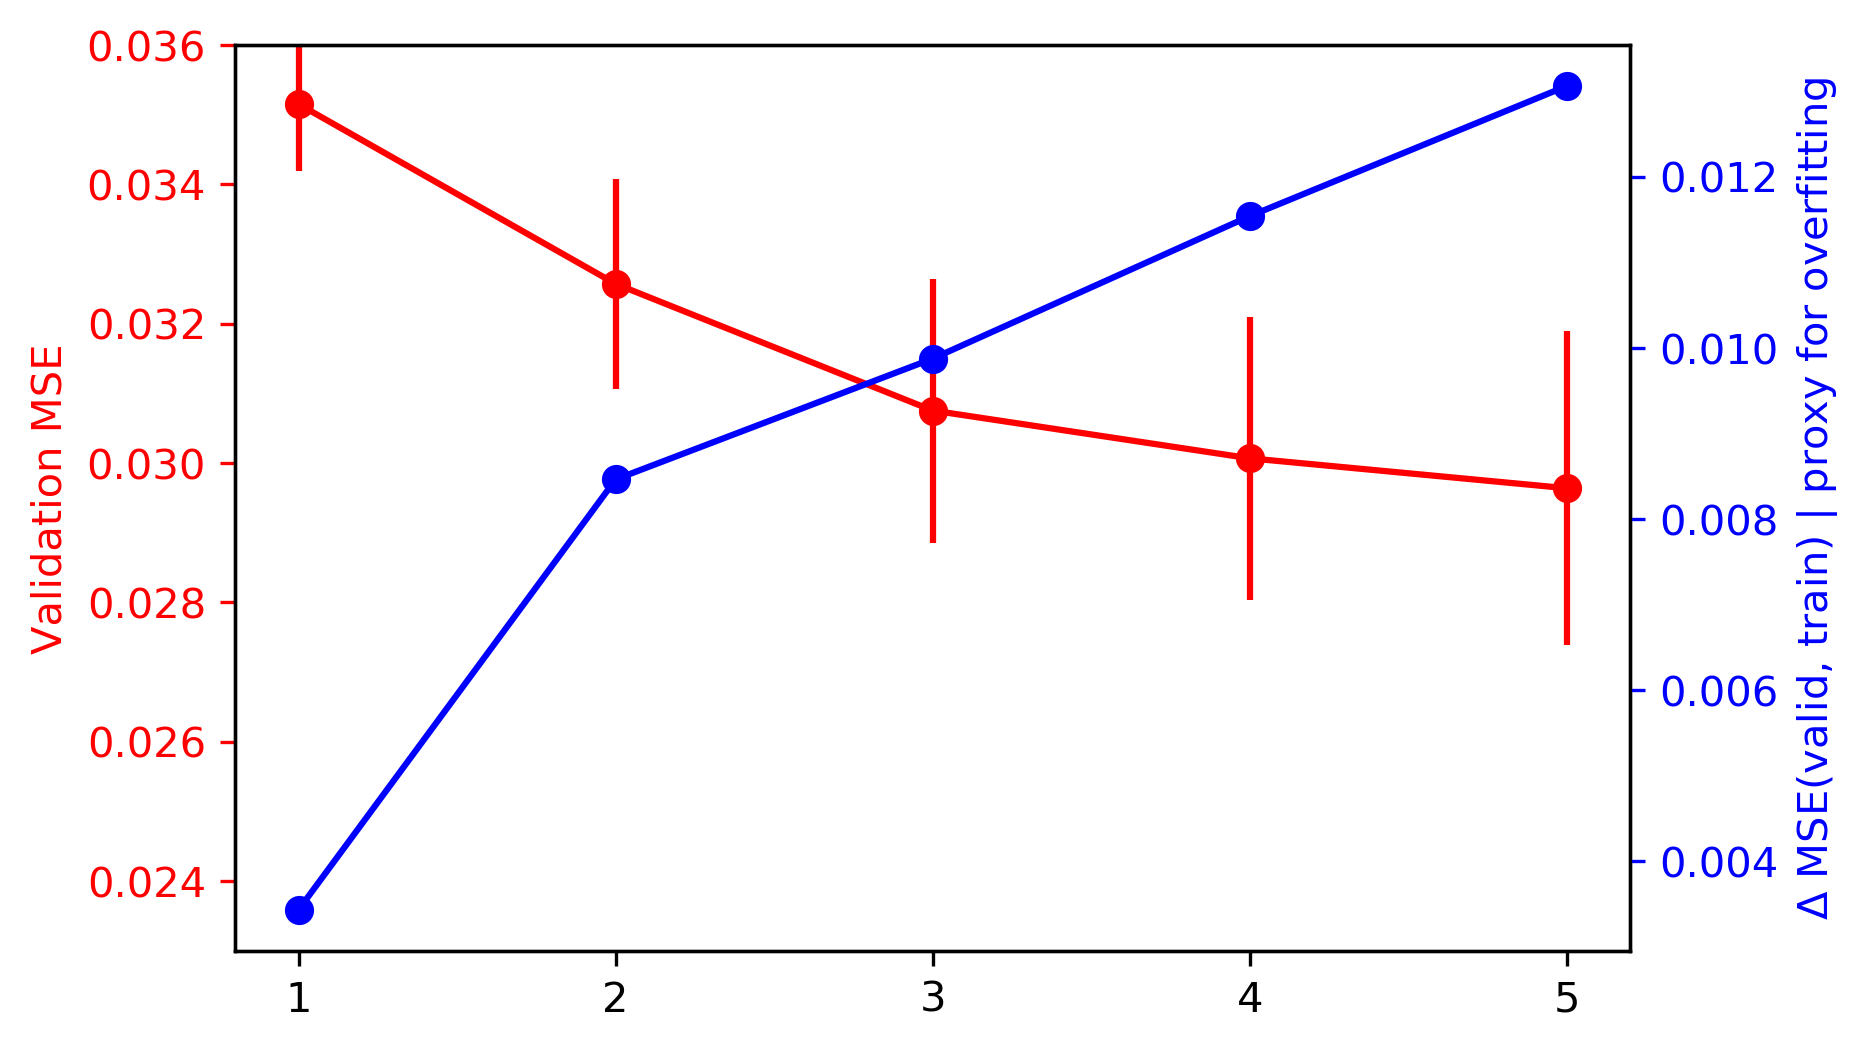

In [76]:
fig, ax = plt.subplots(dpi = 300)

ax.errorbar(x = [ii+1 for ii in range(5)], y =  CV_results['valid_mse_mean'],
            yerr= CV_results['valid_mse_std'],
            fmt='-o',
            color = 'r')

ax.set_ylabel('Validation MSE', color = "red")
ax.set_ylim([0.023, 0.036])

ax.tick_params(axis='y', colors="red")

ax2=ax.twinx()

ax2.errorbar(x = [ii+1 for ii in range(5)],
             y =  [val_mse-tr_mse for tr_mse, val_mse in zip( CV_results['train_mse_mean'],  CV_results['valid_mse_mean'] )],
            fmt='-o',
            color = 'b')
ax2.set_ylabel('$\Delta$ MSE(valid, train) | proxy for overfitting', color = "blue")
ax2.tick_params(axis='y', colors="blue")

ax2.set_xticks([ii+1 for ii in range(5)])
plt.show()



In [77]:
# save cross-validation dataframe:
CV_df.to_csv('./output/CV_results.csv', index = False)

### Summary:

As we use larger latent space dimension, our validation reconstruction loss (MSE) improves; however, we do end up overfitting more on the training dataset -- highlighted by the linear increase in $\Delta$ MSE(valid, train). Thus, z = 3 appears to have excellent MSE validation loss and lower overfitting on the training set.